# To-Do
Avg. CV IKI by word type (WF and BF)  
Words with highest/lowest CV IKI  
Bigrams with highest/lowest CV IKI  
Difference between avg. CV IKI by word type between individuals  

In [1]:
import os
import numpy as np
import pandas as pd
import math
import glob
import statistics as stat
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats
from scipy.stats import variation
from scipy.stats import wilcoxon
from scipy.stats import pearsonr
import warnings
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sb
import pingouin as pg
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings('ignore')

import typingmod as typ

# DATAFRAME SETUP AND FUNCTIONS
___

In [2]:
## setting save directory
save_dir = os.getcwd()
save_dir

'/Users/rubi/Desktop/Github/typingexp/typing_task_analysis'

In [3]:
## getting subject data folders from server
server = r'/Volumes/greenhouse/typingtask_data/subject_data'
os.chdir(server)
folders = os.listdir()

## looping through subject folders and getting appropriate .csv paths and making sID list
sub_folders = list(filter(lambda x: x.startswith('s', 0, 1), folders))
all_bytrial = []
all_bybigram = []
ID_list = []
for sub in sub_folders:
    sub_folder = r'/Volumes/greenhouse/typingtask_data/subject_data/%s/psychopy_data/edited' % sub
    os.chdir(sub_folder)
    sID = sub.split('_', 1)[0]
    bytrial = pd.read_csv(glob.glob('*_bytrial.csv')[0])
    bybigram = pd.read_csv(glob.glob('*_bybigram.csv')[0])
    all_bytrial.append(bytrial)
    all_bybigram.append(bybigram)
    ID_list.append(sID)

## looping through subject folders and getting appropriate .csv paths and making sID list
server_noturbo = r'/Volumes/greenhouse/typingtask_data/subject_data/not_used/no_turbotyping/'
os.chdir(server_noturbo)
folders_noturbo = os.listdir()

sub_folders = list(filter(lambda x: x.startswith('s', 0, 1), folders_noturbo))
## gets data from subjects without turbotyping
for sub in sub_folders:
    sub_folder = server_noturbo + r'%s/psychopy_data/edited' % sub
    os.chdir(sub_folder)
    sID = sub.split('_', 1)[0]
    bytrial = pd.read_csv(glob.glob('*_bytrial.csv')[0])
    bybigram = pd.read_csv(glob.glob('*_bybigram.csv')[0])
    all_bytrial.append(bytrial)
    all_bybigram.append(bybigram)
    ID_list.append(sID)

## concatenating all trial-based dataframes
all_trials = pd.concat(all_bytrial).reset_index(drop=True)
all_trials.drop(columns = ['Unnamed: 0'], inplace = True)
all_trials = all_trials.sort_values(by=['sID', 'trial_num', 'rep_num'])

all_rts = typ.rt_columns(all_trials)
all_trials = pd.concat([all_trials, typ.iki(all_rts).drop(columns=['string'])], axis = 1)

change = {}
for col in all_trials.columns:
    if isinstance(col, int):
        change[col] = 'iki_' + str(int(col)+1)
all_trials = all_trials.rename(columns=change)

## concatenating all bigram-based dataframes
all_bigrams = pd.concat(all_bybigram).reset_index(drop=True).sort_values(by=['sID'])
all_bigrams.drop(columns = ['Unnamed: 0'], inplace = True)
all_bigrams = all_bigrams.sort_values(by=['sID', 'trial_num', 'rep_num', 'bigram_loc'])

## sorting by ascending value
ID_list.sort()

In [4]:
len(ID_list)

34

In [5]:
## keep ?? 

plt.rcParams['font.size'] = '30'
np.seterr(invalid='ignore') ## gets rid of runtime error about invalid division

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [6]:
## making filtered dataframes by errors
corr_trials = (all_trials[all_trials.string == all_trials.resp_string]).reset_index(drop=True)
incorr_trials = (all_trials[all_trials.string != all_trials.resp_string]).reset_index(drop=True)

corr_trials_bybg = (all_bigrams[all_bigrams.string == all_bigrams.resp_string]).reset_index(drop=True)
incorr_trials_bybg = (all_bigrams[all_bigrams.string != all_bigrams.resp_string]).reset_index(drop=True)

corr_bgs = (all_bigrams[all_bigrams.bigram == all_bigrams.bigram]).reset_index(drop=True) ## excludes only incorrect bigrams 
incorr_bgs = (all_bigrams[all_bigrams.bigram != all_bigrams.bigram]).reset_index(drop=True)

corr_rts = typ.rt_columns(corr_trials)
incorr_rts = typ.rt_columns(incorr_trials)

## making dataframe with only correct trials that have ikis within 2sd of the inividuals mean iki (iki is by posiiton)
tight_trials = pd.DataFrame()
for subject in ID_list:
    sub_df = corr_trials[corr_trials.sID == subject]
    for col in sub_df.columns:
        if col.startswith('iki_'):
            avg_iki = sub_df[col].mean()
            sd_iki = sub_df[col].std()
            sub_df = sub_df[(sub_df[col] < (avg_iki + 2*sd_iki)) & (sub_df[col] > (avg_iki - 2*sd_iki))]
    tight_trials = pd.concat([tight_trials, sub_df])

## making dataframe with only correct bigrams that have ikis within 2sd of the individuals mean iki (across all ikis)
tight_bgs = pd.DataFrame()
for subject in ID_list:
    sub_df = corr_trials_bybg[corr_trials_bybg.sID == subject]
    avg_iki = sub_df['IKI'].mean()
    sd_iki = sub_df['IKI'].std()
    sub_df = sub_df[(sub_df.IKI < (avg_iki + 2*sd_iki)) & (sub_df.IKI > (avg_iki - 2*sd_iki))]
    tight_bgs = pd.concat([tight_bgs, sub_df])
    
## making dataframe with both correct and incorrect bigrams that have ikis within 2sd
all_tight_bgs = pd.DataFrame()
for subject in ID_list:
    sub_df = all_bigrams[all_bigrams.sID == subject]
    avg_iki = sub_df['IKI'].mean()
    sd_iki = sub_df['IKI'].std()
    sub_df = sub_df[(sub_df.IKI < (avg_iki + 2*sd_iki)) & (sub_df.IKI > (avg_iki - 2*sd_iki))]
    all_tight_bgs = pd.concat([all_tight_bgs, sub_df])

In [7]:
## defining functions that calculate individual IKI means and CVs for a particular bigram in a defined string
##### these need to be edited to include changable dataframe like the other functions

def indiv_means_bybg(string, bigram):
    DF = tight_bgs.query('string == @string and bigram == @bigram')
    means = pd.DataFrame(DF.groupby('sID').IKI.agg(['mean']))
    return means

def indiv_cvs_bybg(string, bigram):
    DF = tight_bgs.query('string == @string and bigram == @bigram')
    cvs = pd.DataFrame(DF.groupby('sID').IKI.agg([variation]))
    return cvs

## defining functions that calculate indivdual IKI means and Avg. CVS by word and bigram groupings

def indiv_means(dataframe, str_or_bg, sort_type): ## str_or_bg can be 'string' or 'bigram'
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    means = pd.DataFrame(DF.groupby('sID').IKI.agg(['mean'])).reset_index().rename(columns = {'mean':'Avg IKI'})
    # means.columns = ['Avg IKI']
    return means

def indiv_avgcvs(dataframe, str_or_bg, sort_type):
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    else:
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    cvs = DF.groupby(['sID', str_or_bg]).IKI.agg([variation])
    avg_cvs = pd.DataFrame(cvs.groupby('sID').variation.agg(['mean'])).reset_index().rename(columns = {'mean':'Avg CV IKI'})
    # avg_cvs.columns = ['Avg CV IKI']
    return avg_cvs

def indiv_avgsds(dataframe, str_or_bg, sort_type):
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    else:
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    sds = DF.groupby(['sID', str_or_bg]).IKI.agg(['std'])
    sds = sds.rename(columns={'std':'sd'})
    avg_sds = pd.DataFrame(sds.groupby('sID').sd.agg(['mean'])).reset_index().rename(columns = {'mean':'Avg SD IKI'})
    # avg_sds.columns = ['Avg SD IKI']
    return avg_sds

def indiv_error(dataframe, str_or_bg, sort_type):
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    else:
        print('please write "string" or "bigram"for str_or_bg variable')
    errs = pd.DataFrame(DF.groupby(['sID']).size()).reset_index().rename(columns = {0:'Total Error'})
    for ID in dataframe.sID.unique():
        if ID not in list(errs['sID']):
            # no_err_ID = [ID, 0]
            errs.loc[len(errs.index)] = [ID, 0]
            errs = errs.sort_values('sID', ignore_index=True)
    return errs

In [8]:
## Making dataframe of IKI stats
bg_stats = pd.DataFrame()
for index, bg in enumerate(typ.bg_freqs['Bigrams']):
    bg_stats.loc[index, 'Bigram'] = bg
    df = corr_trials_bybg[corr_trials_bybg['bigram'] == bg].reset_index()
    bg_stats.loc[index, 'Mean'] = df['IKI'].mean()
    bg_stats.loc[index, 'SD'] = np.std(df['IKI'])
    bg_stats.loc[index, 'CV'] = variation(df['IKI'], nan_policy='omit')
    bg_stats.loc[index, 'Frequency'] = typ.bg_freqs.loc[index, 'Frequency']
    bg_stats.loc[index, 'bf_type'] = df.loc[1, 'bf_type']
    
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     print(bg_stats)
# bg_stats

In [9]:
## making data frames with for individual stats for each bigram
cvs = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg([variation])).reset_index()
for index, bg in enumerate(cvs['bigram']):
    if bg in list(typ.highbf):
        cvs.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        cvs.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        cvs.loc[index, 'bf_type'] = 'Low'     

sds = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg(['std'])).reset_index()
for index, bg in enumerate(sds['bigram']):
    if bg in list(typ.highbf):
        sds.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        sds.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        sds.loc[index, 'bf_type'] = 'Low' 

ikis = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg(['mean'])).reset_index()
for index, bg in enumerate(ikis['bigram']):
    if bg in list(typ.highbf):
        ikis.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        ikis.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        ikis.loc[index, 'bf_type'] = 'Low'

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     print(ikis)

In [10]:
## making lists of bigrams without bigrams with repeated letters
med_reps = ['ll', 'ee', 'oo', 'pp']    
medbf_norep = list(filter(lambda x: x not in med_reps, typ.medbf))

typ.lowbf
low_reps = ['dd', 'kk']
lowbf_norep = list(filter(lambda x: x not in low_reps, typ.lowbf))

# STATS
___

In [11]:
high_iki = indiv_means(corr_trials_bybg, 'bigram', typ.highbf)
high_iki['bf_type'] = 'high'
med_iki = indiv_means(corr_trials_bybg, 'bigram', typ.medbf)
med_iki['bf_type'] = 'med'
low_iki = indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)
low_iki['bf_type'] = 'low'

print(stat.stdev(high_iki['Avg IKI']))
print(stat.stdev(med_iki['Avg IKI']))
print(stat.stdev(low_iki['Avg IKI']))

0.03699650103283469
0.03568845861762561
0.04461555425376567


In [12]:
## anova for means (by bg freq)
high_iki = indiv_means(corr_trials_bybg, 'bigram', typ.highbf)
high_iki['bf_type'] = 'high'
med_iki = indiv_means(corr_trials_bybg, 'bigram', typ.medbf)
med_iki['bf_type'] = 'med'
low_iki = indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)
low_iki['bf_type'] = 'low'

ikis = pd.concat([high_iki, med_iki, low_iki], ignore_index=True)
# print(ikis)

iki_anova = pg.rm_anova(ikis, 'Avg IKI', 'bf_type', 'sID')
print(iki_anova)

pg.pairwise_tukey(ikis, 'Avg IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2           F         p-unc       ng2       eps
0  bf_type      2     60  151.748756  3.384498e-24  0.300854  0.814412


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A    B   mean(A)   mean(B)      diff        se         T       p-tukey  \
0  high  low  0.145643  0.207536 -0.061892  0.009982 -6.200613  5.003570e-08   
1  high  med  0.145643  0.172008 -0.026364  0.009982 -2.641265  2.610503e-02   
2   low  med  0.207536  0.172008  0.035528  0.009982  3.559347  1.711652e-03   

      cohen  
0 -1.510179  
1 -0.725320  
2  0.879425

In [13]:
## anova for means (by avg bg freq)
high_iki = indiv_means(corr_trials_bybg, 'string', typ.avg_highbf)
high_iki['bf_type'] = 'high'
med_iki = indiv_means(corr_trials_bybg, 'string', typ.avg_medbf)
med_iki['bf_type'] = 'med'
low_iki = indiv_means(corr_trials_bybg, 'string', typ.avg_lowbf)
low_iki['bf_type'] = 'low'

ikis = pd.concat([high_iki, med_iki, low_iki], ignore_index=True)
# print(ikis)

iki_anova = pg.rm_anova(ikis, 'Avg IKI', 'bf_type', 'sID')
print(iki_anova)

pg.pairwise_tukey(ikis, 'Avg IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2           F         p-unc      ng2      eps
0  bf_type      2     60  215.699303  3.995029e-28  0.33312  0.70471


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A    B   mean(A)   mean(B)      diff        se         T       p-tukey  \
0  high  low  0.146689  0.210078 -0.063389  0.009794 -6.472180  1.481720e-08   
1  high  med  0.146689  0.163528 -0.016838  0.009794 -1.719252  2.036220e-01   
2   low  med  0.210078  0.163528  0.046550  0.009794  4.752928  2.240817e-05   

      cohen  
0 -1.605374  
1 -0.473783  
2  1.150106

In [14]:
## anova for means (by word freq)
# only_onebf = corr_trials_bybg[corr_trials_bybg.bf_type == 'low']

high_iki = indiv_means(corr_trials_bybg, 'string', typ.highwf)
high_iki['wf_type'] = 'high'
med_iki = indiv_means(corr_trials_bybg, 'string', typ.medwf)
med_iki['wf_type'] = 'med'
low_iki = indiv_means(corr_trials_bybg, 'string', typ.lowwf)
low_iki['wf_type'] = 'low'
pseudo_iki = indiv_means(corr_trials_bybg, 'string', typ.pseudo)
pseudo_iki['wf_type'] = 'pseudo'

ikis = pd.concat([high_iki, med_iki, low_iki, pseudo_iki], ignore_index=True)
# print(ikis)

iki_anova = pg.rm_anova(ikis, 'Avg IKI', 'wf_type', 'sID')
print(iki_anova)

pg.pairwise_tukey(ikis, 'Avg IKI', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  wf_type      3     90  29.081928  3.079827e-13  0.088441  0.711514


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low  0.157443  0.183998 -0.026555  0.009973 -2.662584  0.043175   
1  high     med  0.157443  0.165650 -0.008207  0.009973 -0.822879  0.843541   
2  high  pseudo  0.157443  0.185736 -0.028293  0.009973 -2.836859  0.027090   
3   low     med  0.183998  0.165650  0.018348  0.009973  1.839705  0.260003   
4   low  pseudo  0.183998  0.185736 -0.001738  0.009973 -0.174275  0.998109   
5   med  pseudo  0.165650  0.185736 -0.020086  0.009973 -2.013980  0.188597   

      cohen  
0 -0.690747  
1 -0.231251  
2 -0.712627  
3  0.472608  
4 -0.040697  
5 -0.501280

In [15]:
## anova for cvs (by bg freq)
high_cv = indiv_avgcvs(corr_trials_bybg, 'bigram', typ.highbf)
high_cv['bf_type'] = 'high'
med_cv = indiv_avgcvs(corr_trials_bybg, 'bigram', typ.medbf)
med_cv['bf_type'] = 'med'
low_cv = indiv_avgcvs(corr_trials_bybg, 'bigram', typ.lowbf)
low_cv['bf_type'] = 'low'

cvs = pd.concat([high_cv, med_cv, low_cv], ignore_index=True)
# print(cvs)

cv_anova = pg.rm_anova(cvs, 'Avg CV IKI', 'bf_type', 'sID')
print(cv_anova)

pg.pairwise_tukey(cvs, 'Avg CV IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2          F     p-unc       ng2       eps
0  bf_type      2     60  16.679768  0.000002  0.137959  0.752671


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low  0.277175  0.264939  0.012236  0.015099  0.810389  0.697589   
1  high  med  0.277175  0.222575  0.054600  0.015099  3.616106  0.001419   
2   low  med  0.264939  0.222575  0.042364  0.015099  2.805716  0.016777   

      cohen  
0  0.190899  
1  0.878804  
2  0.825663

In [16]:
## anova for cvs (by avg bg freq)
high_cv = indiv_avgcvs(corr_trials_bybg, 'string', typ.avg_highbf)
high_cv['bf_type'] = 'high'
med_cv = indiv_avgcvs(corr_trials_bybg, 'string', typ.avg_medbf)
med_cv['bf_type'] = 'med'
low_cv = indiv_avgcvs(corr_trials_bybg, 'string', typ.avg_lowbf)
low_cv['bf_type'] = 'low'

cvs = pd.concat([high_cv, med_cv, low_cv], ignore_index=True)
# print(cvs)

cv_anova = pg.rm_anova(cvs, 'Avg CV IKI', 'bf_type', 'sID')
print(cv_anova)

pg.pairwise_tukey(cvs, 'Avg CV IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2          F     p-unc       ng2       eps
0  bf_type      2     60  11.884929  0.000045  0.080303  0.900391


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low  0.370451  0.441472 -0.071021  0.025442 -2.791484  0.017446   
1  high  med  0.370451  0.411620 -0.041169  0.025442 -1.618151  0.243285   
2   low  med  0.441472  0.411620  0.029852  0.025442  1.173333  0.472109   

      cohen  
0 -0.730356  
1 -0.392910  
2  0.303656

In [17]:
## anova for cvs (by word freq)

high_iki = indiv_avgcvs(corr_trials_bybg, 'string', typ.highwf)
high_iki['wf_type'] = 'high'
med_iki = indiv_avgcvs(corr_trials_bybg, 'string', typ.medwf)
med_iki['wf_type'] = 'med'
low_iki = indiv_avgcvs(corr_trials_bybg, 'string', typ.lowwf)
low_iki['wf_type'] = 'low'
pseudo_iki = indiv_avgcvs(corr_trials_bybg, 'string', typ.pseudo)
pseudo_iki['wf_type'] = 'pseudo'

ikis = pd.concat([high_iki, med_iki, low_iki, pseudo_iki], ignore_index=True)
# print(ikis)

iki_anova = pg.rm_anova(ikis, 'Avg CV IKI', 'wf_type', 'sID')
print(iki_anova)

pg.pairwise_tukey(ikis, 'Avg CV IKI', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc     p-GG-corr       ng2  \
0  wf_type      3     90  15.873579  2.296219e-08  6.491639e-07  0.131366   

        eps  sphericity   W-spher   p-spher  
0  0.769898       False  0.627407  0.020064  


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low  0.371803  0.415626 -0.043823  0.026582 -1.648617  0.355595   
1  high     med  0.371803  0.373749 -0.001946  0.026582 -0.073216  0.999858   
2  high  pseudo  0.371803  0.470211 -0.098408  0.026582 -3.702076  0.001822   
3   low     med  0.415626  0.373749  0.041877  0.026582  1.575401  0.396513   
4   low  pseudo  0.415626  0.470211 -0.054585  0.026582 -2.053459  0.174562   
5   med  pseudo  0.373749  0.470211 -0.096462  0.026582 -3.628860  0.002342   

      cohen  
0 -0.425161  
1 -0.018507  
2 -0.918446  
3  0.410163  
4 -0.524136  
5 -0.908238

In [18]:
## anova for sds (by bg freq)
high_sd = indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)
high_sd['bf_type'] = 'high'
med_sd = indiv_avgsds(corr_trials_bybg, 'bigram', medbf_norep)
med_sd['bf_type'] = 'med'
low_sd = indiv_avgsds(corr_trials_bybg, 'bigram', lowbf_norep)
low_sd['bf_type'] = 'low'

sds = pd.concat([high_sd, med_sd, low_sd], ignore_index=True)
# print(sds)

sd_anova = pg.rm_anova(sds, 'Avg SD IKI', 'bf_type', 'sID')
print(sd_anova)

pg.pairwise_tukey(sds, 'Avg SD IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  bf_type      2     60  24.533227  1.636069e-08  0.164386  0.674495


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low  0.046731  0.066910 -0.020179  0.005595 -3.606684  0.001464   
1  high  med  0.046731  0.046319  0.000412  0.005595  0.073577  0.997020   
2   low  med  0.066910  0.046319  0.020590  0.005595  3.680261  0.001145   

      cohen  
0 -0.851861  
1  0.020413  
2  0.932301

In [19]:
## anova for sds (by avg bg freq)
high_sd = indiv_avgsds(corr_trials_bybg, 'string', typ.avg_highbf)
high_sd['bf_type'] = 'high'
med_sd = indiv_avgsds(corr_trials_bybg, 'string', typ.avg_medbf)
med_sd['bf_type'] = 'med'
low_sd = indiv_avgsds(corr_trials_bybg, 'string', typ.avg_lowbf)
low_sd['bf_type'] = 'low'

sds = pd.concat([high_sd, med_sd, low_sd], ignore_index=True)
# print(sds)

sd_anova = pg.rm_anova(sds, 'Avg SD IKI', 'bf_type', 'sID')
print(sd_anova)

pg.pairwise_tukey(sds, 'Avg SD IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  bf_type      2     60  51.529415  9.423404e-14  0.251801  0.748142


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low  0.057969  0.099315 -0.041346  0.007723 -5.353885  0.000002   
1  high  med  0.057969  0.070117 -0.012148  0.007723 -1.573049  0.262546   
2   low  med  0.099315  0.070117  0.029198  0.007723  3.780836  0.000814   

      cohen  
0 -1.308704  
1 -0.454565  
2  0.896436

In [20]:
## anova for sds (by word freq)

high_iki = indiv_avgsds(corr_trials_bybg, 'string', typ.highwf)
high_iki['wf_type'] = 'high'
med_iki = indiv_avgsds(corr_trials_bybg, 'string', typ.medwf)
med_iki['wf_type'] = 'med'
low_iki = indiv_avgsds(corr_trials_bybg, 'string', typ.lowwf)
low_iki['wf_type'] = 'low'
pseudo_iki = indiv_avgsds(corr_trials_bybg, 'string', typ.pseudo)
pseudo_iki['wf_type'] = 'pseudo'

ikis = pd.concat([high_iki, med_iki, low_iki, pseudo_iki], ignore_index=True)
# print(ikis)

iki_anova = pg.rm_anova(ikis, 'Avg SD IKI', 'wf_type', 'sID')
print(iki_anova)

pg.pairwise_tukey(ikis, 'Avg SD IKI', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  wf_type      3     90  22.285358  7.031512e-11  0.156363  0.749278


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low  0.060172  0.084164 -0.023992  0.007994 -3.001411  0.017011   
1  high     med  0.060172  0.065831 -0.005658  0.007994 -0.707868  0.893807   
2  high  pseudo  0.060172  0.093034 -0.032861  0.007994 -4.110992  0.000417   
3   low     med  0.084164  0.065831  0.018334  0.007994  2.293543  0.105264   
4   low  pseudo  0.084164  0.093034 -0.008869  0.007994 -1.109582  0.684357   
5   med  pseudo  0.065831  0.093034 -0.027203  0.007994 -3.403124  0.004957   

      cohen  
0 -0.774078  
1 -0.224761  
2 -1.123760  
3  0.546434  
4 -0.241664  
5 -0.851693

In [21]:
## anova for error rates (by bg freq)
high_err = indiv_error(incorr_bgs, 'bigram', typ.highbf)
high_err['bf_type'] = 'high'
med_err = indiv_error(incorr_bgs, 'bigram', typ.medbf)
med_err['bf_type'] = 'med'
low_err = indiv_error(incorr_bgs, 'bigram', typ.lowbf)
low_err['bf_type'] = 'low'

errs = pd.concat([high_err, med_err, low_err], ignore_index=True)

err_anova = pg.rm_anova(errs, 'Total Error', 'bf_type', 'sID')
print(err_anova)

pg.pairwise_tukey(errs, 'Total Error', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2
0  bf_type      2     58


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A    B  mean(A)  mean(B)  diff   se   T  p-tukey  cohen
0  high  low      0.0      0.0   0.0  0.0 NaN      NaN    NaN
1  high  med      0.0      0.0   0.0  0.0 NaN      NaN    NaN
2   low  med      0.0      0.0   0.0  0.0 NaN      NaN    NaN

In [22]:
## anova for error rates (by avg bg freq)
high_err = indiv_error(incorr_trials, 'string', typ.avg_highbf)
high_err['bf_type'] = 'high'
med_err = indiv_error(incorr_trials, 'string', typ.avg_medbf)
med_err['bf_type'] = 'med'
low_err = indiv_error(incorr_trials, 'string', typ.avg_lowbf)
low_err['bf_type'] = 'low'

errs = pd.concat([high_err, med_err, low_err], ignore_index=True)

err_anova = pg.rm_anova(errs, 'Total Error', 'bf_type', 'sID')
print(err_anova)

pg.pairwise_tukey(errs, 'Total Error', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2         F     p-unc  p-GG-corr       ng2     eps  \
0  bf_type      2     60  4.135332  0.020774   0.032525  0.027958  0.7508   

   sphericity   W-spher   p-spher  
0       False  0.668088  0.002885  


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low  5.516129  7.580645 -2.064516  1.283188 -1.608896  0.247158   
1  high  med  5.516129  6.548387 -1.032258  1.283188 -0.804448  0.701250   
2   low  med  7.580645  6.548387  1.032258  1.283188  0.804448  0.701250   

      cohen  
0 -0.411630  
1 -0.227487  
2  0.185938

In [23]:
## running signed rank test
# wilcoxon()

# iki_ranks = (indiv_means(tight_bgs, 'bigram', typ.highbf).sort_values(by = 'Avg IKI', ignore_index = True)) ## ranked by ascending mean IKI
# iki_ranks['rank'] = iki_ranks.index
# iki_ranks = iki_ranks.sort_values(by = 'sID', ignore_index=True)

# cv_ranks = (indiv_avgcvs(tight_bgs, 'bigram', typ.highbf).sort_values(by = 'Avg CV IKI', ignore_index = True)) ## ranked by ascending mean CV IKI
# cv_ranks['rank'] = cv_ranks.index
# cv_ranks = cv_ranks.sort_values(by = 'sID', ignore_index=True)

# rank_diff = iki_ranks['rank'] - cv_ranks['rank']
# rank_diff

# wilcoxon(rank_diff)

# ranksums(indiv_means(tight_bgs, 'bigram', typ.highbf)['Avg IKI'], 
#          indiv_avgcvs(tight_bgs, 'bigram', typ.highbf)['Avg CV IKI'])

# ranksums(indiv_means(all_bigrams, 'bigram', typ.highbf)['Avg IKI'],
#          indiv_avgcvs(all_bigrams, 'bigram', typ.highbf)['Avg CV IKI'])

In [24]:
skew_df = pd.DataFrame()
for index, ID in enumerate(ID_list):
    skew_df.loc[index, 'sID'] = ID
    skew_df.loc[index, 'skew'] = (corr_bgs[corr_bgs.sID == ID])['IKI'].skew()
    skew_df.loc[index, 'mean IKI'] = (corr_bgs[corr_bgs.sID == ID])['IKI'].mean()
    
skew_df.to_csv('skew_df.csv')
skew_df

sID      skew  mean IKI
0    s09  4.696935  0.133438
1   s175  2.812111  0.194981
2   s176  2.746414  0.207627
3   s178  8.837334  0.159816
4   s180  3.437835  0.135324
5   s181  5.406235  0.120192
6   s182  4.570638  0.172702
7   s183  3.890498  0.163195
8   s189  8.362362  0.175457
9   s190  2.705453  0.163118
10  s198  3.841072  0.162882
11   s20  3.162703  0.193328
12   s20  3.162703  0.193328
13  s207  3.631625  0.175875
14  s209  5.860551  0.139340
15  s209  5.860551  0.139340
16  s210  3.556854  0.181700
17  s212  4.041981  0.176087
18  s217  2.553417  0.138495
19  s217  2.553417  0.138495
20  s219  3.540230  0.250491
21  s224  5.321664  0.152211
22  s240  2.192719  0.154442
23  s254  2.417222  0.268124
24  s261  1.817268  0.139224
25  s262  6.201964  0.133787
26  s263  3.651799  0.190429
27  s267  2.431038  0.211358
28  s276  8.592255  0.176815
29  s278  4.664049  0.178351
30  s279  1.533092  0.241196
31  s282  2.525216  0.247086
32  s283  3.789123  0.160984
33  s286  3.287198  0.204666

# GRAPHS
___

## Data Visualization
___

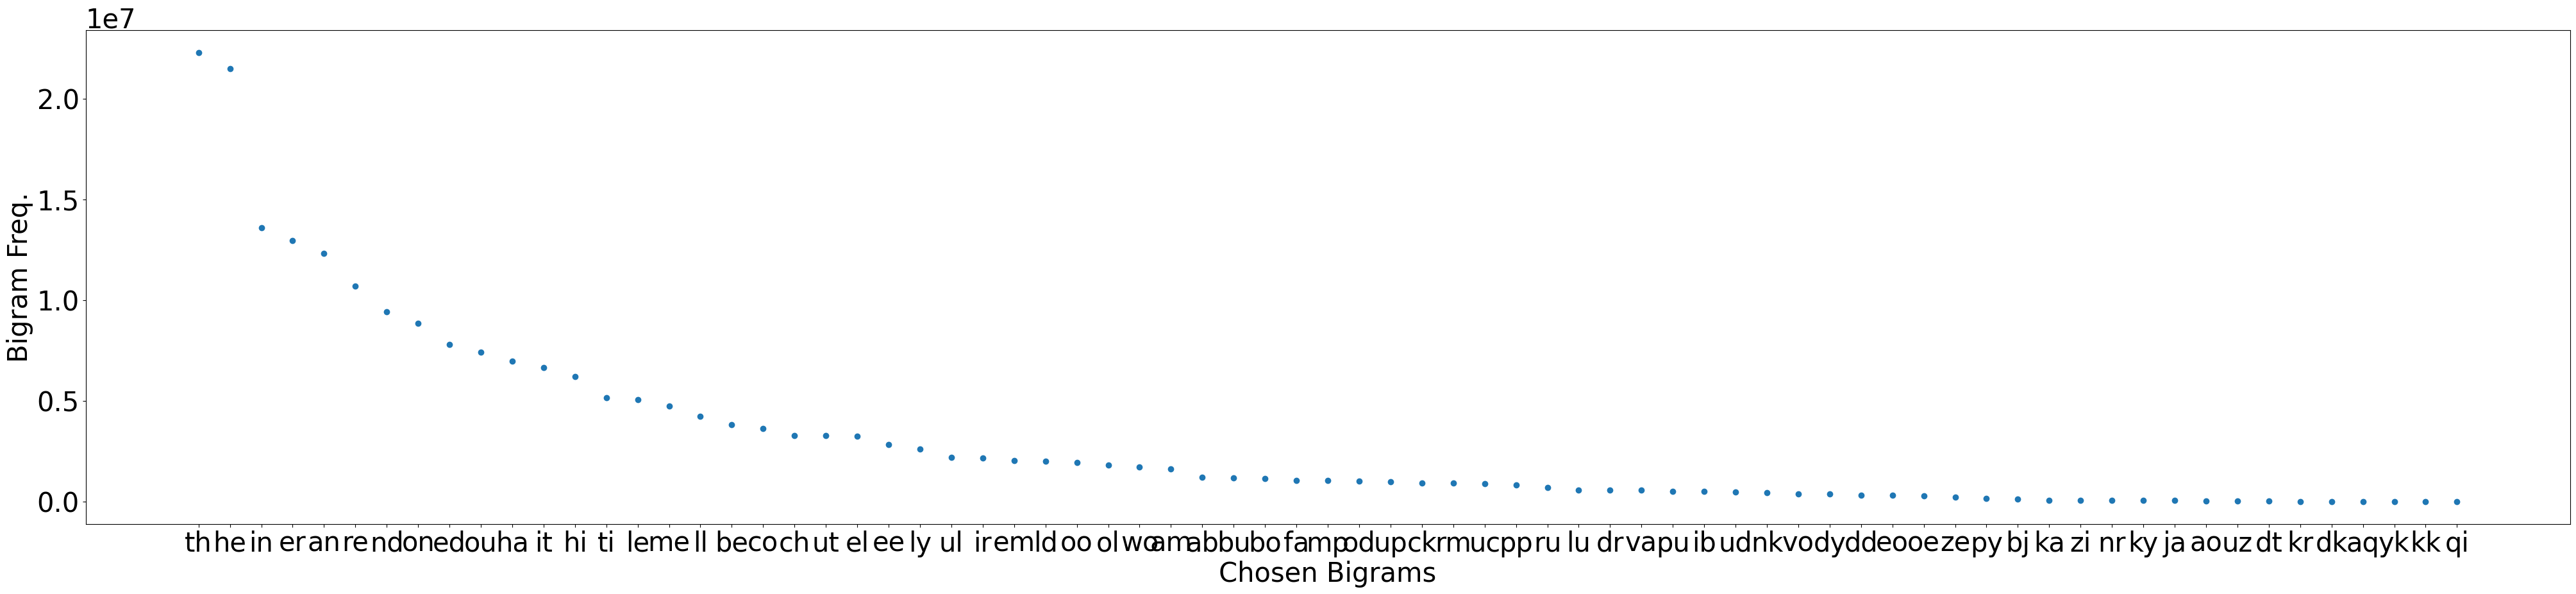

In [25]:
## bigram frequency distribution
plt.figure(figsize=(50, 10))
bg_freq = plt.scatter(typ.bg_freqs['Bigrams'], typ.bg_freqs['Frequency'])

plt.xlabel("Chosen Bigrams")
plt.ylabel("Bigram Freq.")
plt.title("")

plt.show()

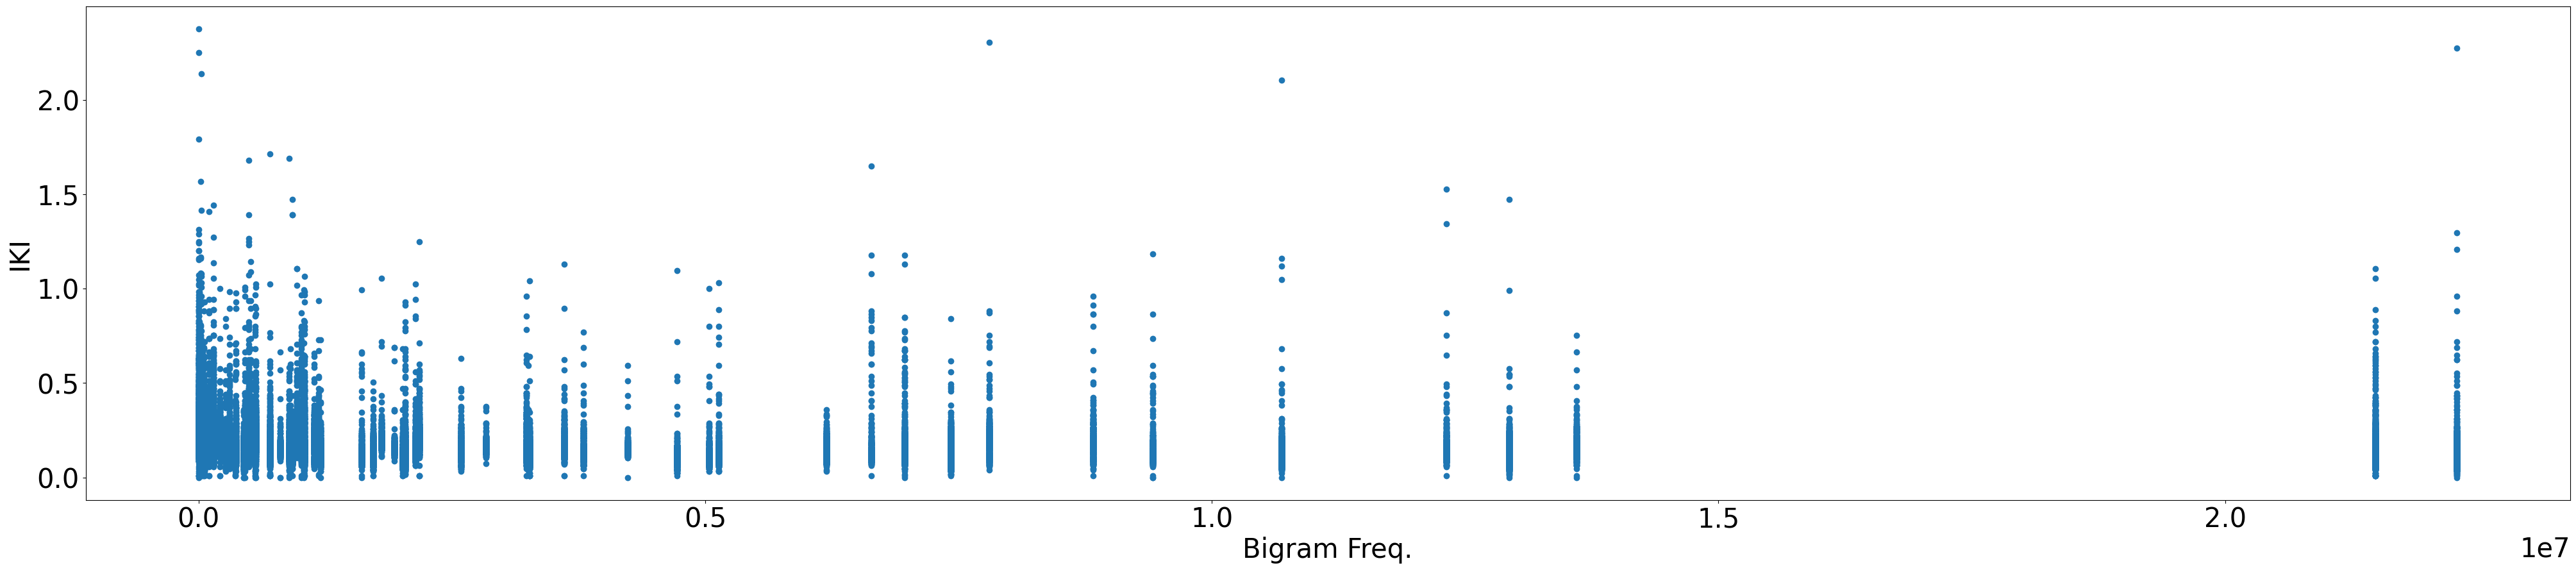

In [26]:
## IKI by Bigram Frequency
plt.figure(figsize=(50, 10))
bg_freq = plt.scatter(all_bigrams['bg_freq'], all_bigrams['IKI'])

plt.ylabel("IKI")
plt.xlabel("Bigram Freq.")
plt.title("")

plt.show()

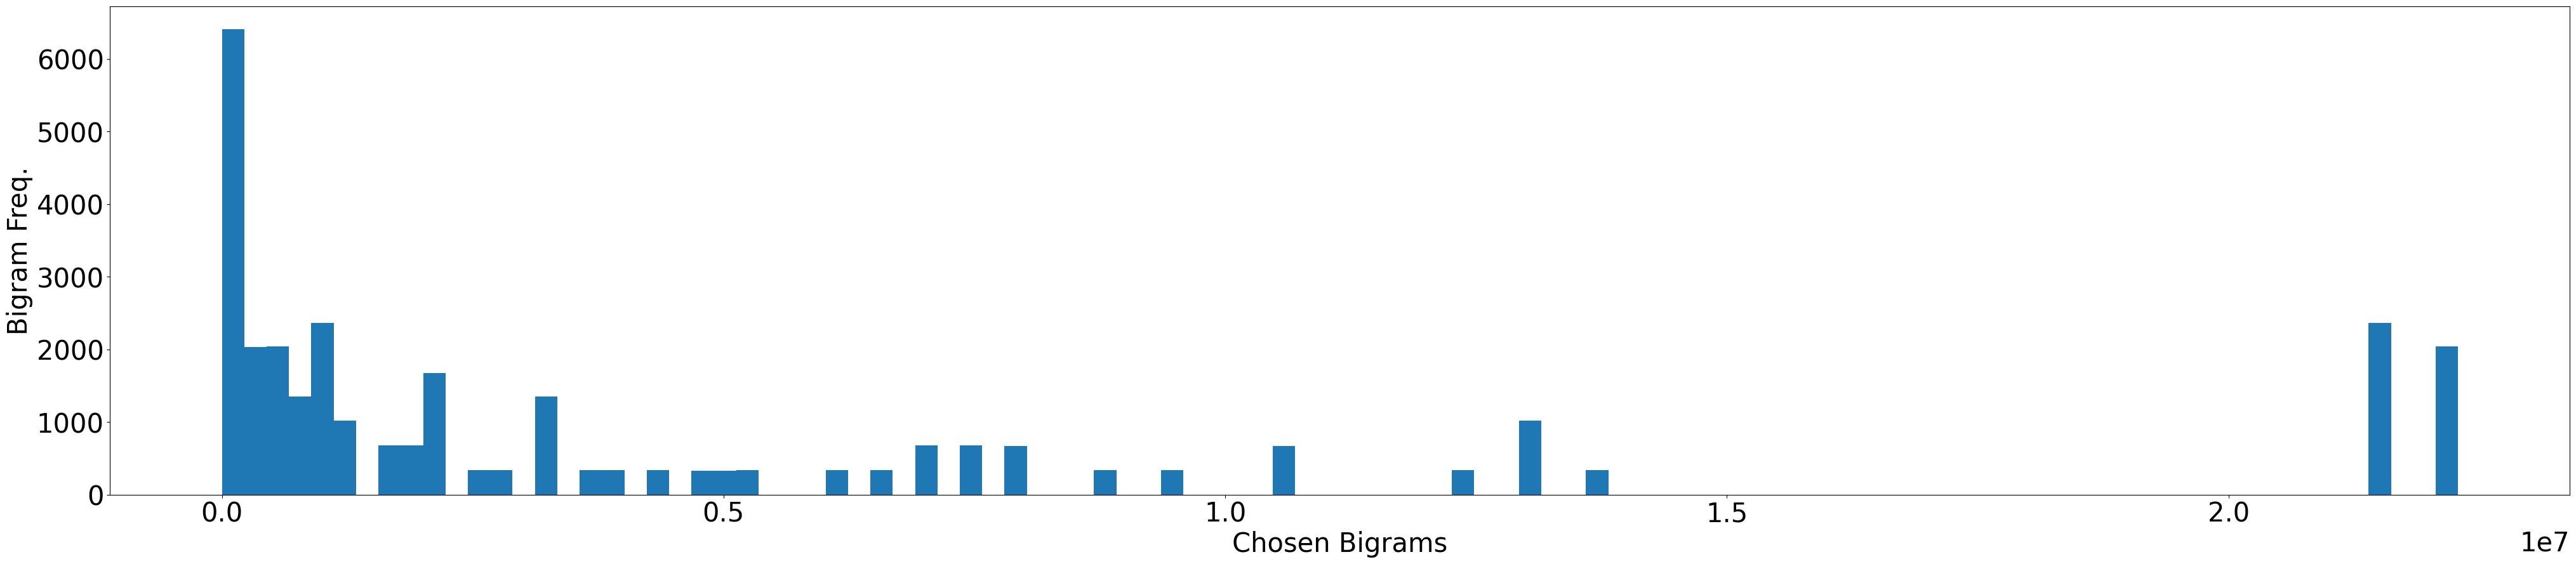

In [27]:
## Histogram of bigram frequencies
plt.figure(figsize=(50, 10))
bg_freq = plt.hist(all_bigrams['bg_freq'], bins = 100)

plt.xlabel("Chosen Bigrams")
plt.ylabel("Bigram Freq.")
plt.title("")

plt.show()

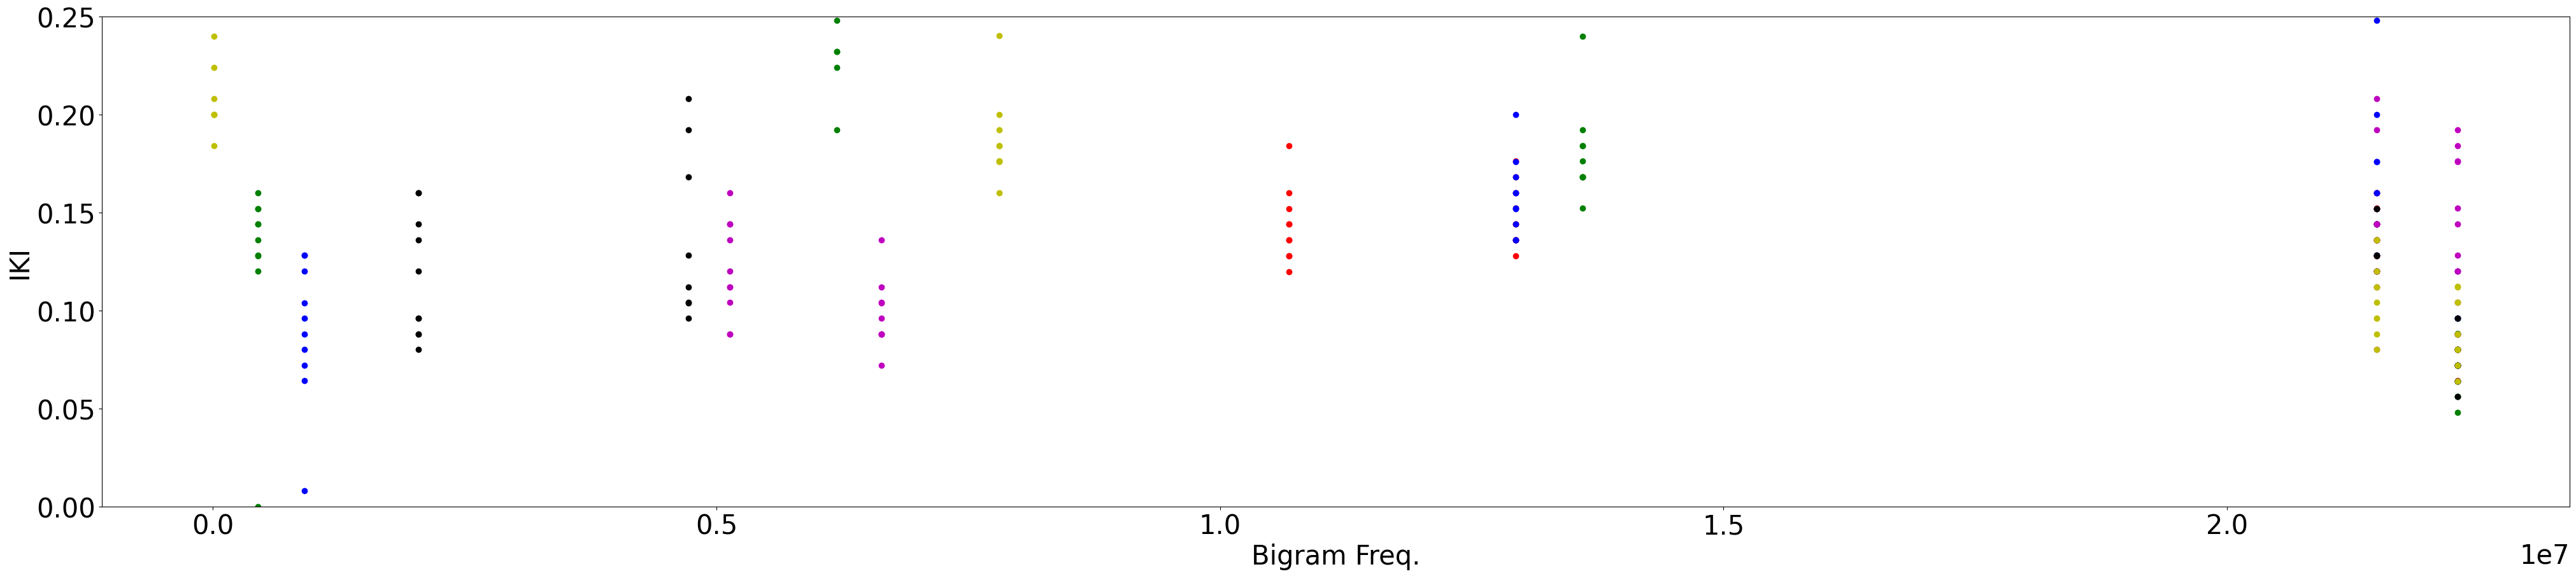

In [28]:
## IKI by Bigram Frequency
plt.figure(figsize=(50, 10))
# bg_freq = plt.scatter(all_bigrams[all_bigrams.sID == 's175']['bg_freq'], all_bigrams[all_bigrams.sID == 's175']['IKI'])

# sb.scatterplot(data = all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'there')], 
#                x = 'bg_freq', y = 'IKI')
    
    
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'there')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'there')]['IKI'], c='r')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'therm')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'therm')]['IKI'], c='b')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'think')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'think')]['IKI'], c='g')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'theme')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'theme')]['IKI'], c='k')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'tithe')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'tithe')]['IKI'], c='m')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'edthe')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'edthe')]['IKI'], c='y')

plt.ylabel("IKI")
plt.xlabel("Bigram Freq.")
plt.title("")
plt.ylim([0, 0.25])

plt.show()

In [29]:
## making data frames with for individual stats for each bigram
cvs = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg([variation])).reset_index()
for index, bg in enumerate(cvs['bigram']):
    if bg in list(typ.highbf):
        cvs.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        cvs.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        cvs.loc[index, 'bf_type'] = 'Low'     

sds = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg(['std'])).reset_index()
for index, bg in enumerate(sds['bigram']):
    if bg in list(typ.highbf):
        sds.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        sds.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        sds.loc[index, 'bf_type'] = 'Low' 

ikis = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg(['mean'])).reset_index()
for index, bg in enumerate(ikis['bigram']):
    if bg in list(typ.highbf):
        ikis.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        ikis.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        ikis.loc[index, 'bf_type'] = 'Low'

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     print(ikis)

## Mean IKI GRAPHS
___

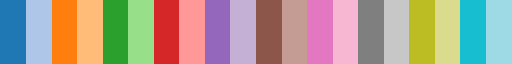

In [30]:
# plt.style.available
# plt.style.use('default')
plt.get_cmap('tab20')

In [31]:
# indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)

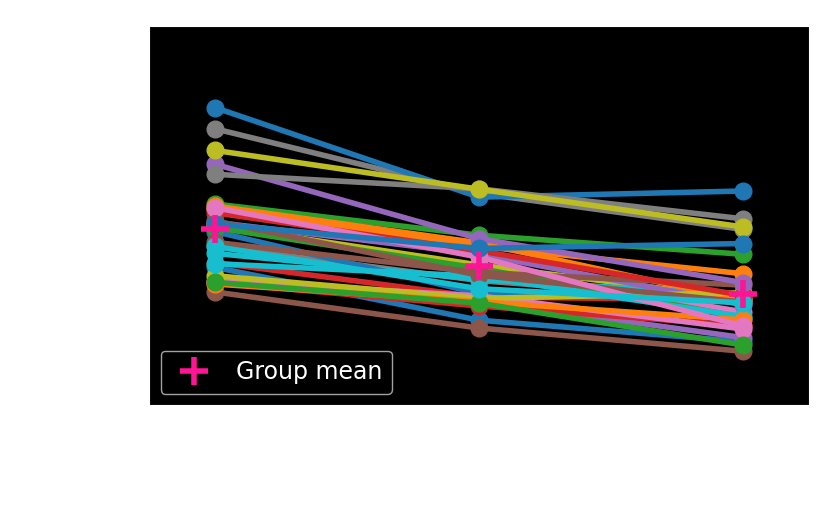

In [32]:
## individual IKI means by BF (correct trials only)
plt.rcParams['font.size'] = '30'
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)['Avg IKI'], 
     indiv_means(corr_trials_bybg, 'bigram', typ.medbf)['Avg IKI'],
     indiv_means(corr_trials_bybg, 'bigram', typ.highbf)['Avg IKI'])
means = (np.mean(indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)['Avg IKI']),
         np.mean(indiv_means(corr_trials_bybg, 'bigram', typ.medbf)['Avg IKI']),
         np.mean(indiv_means(corr_trials_bybg, 'bigram', typ.highbf)['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

### Creates unique range of colors dependent on number of lines plotted -- useful if you plot more than 20 participants in one graph
## Current color map has 20 unique colors
# color = cm.rainbow(np.linspace(0, 1, len(ID_list)))
# for i, c in zip(range(len(ID_list)), color):
#     plt.plot(x, [l[i] for l in D], '.-', linewidth = 2.5, ms = 20, c = c)

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([0.04, 0.4])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Individual Avg. IKIs (s)", labelpad=15)
plt.title("")
plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('mean_ikis_corr.png', dpi=300)
plt.show()

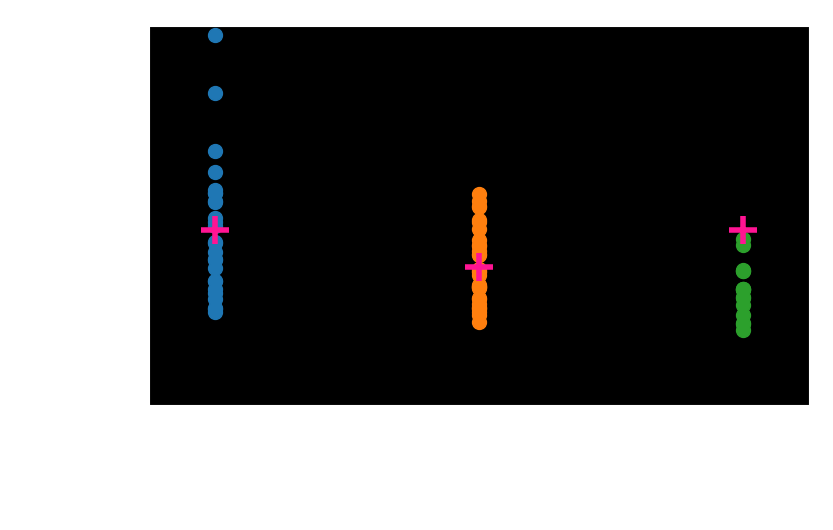

In [33]:
## bigram IKI means across individuals by BF (correct trials only)
plt.rcParams['font.size'] = '30'
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

# D = (bg_stats[bg_stats.bf_type == 'high']['Mean'],
#      bg_stats[bg_stats.bf_type == 'med']['Mean'],
#      bg_stats[bg_stats.bf_type == 'low']['Mean'])

D2 = list(bg_stats[bg_stats.bf_type == 'low']['Mean'])
x2 = [2]*len(D2)

D4 = list(bg_stats[bg_stats.bf_type == 'med']['Mean'])
x4 = [4]*len(D4)

D6 = list(bg_stats[bg_stats.bf_type == 'high']['Mean'])
x6 = [6]*len(D6)

# mean1 = np.mean(bg_stats[bg_stats.bf_type == 'high']['Mean'])

means = (np.mean(bg_stats[bg_stats.bf_type == 'low']['Mean']),
         np.mean(bg_stats[bg_stats.bf_type == 'med']['Mean']),
         np.mean(bg_stats[bg_stats.bf_type == 'low']['Mean']))
xmean = (2, 4, 6)
         
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x2, D2, '.', ms = 20)
ax.plot(x4, D4, '.', ms = 20)
ax.plot(x6, D6, '.', ms = 20)
    
ax.plot(xmean, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([0.04, 0.4])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks([2, 4, 6], ['Low BF', 'Med BF', 'High BF'])
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Avg. IKIs per Bigram (s)", labelpad=15)
plt.title("")
# plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('mean_ikis_corr.png', dpi=300)
plt.show()

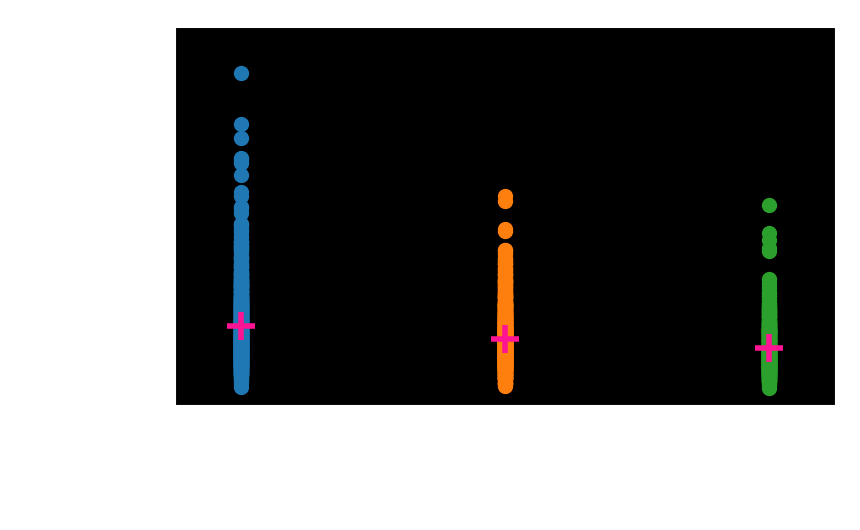

In [34]:
## all bigram IKI means for each individual by BF (correct trials only)
plt.rcParams['font.size'] = '30'
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

D2 = list(ikis[ikis.bf_type == 'Low']['mean'])
x2 = [2]*len(D2)


D4 = list(ikis[ikis.bf_type == 'Med']['mean'])
x4 = [4]*len(D4)

D6 = list(ikis[ikis.bf_type == 'High']['mean'])
x6 = [6]*len(D6)

means = (np.mean(ikis[ikis.bf_type == 'Low']['mean']),
         np.mean(ikis[ikis.bf_type == 'Med']['mean']),
         np.mean(ikis[ikis.bf_type == 'High']['mean']))
xmean = (2, 4, 6)
         
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x2, D2, '.', ms = 20)
ax.plot(x4, D4, '.', ms = 20)
ax.plot(x6, D6, '.', ms = 20)
    
ax.plot(xmean, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([0, 1])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks([2, 4, 6], ['Low BF', 'Med BF', 'High BF'])
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Avg. IKIs per Bigram (s)", labelpad=15)
plt.title("")
# plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('mean_ikis_corr.png', dpi=300)
plt.show()

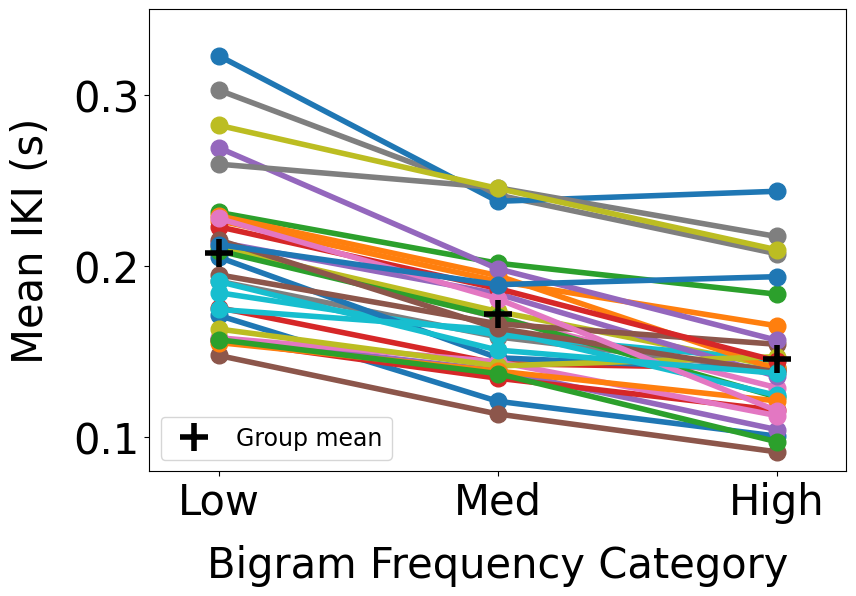

In [35]:
## individual IKI means by BF (correct trials only) PRINT VERSION IN LIGHT MODE
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)['Avg IKI'], 
     indiv_means(corr_trials_bybg, 'bigram', typ.medbf)['Avg IKI'],
     indiv_means(corr_trials_bybg, 'bigram', typ.highbf)['Avg IKI'])
means = (np.mean(indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)['Avg IKI']),
         np.mean(indiv_means(corr_trials_bybg, 'bigram', typ.medbf)['Avg IKI']),
         np.mean(indiv_means(corr_trials_bybg, 'bigram', typ.highbf)['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')
    
plt.xlim([1.5, 6.5])
plt.ylim([0.08, 0.35])
plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Mean IKI (s)", labelpad=15)
plt.title("")
plt.legend(fontsize = 17, loc="lower left")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('indiv_mean_ikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

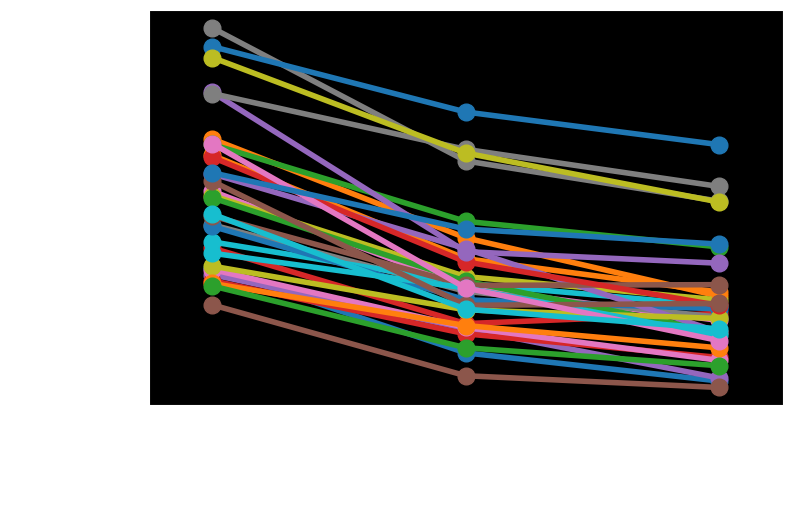

In [36]:
## individual IKI means by AVG BF category (correct trials only)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_means(corr_trials_bybg, 'string', typ.avg_lowbf)['Avg IKI'], 
     indiv_means(corr_trials_bybg, 'string', typ.avg_medbf)['Avg IKI'], 
     indiv_means(corr_trials_bybg, 'string', typ.avg_highbf)['Avg IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Average Bigram Frequency Category", labelpad=15)
plt.ylabel("Individual Avg. IKI (s)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis_bybf.png', dpi=300, transparent = True)
plt.show()

<Figure size 640x480 with 0 Axes>

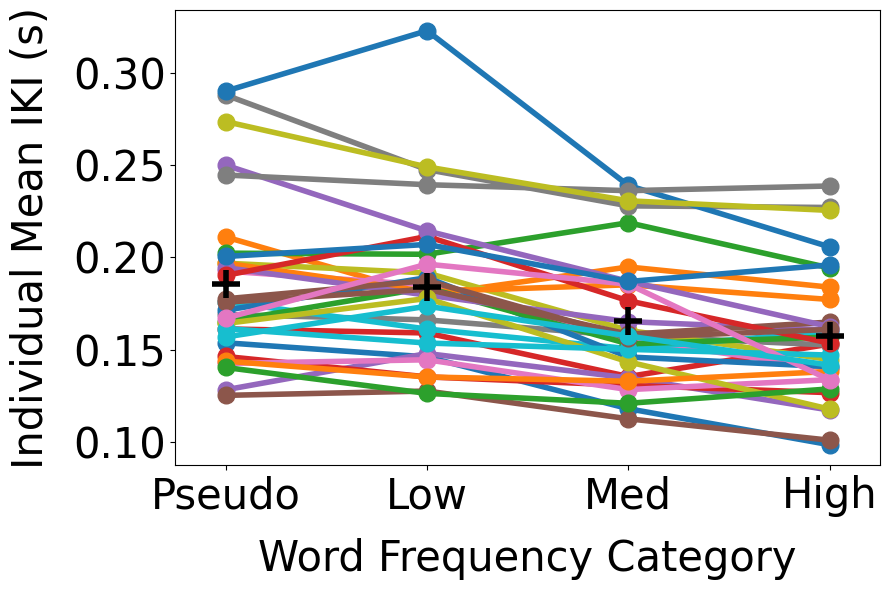

In [37]:
## individual IKI means by WF category
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = [2, 4, 6, 8]
D = (indiv_means(corr_trials_bybg, 'string', typ.pseudo)['Avg IKI'], 
     indiv_means(corr_trials_bybg, 'string', typ.lowwf)['Avg IKI'], 
     indiv_means(corr_trials_bybg, 'string', typ.medwf)['Avg IKI'],
    indiv_means(corr_trials_bybg, 'string', typ.highwf)['Avg IKI'])

means = (np.mean(indiv_means(corr_trials_bybg, 'string', typ.pseudo)['Avg IKI']), 
         np.mean(indiv_means(corr_trials_bybg, 'string', typ.lowwf)['Avg IKI']), 
         np.mean(indiv_means(corr_trials_bybg, 'string', typ.medwf)['Avg IKI']),
        np.mean(indiv_means(corr_trials_bybg, 'string', typ.highwf)['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize = 30)
plt.ylabel("Individual Mean IKI (s)", labelpad=15, fontsize = 30)
plt.title("")
# plt.legend(loc="best")

fig.tight_layout()
# plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()

## CV GRAPHS
___

In [38]:
## making dataframe of cv values
cv_df = pd.concat(
    [indiv_avgcvs(all_bigrams, 'bigram', typ.highbf),
    indiv_avgcvs(all_bigrams, 'bigram', typ.medbf).rename(columns = {'Avg CV IKI': 'meanCV_med'})['meanCV_med'],
    indiv_avgcvs(all_bigrams, 'bigram', typ.lowbf).rename(columns = {'Avg CV IKI': 'meanCV_low'})['meanCV_low']], 
    axis = 1)
cv_df = cv_df.rename(columns = {cv_df.columns[1]: 'meanCV_high'})
# cv_df

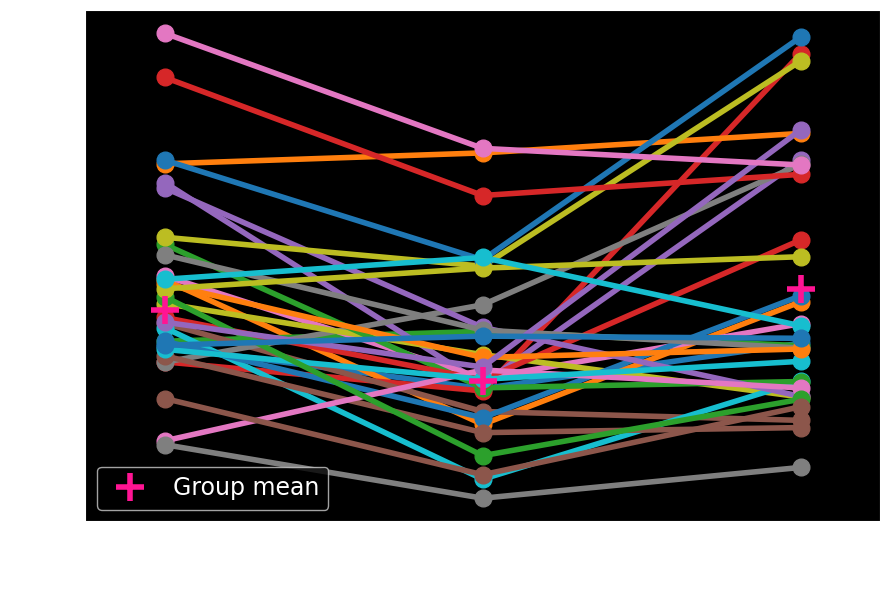

In [39]:
## Individual MEAN CV IKIs sorted by BF (correct trials)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_avgcvs(corr_trials_bybg, 'bigram', lowbf_norep)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'bigram', medbf_norep)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'bigram', typ.highbf)['Avg CV IKI'])
means = (np.mean(indiv_avgcvs(corr_trials_bybg, 'bigram', typ.lowbf)['Avg CV IKI']), 
         np.mean(indiv_avgcvs(corr_trials_bybg, 'bigram', typ.medbf)['Avg CV IKI']), 
         np.mean(indiv_avgcvs(corr_trials_bybg, 'bigram', typ.highbf)['Avg CV IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

# plt.ylim([0.1, 0.5])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Individual Avg. CV IKI (%)", labelpad=15)
plt.title("")
plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('cvikis_bybf_corr.png', dpi=300, transparent = True)
plt.show()

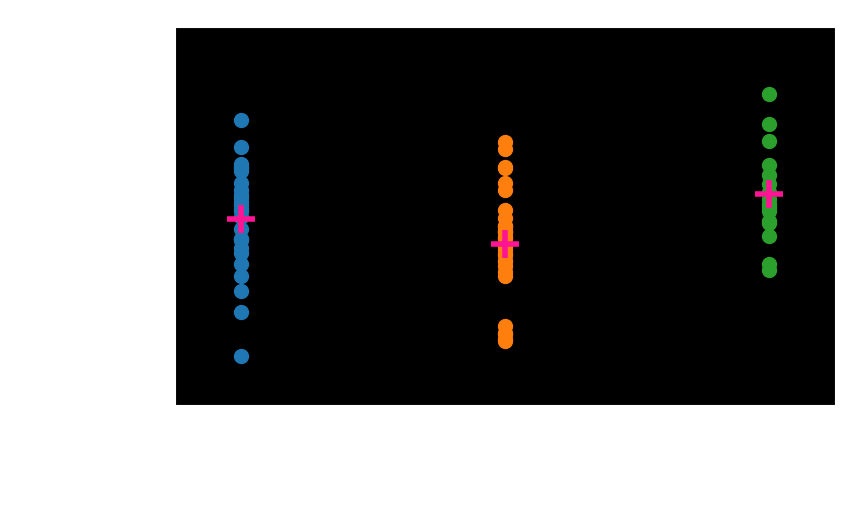

In [40]:
## bigram IKI CVs across individuals by BF (correct trials only)
plt.rcParams['font.size'] = '30'
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

# D = (bg_stats[bg_stats.bf_type == 'high']['Mean'],
#      bg_stats[bg_stats.bf_type == 'med']['Mean'],
#      bg_stats[bg_stats.bf_type == 'low']['Mean'])

D2 = list(bg_stats[bg_stats.bf_type == 'low']['CV'])
x2 = [2]*len(D2)

D4 = list(bg_stats[bg_stats.bf_type == 'med']['CV'])
x4 = [4]*len(D4)

D6 = list(bg_stats[bg_stats.bf_type == 'high']['CV'])
x6 = [6]*len(D6)

# mean1 = np.mean(bg_stats[bg_stats.bf_type == 'high']['Mean'])

means = (np.mean(bg_stats[bg_stats.bf_type == 'low']['CV']),
         np.mean(bg_stats[bg_stats.bf_type == 'med']['CV']),
         np.mean(bg_stats[bg_stats.bf_type == 'high']['CV']))
xmean = (2, 4, 6)
         
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x2, D2, '.', ms = 20)
ax.plot(x4, D4, '.', ms = 20)
ax.plot(x6, D6, '.', ms = 20)
    
ax.plot(xmean, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([0, 1])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks([2, 4, 6], ['Low BF', 'Med BF', 'High BF'])
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("IKI CVs per Bigram (s)", labelpad=15)
plt.title("")
# plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('mean_ikis_corr.png', dpi=300)
plt.show()

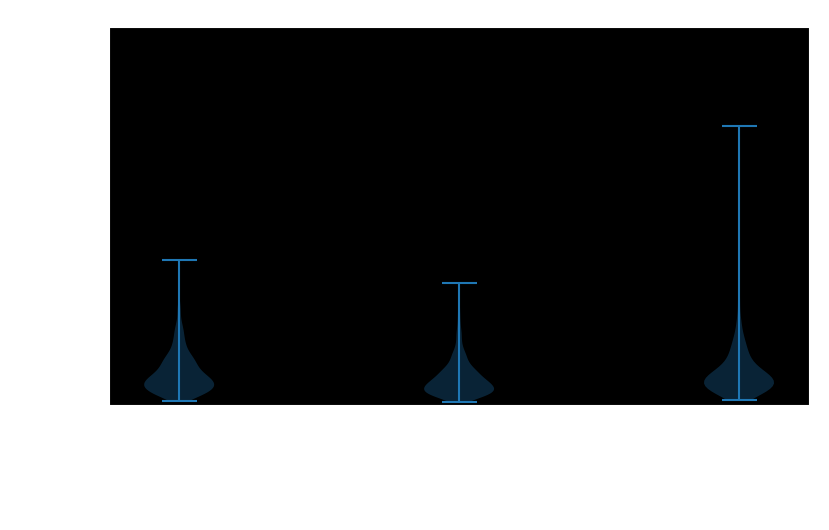

In [41]:
## all bigram IKI CVs for each individual by BF (correct trials only)
plt.rcParams['font.size'] = '30'
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

D2 = list(cvs[cvs.bf_type == 'Low']['variation'])
x2 = [2]*len(D2)


D4 = list(cvs[cvs.bf_type == 'Med']['variation'])
x4 = [4]*len(D4)

D6 = list(cvs[cvs.bf_type == 'High']['variation'])
x6 = [6]*len(D6)

means = (np.mean(cvs[cvs.bf_type == 'Low']['variation']),
         np.mean(cvs[cvs.bf_type == 'Med']['variation']),
         np.mean(cvs[cvs.bf_type == 'High']['variation']))
xmean = (2, 4, 6)
         
fig, ax = plt.subplots(figsize=(9, 6))

ax.violinplot([D2, D4, D6], [2, 4, 6])

# ax.plot(x2, D2, '.', ms = 20)
# ax.plot(x4, D4, '.', ms = 20)
# ax.plot(x6, D6, '.', ms = 20)
    
# ax.plot(xmean, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([0, 3])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks([2, 4, 6], ['Low BF', 'Med BF', 'High BF'])
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("IKI CVs per Bigram (s)", labelpad=15)
plt.title("")
# plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('mean_ikis_corr.png', dpi=300)
plt.show()

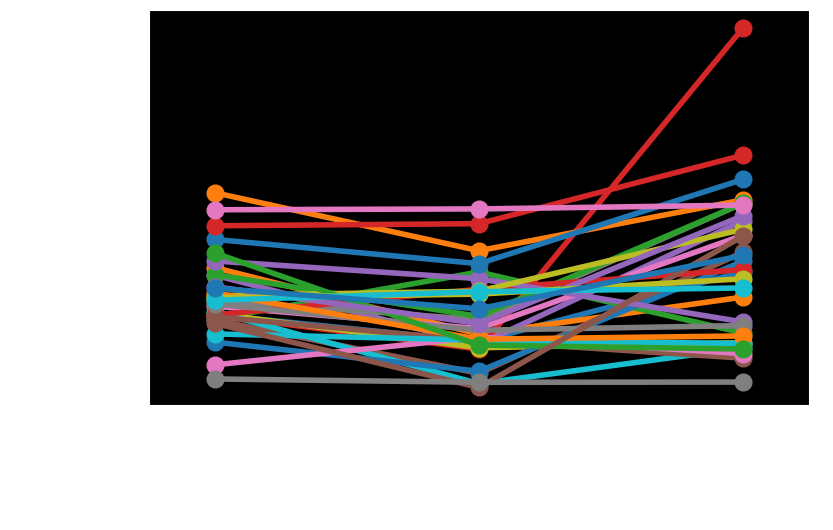

In [42]:
## Inividual MEAN CV IKIs by BF (all trials)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_avgcvs(all_bigrams, 'bigram', typ.lowbf)['Avg CV IKI'], 
     indiv_avgcvs(all_bigrams, 'bigram', typ.medbf)['Avg CV IKI'], 
     indiv_avgcvs(all_bigrams, 'bigram', typ.highbf)['Avg CV IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Individual Avg. CV IKIs (%)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()

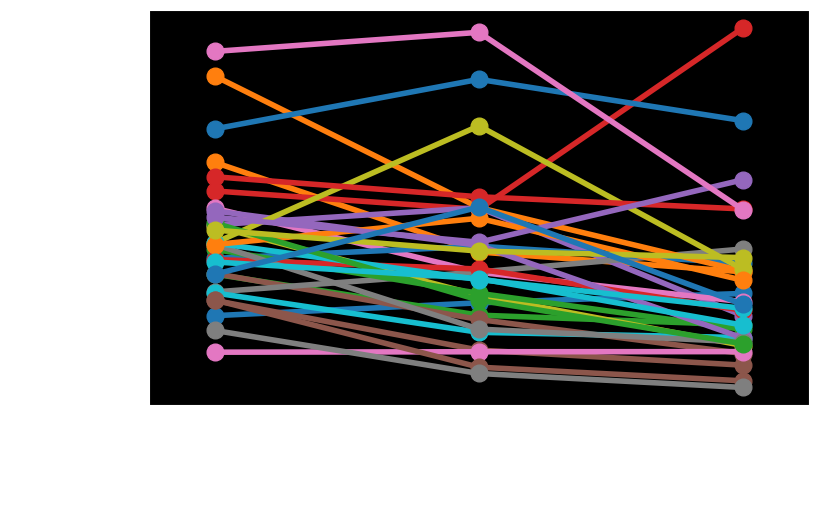

In [43]:
## Individual MEAN CV IKI by AVG BF category (correct trials only)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_avgcvs(corr_trials_bybg, 'string', typ.avg_lowbf)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'string', typ.avg_medbf)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'string', typ.avg_highbf)['Avg CV IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Individual Avg. CV IKIs (%)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_cvikis_bybf.png', dpi=300, transparent = True)
plt.show()

In [44]:
# individual MEAN CV IKIs by AVG BF category (tight_bgs df)
# plt.rc('text', color='white')
# plt.rc('axes', labelcolor='white')
# plt.rc('xtick', color='white')
# plt.rc('ytick', color='white')

# x = [2, 4, 6]
# D = (indiv_avgcvs(tight_bgs, 'string', typ.avg_lowbf)['Avg CV IKI'], 
#      indiv_avgcvs(tight_bgs, 'string', typ.avg_medbf)['Avg CV IKI'], 
#      indiv_avgcvs(tight_bgs, 'string', typ.avg_highbf)['Avg CV IKI'])

# fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

# plt.xlim([1.5, 6.5])
# # plt.xticks(x, ('', '', ''))
# plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
# plt.xlabel("Average Bigram Frequency Category", labelpad=15)
# plt.ylabel("Individual Avg. CV IKIs (%)", labelpad=15)
# plt.title("")
# # plt.legend(loc="best")

# ax.set_facecolor('black')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('white')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('white')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('white')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('white')

# fig.tight_layout()
# # plt.savefig('indiv_mean_ikis.png', dpi=300)
# plt.show()

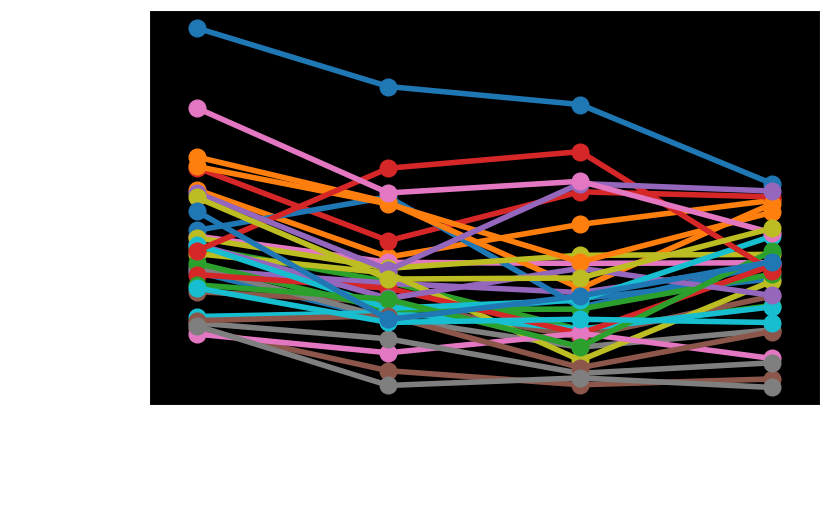

In [45]:
# individual avg CV IKI by WF category (can also change dataframe here)
x = [2, 4, 6, 8]
D = (indiv_avgcvs(tight_bgs, 'string', typ.pseudo)['Avg CV IKI'], 
     indiv_avgcvs(tight_bgs, 'string', typ.lowwf)['Avg CV IKI'], 
     indiv_avgcvs(tight_bgs, 'string', typ.medwf)['Avg CV IKI'],
     indiv_avgcvs(tight_bgs, 'string', typ.highwf)['Avg CV IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'))
plt.xlabel("Word Frequency Category", labelpad=15)

plt.ylabel("Individual Avg. CV IKIs (%)", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()

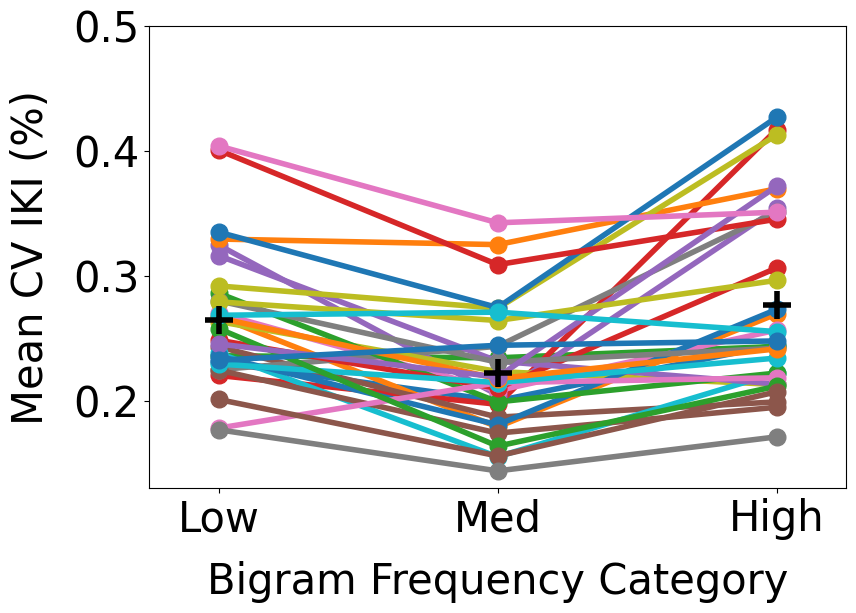

In [46]:
## using bigrams sorted by BF (correct trials) -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_avgcvs(corr_trials_bybg, 'bigram', typ.lowbf)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'bigram', typ.medbf)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'bigram', typ.highbf)['Avg CV IKI'])
means = (np.mean(indiv_avgcvs(corr_trials_bybg, 'bigram', typ.lowbf)['Avg CV IKI']), 
         np.mean(indiv_avgcvs(corr_trials_bybg, 'bigram', typ.medbf)['Avg CV IKI']), 
         np.mean(indiv_avgcvs(corr_trials_bybg, 'bigram', typ.highbf)['Avg CV IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.13, 0.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Mean CV IKI (%)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('indiv_cvikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

## SD GRAPHS
___

In [47]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     # print(typ.all_bigrams)
    
# repeats = ['ll', 'oo', 'pp', 'dd', 'kk']

# noreps

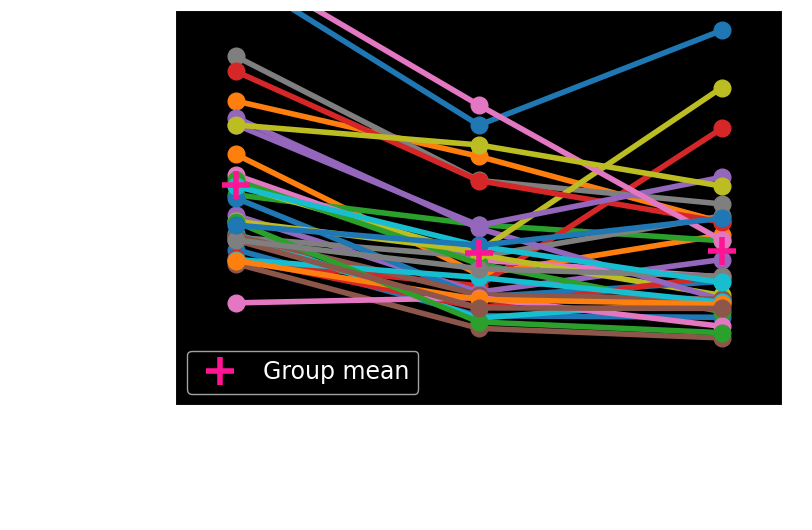

In [48]:
## individual MEAN SD IKI by BF (correct trials)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_avgsds(corr_trials_bybg, 'bigram', lowbf_norep)['Avg SD IKI'], 
     indiv_avgsds(corr_trials_bybg, 'bigram', medbf_norep)['Avg SD IKI'],
     indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)['Avg SD IKI'])
means = (np.mean(indiv_avgsds(corr_trials_bybg, 'bigram', lowbf_norep)['Avg SD IKI']), 
         np.mean(indiv_avgsds(corr_trials_bybg, 'bigram', medbf_norep)['Avg SD IKI']),
         np.mean(indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)['Avg SD IKI']))

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_facecolor('black')

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([0, 0.12])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Indiv. Avg. STD IKI (s)", labelpad=15)

plt.title("")
plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('meansds_bybf_corr.png', dpi=300, transparent = True)
plt.show()

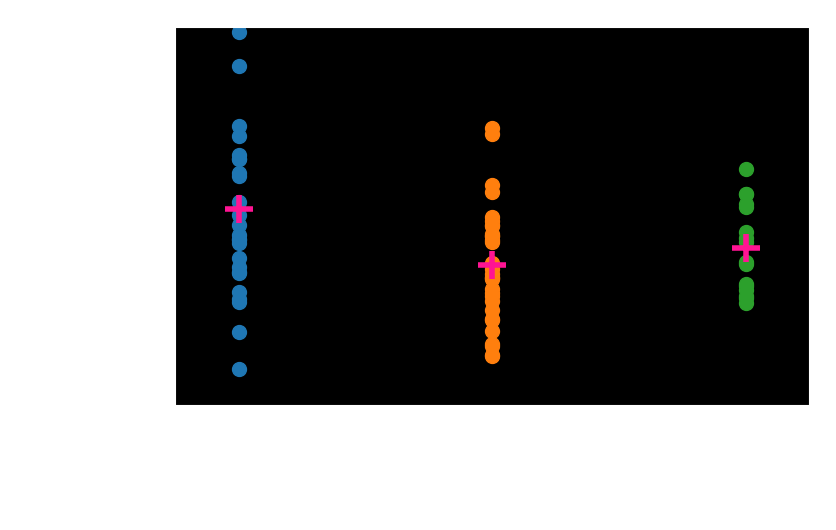

In [49]:
## bigram IKI CVs across individuals by BF (correct trials only)
plt.rcParams['font.size'] = '30'
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

# D = (bg_stats[bg_stats.bf_type == 'high']['Mean'],
#      bg_stats[bg_stats.bf_type == 'med']['Mean'],
#      bg_stats[bg_stats.bf_type == 'low']['Mean'])

D2 = list(bg_stats[bg_stats.bf_type == 'low']['SD'])
x2 = [2]*len(D2)

D4 = list(bg_stats[bg_stats.bf_type == 'med']['SD'])
x4 = [4]*len(D4)

D6 = list(bg_stats[bg_stats.bf_type == 'high']['SD'])
x6 = [6]*len(D6)

# mean1 = np.mean(bg_stats[bg_stats.bf_type == 'high']['Mean'])

means = (np.mean(bg_stats[bg_stats.bf_type == 'low']['SD']),
         np.mean(bg_stats[bg_stats.bf_type == 'med']['SD']),
         np.mean(bg_stats[bg_stats.bf_type == 'high']['SD']))
xmean = (2, 4, 6)
         
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x2, D2, '.', ms = 20)
ax.plot(x4, D4, '.', ms = 20)
ax.plot(x6, D6, '.', ms = 20)
    
ax.plot(xmean, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([0, 0.2])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks([2, 4, 6], ['Low BF', 'Med BF', 'High BF'])
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("IKI SDs per Bigram (s)", labelpad=15)
plt.title("")
# plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('mean_ikis_corr.png', dpi=300)
plt.show()

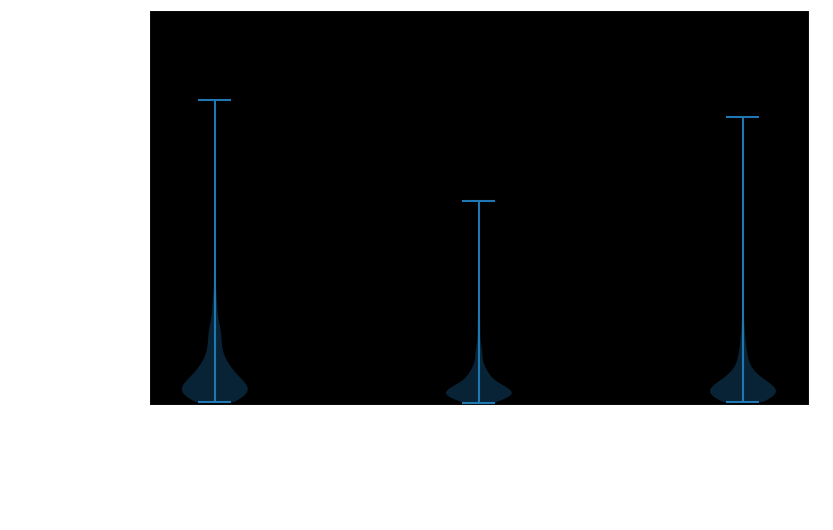

In [50]:
## all bigram IKI SDs for each individual by BF (correct trials only)
plt.rcParams['font.size'] = '30'
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

# D2 = list(sds[sds.bf_type == 'Low']['std'])
# x2 = [2]*len(D2)

# D4 = list(sds[sds.bf_type == 'Med']['std'])
# x4 = [4]*len(D4)

# D6 = list(sds[sds.bf_type == 'High']['std'])
# x6 = [6]*len(D6)

# means = (np.mean(sds[sds.bf_type == 'Low']['std']),
#          np.mean(sds[sds.bf_type == 'Med']['std']),
#          np.mean(sds[sds.bf_type == 'High']['std']))
# xmean = (2, 4, 6)
         
fig, ax = plt.subplots(figsize=(9, 6))

# ax.plot(x2, D2, '.', ms = 20)
# ax.plot(x4, D4, '.', ms = 20)
# ax.plot(x6, D6, '.', ms = 20)
    
# ax.plot(xmean, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

D = [list(sds[sds.bf_type == 'Low']['std']),
     list(sds[sds.bf_type == 'Med']['std']),
     list(sds[sds.bf_type == 'High']['std'])]
x = (2, 4, 6)

ax.violinplot(D, x)

plt.ylim([0, 0.7])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks([2, 4, 6], ['Low BF', 'Med BF', 'High BF'])
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("IKI SDs per Bigram (s)", labelpad=15)
plt.title("")
# plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('mean_ikis_corr.png', dpi=300)
plt.show()

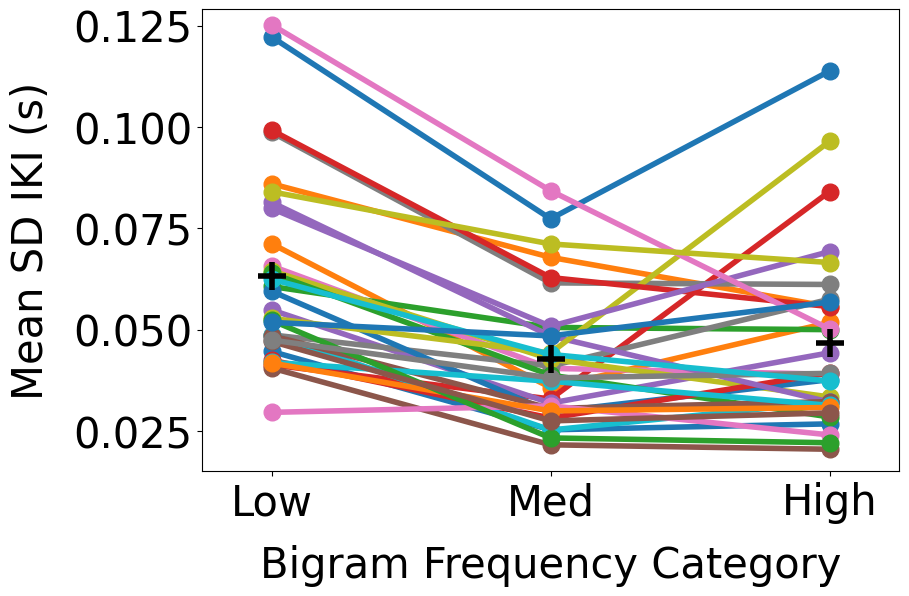

In [51]:
## individual MEAN SD IKI by BF (correct trials) -- PRINT VERSION IN LIGHT MODE
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_avgsds(corr_trials_bybg, 'bigram', typ.lowbf)['Avg SD IKI'], 
     indiv_avgsds(corr_trials_bybg, 'bigram', typ.medbf)['Avg SD IKI'],
     indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)['Avg SD IKI'])
means = (np.mean(indiv_avgsds(corr_trials_bybg, 'bigram', typ.lowbf)['Avg SD IKI']), 
         np.mean(indiv_avgsds(corr_trials_bybg, 'bigram', typ.medbf)['Avg SD IKI']),
         np.mean(indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)['Avg SD IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.015, 0.129])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Mean SD IKI (s)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('indiv_avgsds_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

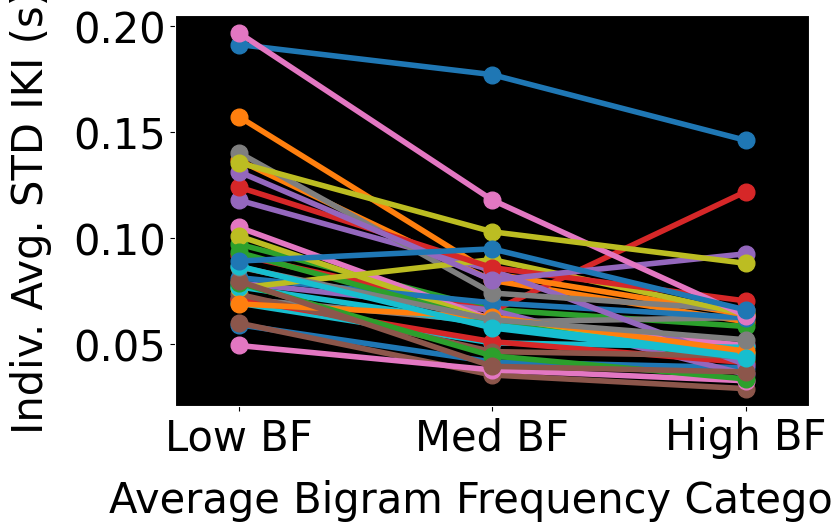

In [52]:
## individual MEAN SD IKI by AVG BF (correct trials)
plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_avgsds(corr_trials_bybg, 'string', typ.avg_lowbf)['Avg SD IKI'], 
     indiv_avgsds(corr_trials_bybg, 'string', typ.avg_medbf)['Avg SD IKI'],
     indiv_avgsds(corr_trials_bybg, 'string', typ.avg_highbf)['Avg SD IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Average Bigram Frequency Category", labelpad=15)
plt.ylabel("Indiv. Avg. STD IKI (s)", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_avgsds.png', dpi=300)
plt.show()

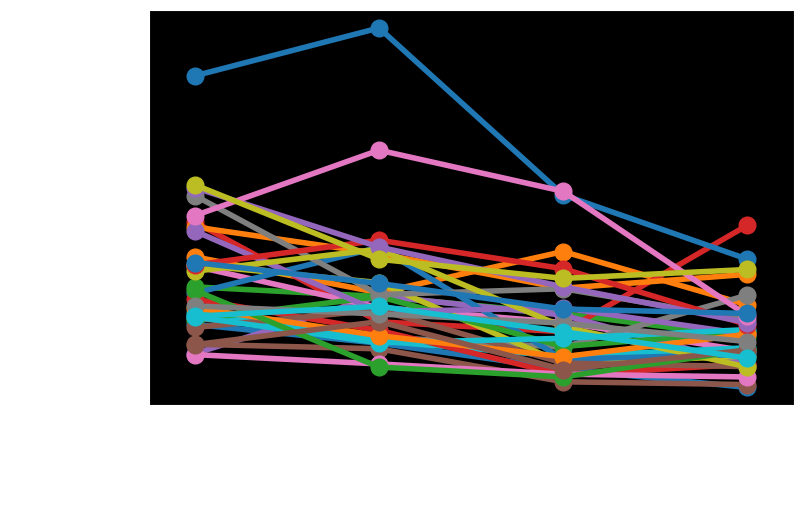

In [53]:
## individual MEAN SD IKI by WF (correct trials)
plt.rcParams['font.size'] = '30'
x = [2, 4, 6, 8]
D = (indiv_avgsds(corr_trials_bybg, 'string', typ.pseudo)['Avg SD IKI'], 
     indiv_avgsds(corr_trials_bybg, 'string', typ.lowwf)['Avg SD IKI'],
     indiv_avgsds(corr_trials_bybg, 'string', typ.medwf)['Avg SD IKI'],
     indiv_avgsds(corr_trials_bybg, 'string', typ.highwf)['Avg SD IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'))
plt.xlabel("Word Frequency Category", labelpad=15)
plt.ylabel("Indiv. Avg. STD IKI (s)", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('indiv_avgsds.png', dpi=300)
plt.show()

## BG FREQ GRAPHS
___

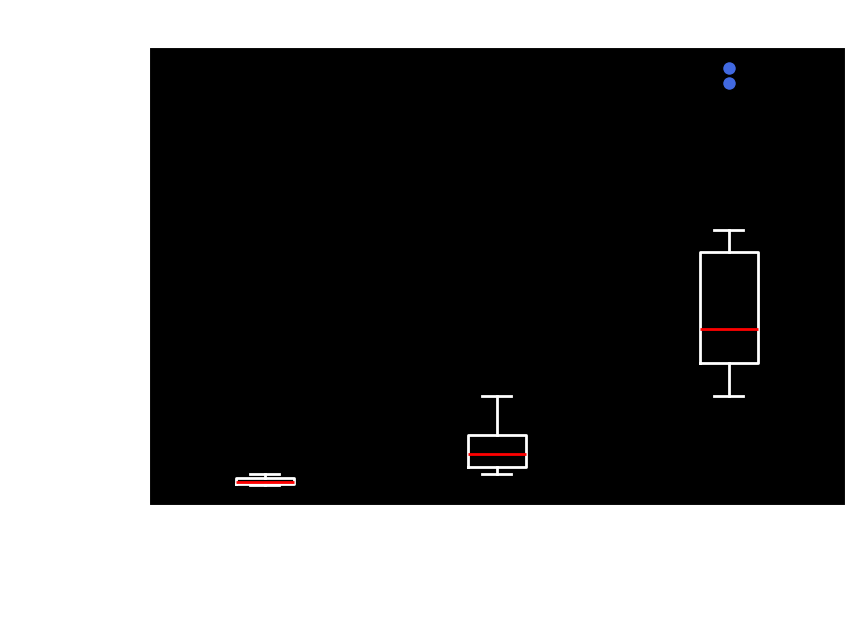

In [54]:
## plotting BF distribution of data set
high_bgs = typ.bg_freqs.loc[0:15]
med_bgs = typ.bg_freqs.loc[15:46]
low_bgs = typ.bg_freqs.loc[46:69]

x = [2, 4, 6]
D = (low_bgs['Frequency'], med_bgs['Frequency'], high_bgs['Frequency'])

fig, ax = plt.subplots(figsize=(9.25, 7))

boxprops = dict(linestyle='-', linewidth=2, color = 'white')
whiskerprops = dict(linewidth=2, color = 'white')
capprops = dict(linewidth=2, color = 'white')
flierprops = dict(markerfacecolor='royalblue', markersize=10)
medianprops = dict(linewidth=2, color='red')

ax.boxplot(D, positions=x, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
          flierprops=flierprops, medianprops=medianprops)

plt.xlim([1, 7])
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)

# plt.ylim([0, 0.8])
plt.ylabel("Bigram Frequency", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('bf.png', dpi=300)
plt.show()

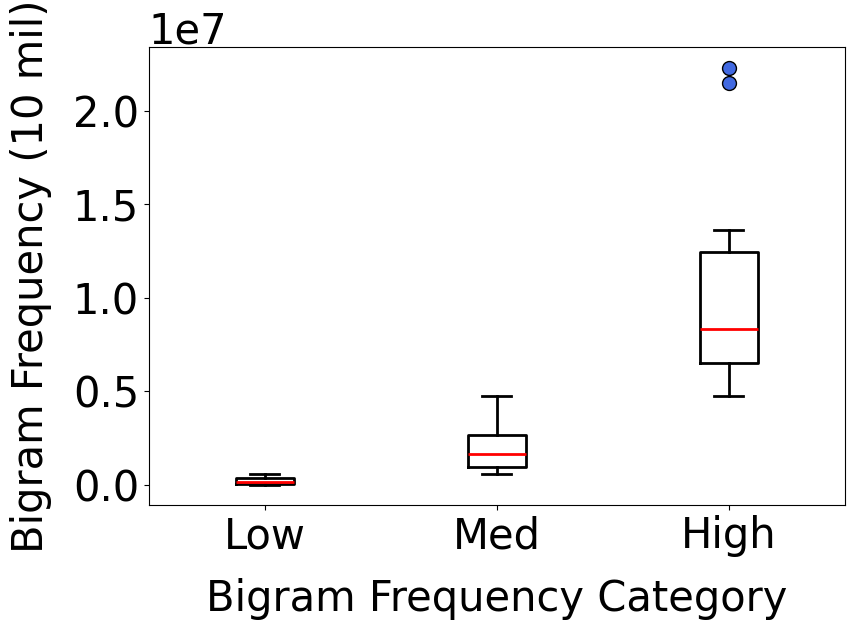

In [55]:
## plotting BF distribution of data set -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (low_bgs['Frequency'], med_bgs['Frequency'], high_bgs['Frequency'])

fig, ax = plt.subplots(figsize=(9.25, 7))

boxprops = dict(linestyle='-', linewidth=2, color = 'black')
whiskerprops = dict(linewidth=2, color = 'black')
capprops = dict(linewidth=2, color = 'black')
flierprops = dict(markerfacecolor='royalblue', markersize=10)
medianprops = dict(linewidth=2, color='red')

ax.boxplot(D, positions=x, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
          flierprops=flierprops, medianprops=medianprops)

plt.xlim([1, 7])
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
# plt.ylim([0, 0.8])
plt.ylabel("Bigram Frequency (10 mil)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

fig.tight_layout()
plt.savefig('wf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none')
plt.show()

## ERROR GRAPHS
___

In [56]:
indiv_error(incorr_bgs, 'bigram', typ.medbf)

sID  Total Error
0    s09            0
1   s175            0
2   s176            0
3   s178            0
4   s180            0
5   s181            0
6   s182            0
7   s183            0
8   s189            0
9   s190            0
10  s198            0
11   s20            0
12  s207            0
13  s209            0
14  s210            0
15  s212            0
16  s217            0
17  s219            0
18  s224            0
19  s254            0
20  s261            0
21  s262            0
22  s263            0
23  s267            0
24  s276            0
25  s278            0
26  s279            0
27  s282            0
28  s283            0
29  s286            0

(0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
Name: Total Error, dtype: int64, 0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
Name: Total Error, dtype: int64, 0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
Name: Total Error, dtype: int64)


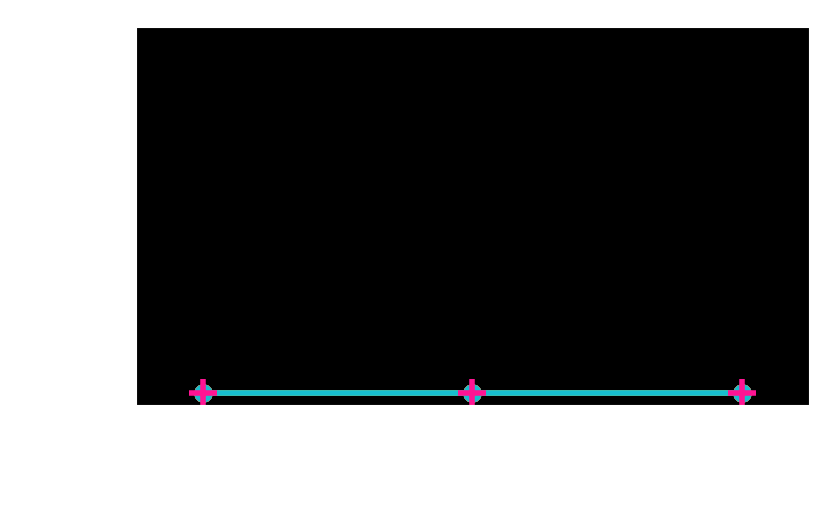

In [57]:
## Individual total trial error by bigram BF
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_error(incorr_bgs, 'bigram', typ.lowbf)['Total Error'], 
     indiv_error(incorr_bgs, 'bigram', typ.medbf)['Total Error'],
     indiv_error(incorr_bgs, 'bigram', typ.highbf)['Total Error'])

print(D)
means = (np.mean(indiv_error(incorr_bgs, 'bigram', typ.lowbf)['Total Error']), 
         np.mean(indiv_error(incorr_bgs, 'bigram', typ.medbf)['Total Error']),
         np.mean(indiv_error(incorr_bgs, 'bigram', typ.highbf)['Total Error']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([-1, 30])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Indiv. Total Error", labelpad=15)

plt.title("")
# plt.legend(fontsize = 17, loc="best", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('meanerr_bybf.png', dpi=300)
plt.show()

In [58]:
## Individual total trial error by AVG BF
# plt.rcParams['font.size'] = '30'
# x = [2, 4, 6]
# D = (indiv_error(incorr_trials, 'string', typ.avg_lowbf)['Total Error'], 
#      indiv_error(incorr_trials, 'string', typ.avg_medbf)['Total Error'],
#      indiv_error(incorr_trials, 'string', typ.avg_highbf)['Total Error'])

# fig, ax = plt.subplots(figsize=(9, 6))

# ax.plot(x, D, '.-', linewidth = 2.5, ms = 20)

# plt.xlim([1.5, 6.5])
# # plt.xticks(x, ('', '', ''))
# plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
# plt.xlabel("Average Bigram Frequency Category", labelpad=15)
# plt.ylabel("Indiv. Total Error", labelpad=15)

# plt.title("")
# # plt.legend(loc="best")

# ax.set_facecolor('black')
# plt.rc('text', color='white')
# plt.rc('axes', labelcolor='white')
# plt.rc('xtick', color='white')
# plt.rc('ytick', color='white')

# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('white')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('white')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('white')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('white')

# fig.tight_layout()
# plt.savefig('indiv_avgsds.png', dpi=300)
# plt.show()

In [59]:
## Individual total trial error by WF
# plt.rcParams['font.size'] = '30'
# x = [2, 4, 6, 8]

# D = (indiv_error(incorr_trials, 'string', typ.pseudo)['Total Error'],
#      indiv_error(incorr_trials, 'string', typ.lowwf)['Total Error'],
#      indiv_error(incorr_trials, 'string', typ.medwf)['Total Error'],
#      indiv_error(incorr_trials, 'string', typ.highwf)['Total Error'])

# fig, ax = plt.subplots(figsize=(9, 6))

# print([len(x) for x in D])
# ax.plot(x, D, '.-', linewidth = 2.5, ms = 20)

# plt.xlim([1.5, 8.5])
# # plt.xticks(x, ('', '', ''))
# plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'))
# plt.xlabel("Word Frequency Category", labelpad=15)
# plt.ylabel("Indiv. Total Error", labelpad=15)

# plt.title("")
# # plt.legend(loc="best")

# ax.set_facecolor('black')
# plt.rc('text', color='white')
# plt.rc('axes', labelcolor='white')
# plt.rc('xtick', color='white')
# plt.rc('ytick', color='white')

# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('white')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('white')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('white')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('white')

# fig.tight_layout()
# # plt.savefig('indiv_avgsds.png', dpi=300)
# plt.show()

## Onset Delay

In [60]:
## calculating onset delays WF group averages by subject
od = corr_trials[['sID', 'key_resp.rt.1', 'wf_type']]
od_avgs = od.groupby(['sID', 'wf_type']).mean().reset_index()
od_avgs = od_avgs.rename(columns={'key_resp.rt.1' : 'onset_delay'})

## running anova on onset delay averages across WF groups
od_anova = pg.rm_anova(od_avgs, 'onset_delay', 'wf_type', 'sID')
print(od_anova)
pg.pairwise_tukey(od_avgs, 'onset_delay', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  wf_type      3     90  79.125926  3.787280e-25  0.140117  0.632724


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  highwf   lowwf  0.768375  0.825770 -0.057395  0.037157 -1.544666  0.414297   
1  highwf   medwf  0.768375  0.797925 -0.029550  0.037157 -0.795287  0.856457   
2  highwf  pseudo  0.768375  0.923059 -0.154684  0.037157 -4.163001  0.000343   
3   lowwf   medwf  0.825770  0.797925  0.027845  0.037157  0.749379  0.876768   
4   lowwf  pseudo  0.825770  0.923059 -0.097289  0.037157 -2.618335  0.048380   
5   medwf  pseudo  0.797925  0.923059 -0.125134  0.037157 -3.367714  0.005556   

      cohen  
0 -0.421528  
1 -0.234949  
2 -0.994011  
3  0.204258  
4 -0.592295  
5 -0.803390

<Figure size 640x480 with 0 Axes>

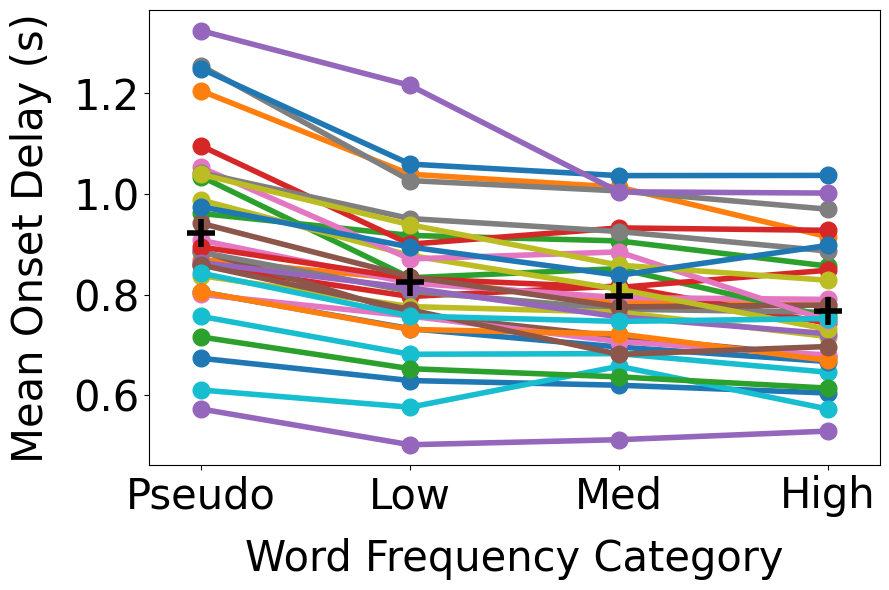

In [61]:
## plotting average onset delays by WF group
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = [2, 4, 6, 8]
D = (od_avgs[od_avgs['wf_type'] == 'pseudo']['onset_delay'],
    od_avgs[od_avgs['wf_type'] == 'lowwf']['onset_delay'],
    od_avgs[od_avgs['wf_type'] == 'medwf']['onset_delay'],
    od_avgs[od_avgs['wf_type'] == 'highwf']['onset_delay'])

means = (np.mean(od_avgs[od_avgs['wf_type'] == 'pseudo']['onset_delay']),
        np.mean(od_avgs[od_avgs['wf_type'] == 'lowwf']['onset_delay']),
        np.mean(od_avgs[od_avgs['wf_type'] == 'medwf']['onset_delay']),
        np.mean(od_avgs[od_avgs['wf_type'] == 'highwf']['onset_delay']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([-1, 30])
plt.xlim([1.5, 8.5])
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize=30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean Onset Delay (s)", labelpad=15, fontsize=30)

plt.title("")
ax.grid(False)

fig.tight_layout()
plt.savefig(save_dir + '/meanod_bywf.png', dpi=300)
plt.show()

In [62]:
## defining function to calculate delta onset delay
    
def deltaod(dataframe):
    # DF = dataframe.query('string == @string')
    dataframe = dataframe.rename(columns = {'key_resp.rt.1':'onset_delay'})
    deltaods = pd.DataFrame(dataframe.groupby(['sID', 'string']).onset_delay.agg(['diff']))
    dataframe.insert(len(dataframe.columns), 'delta_od', deltaods)
    return dataframe

def indiv_meandeltaod(dataframe, sort_type):
    # DF = dataframe[dataframe['wf_type'] == sort_type]
    DF = dataframe[dataframe.string.isin(sort_type)]
    DF = deltaod(DF)
    mean_deltaods = DF.groupby(['sID']).delta_od.agg(['mean']).reset_index()
    mean_deltaods = mean_deltaods.rename(columns={'mean' : 'mean_deltaod'})
    return mean_deltaods

In [63]:
## anova on delta onset delay comparisons across WF

deltaod_anova = pg.rm_anova(deltaod(corr_trials), 'onset_delay', 'wf_type', 'sID')
print(deltaod_anova)
pg.pairwise_tukey(deltaod(corr_trials), 'onset_delay', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  wf_type      3     90  79.125926  3.787280e-25  0.140117  0.632724


A       B   mean(A)   mean(B)      diff        se          T  \
0  highwf   lowwf  0.770332  0.826197 -0.055865  0.006966  -8.020133   
1  highwf   medwf  0.770332  0.797508 -0.027176  0.006947  -3.911991   
2  highwf  pseudo  0.770332  0.922386 -0.152054  0.006957 -21.856065   
3   lowwf   medwf  0.826197  0.797508  0.028689  0.007004   4.096320   
4   lowwf  pseudo  0.826197  0.922386 -0.096190  0.007014 -13.714194   
5   medwf  pseudo  0.797508  0.922386 -0.124879  0.006995 -17.852078   

        p-tukey     cohen  
0  1.984857e-12 -0.280324  
1  5.350623e-04 -0.142398  
2  1.977640e-12 -0.676333  
3  2.478700e-04  0.141066  
4  1.977640e-12 -0.407445  
5  1.977640e-12 -0.546015

<Figure size 640x480 with 0 Axes>

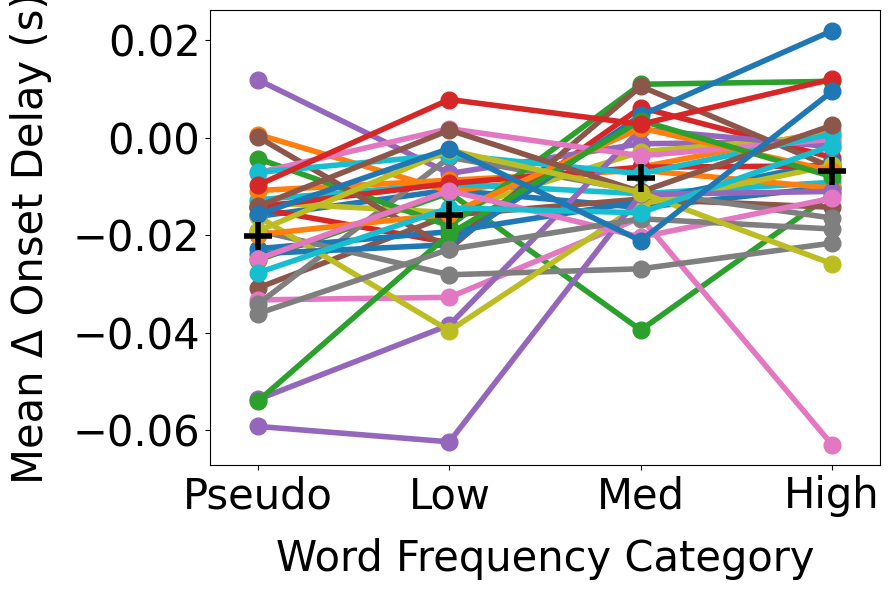

In [64]:
## plotting mean delta onset delays across WF
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')
# plt.rcParams['font.size'] = '30']

x = [2, 4, 6, 8]
D = (indiv_meandeltaod(corr_trials, typ.pseudo)['mean_deltaod'],
    indiv_meandeltaod(corr_trials, typ.lowwf)['mean_deltaod'],
    indiv_meandeltaod(corr_trials, typ.medwf)['mean_deltaod'],
    indiv_meandeltaod(corr_trials, typ.highwf)['mean_deltaod'])

means = (np.mean(indiv_meandeltaod(corr_trials, typ.pseudo)['mean_deltaod']),
        np.mean(indiv_meandeltaod(corr_trials, typ.lowwf)['mean_deltaod']),
        np.mean(indiv_meandeltaod(corr_trials, typ.medwf)['mean_deltaod']),
        np.mean(indiv_meandeltaod(corr_trials, typ.highwf)['mean_deltaod']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([-1, 30])
plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize = 30)
plt.ylabel("Mean Δ Onset Delay (s)", labelpad=15, fontsize = 30)

plt.title("")

fig.tight_layout()
plt.savefig(save_dir + '/meandeltaod_bywf.png', dpi=300)
plt.show()

In [65]:
pseudo_only = corr_trials[corr_trials['wf_type'] == 'pseudo'].rename(columns = {'key_resp.rt.1':'onset_delay'})
pseudo_ods = pseudo_only.groupby(['sID', 'rep_num']).onset_delay.agg(['mean']).reset_index()

<Figure size 640x480 with 0 Axes>

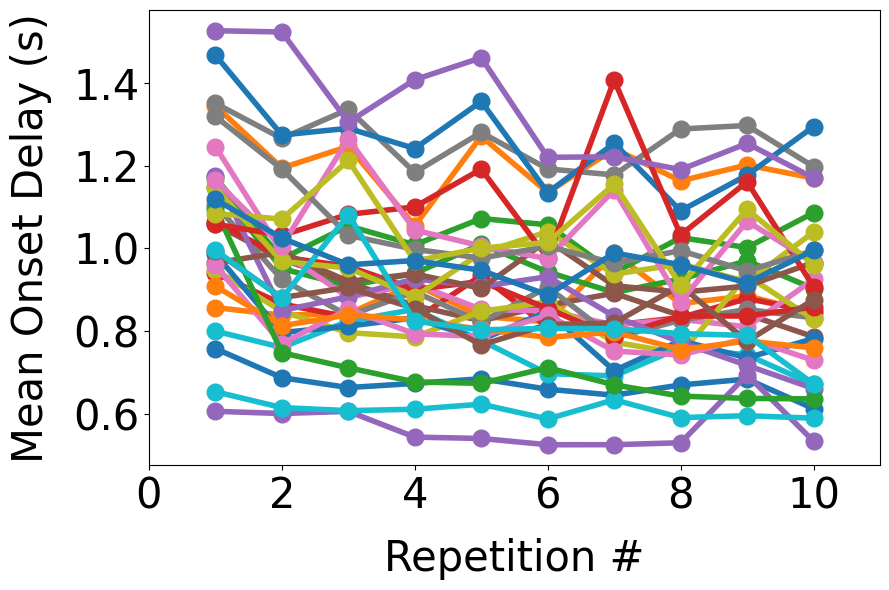

In [66]:
## plot pseudo ods over trials across individuals
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = list(range(1,11))
D = (pseudo_ods[pseudo_ods['rep_num'] == 0]['mean'],
    pseudo_ods[pseudo_ods['rep_num'] == 1]['mean'],
    pseudo_ods[pseudo_ods['rep_num'] == 2]['mean'],
    pseudo_ods[pseudo_ods['rep_num'] == 3]['mean'],
    pseudo_ods[pseudo_ods['rep_num'] == 4]['mean'],
    pseudo_ods[pseudo_ods['rep_num'] == 5]['mean'],
    pseudo_ods[pseudo_ods['rep_num'] == 6]['mean'],
    pseudo_ods[pseudo_ods['rep_num'] == 7]['mean'],
    pseudo_ods[pseudo_ods['rep_num'] == 8]['mean'],
    pseudo_ods[pseudo_ods['rep_num'] == 9]['mean'])

# means = (np.mean(od_avgs[od_avgs['wf_type'] == 'pseudo']['key_resp.rt.1']),
#         np.mean(od_avgs[od_avgs['wf_type'] == 'lowwf']['key_resp.rt.1']),
#         np.mean(od_avgs[od_avgs['wf_type'] == 'medwf']['key_resp.rt.1']),
#         np.mean(od_avgs[od_avgs['wf_type'] == 'highwf']['key_resp.rt.1']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
# ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([0.6, 0.65])
plt.xlim([0, 11])
plt.xticks(fontsize=30)
plt.xlabel("Repetition #", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean Onset Delay (s)", labelpad=15, fontsize=30)

plt.title("")
ax.grid(False)

fig.tight_layout()
plt.savefig(save_dir + '/meanod_byrep.png', dpi=300)
plt.show()

## Bigram-Word Interaction
___

In [67]:
## prints number of repetitions of each bigram within the string bank
rep_df = pd.DataFrame()
for bigram in typ.all_bigrams:
    rep_num = 0
    for string in typ.all_strings:
        if bigram in string:
            rep_num = rep_num + 1
    # print(bigram, rep_num)

In [68]:
## plot showing iki distributions for all bigrams in one word (correct trials, all individuals)

string = 'edthe' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

# sb.set(rc={"figure.figsize":(8, 4)})
# sb.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
# sb.violinplot(data=DF, palette='tab20').set(title = string)

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_facecolor('black')

violin = ax.violinplot(DF, showmeans = True)
for pc in violin["bodies"]:
    pc.set_facecolor("cornflowerblue")
    pc.set_edgecolor("cornflowerblue")
    pc.set_alpha(1)
    
for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = violin[partname]
    vp.set_edgecolor("lightcyan")
    vp.set_linewidth(2)
    
plt.ylim([0, 1])
plt.xticks((1, 2, 3, 4), ('he', 'eo', 'on', 'nd'))
plt.xlabel("Bigram within word", labelpad=15)
plt.ylabel("IKI (s)", labelpad=15)

fig.tight_layout()
plt.savefig('heond_dist.png', dpi=300, transparent = True)

In [69]:
## plot showing iki distributions for all bigrams in one word (correct trials, all individuals)

string = 'think' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

# sb.set(rc={"figure.figsize":(8, 4)})
# sb.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
# sb.violinplot(data=DF, palette='tab20').set(title = string)

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_facecolor('black')

violin = ax.violinplot(DF, showmeans = True)
for pc in violin["bodies"]:
    pc.set_facecolor("tomato")
    pc.set_edgecolor("tomato")
    pc.set_alpha(1)
    
for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = violin[partname]
    vp.set_edgecolor("lightcyan")
    vp.set_linewidth(2)
    
plt.ylim([0, 1])
plt.xticks((1, 2, 3, 4), ('th', 'hi', 'in', 'nk'))
plt.xlabel("Bigram within word", labelpad=15)
plt.ylabel("IKI (s)", labelpad=15)

fig.tight_layout()
plt.savefig('think_dist.png', dpi=300, transparent = True)

In [70]:
## plot showing iki distributions for all bigrams in one word (correct trials, all individuals)

string = 'theme' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

# sb.set(rc={"figure.figsize":(8, 4)})
# sb.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
# sb.violinplot(data=DF, palette='tab20').set(title = string)

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_facecolor('black')

violin = ax.violinplot(DF, showmeans = True)
for pc in violin["bodies"]:
    pc.set_facecolor("goldenrod")
    pc.set_edgecolor("goldenrod")
    pc.set_alpha(1)
    
for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = violin[partname]
    vp.set_edgecolor("lightcyan")
    vp.set_linewidth(2)
    
plt.ylim([0, 1])
plt.xticks((1, 2, 3, 4), ('th', 'he', 'em', 'me'))
plt.xlabel("Bigram within word", labelpad=15)
plt.ylabel("IKI (s)", labelpad=15)

fig.tight_layout()
plt.savefig('theme_dist.png', dpi=300, transparent = True)

In [71]:
## distribution of a bigram's IKIs for each word it occurs in (correct trials, one individual)    
strings_with_onesub = pd.DataFrame()
for string in typ.all_strings:
    bigram = 'th' ## edit bigram of interest here
    if bigram in string:
         strings_with_onesub[string] = corr_trials_bybg[(corr_trials_bybg.sID == 's180') ## edit sID here 
                                              & (corr_trials_bybg.bigram == bigram) 
                                              & (corr_trials_bybg.string == string)]['IKI'].reset_index(drop = True)
strings_with_onesub

sb.set(rc={"figure.figsize":(8, 4)})
sb.violinplot(data=strings_with_onesub)

<Axes: xlabel='Bigram within word', ylabel='IKI (s)'>

In [72]:
## distribution of a bigram's IKIs for each word it occurs in (correct trials, all individuals)
strings_with = pd.DataFrame()

for string in typ.all_strings:
        bigram = 'he' ## edit bigram of interest here
        if bigram in string:
                temp = corr_trials_bybg[(corr_trials_bybg.bigram == bigram) 
                                        & (corr_trials_bybg.string == string)]['IKI'].reset_index(drop = True)
                strings_with[string] = temp

strings_with

sb.set(rc={"figure.figsize":(8, 4)})
sb.violinplot(data=strings_with)

<Axes: xlabel='Bigram within word', ylabel='IKI (s)'>

In [73]:
## distribution of a bigram's ~INDIVIDUAL MEAN~ IKIs for each word it occurs in (correct trials, all individuals)
strings_with = pd.DataFrame()
for index, ID in enumerate(ID_list):
    strings_with.loc[index, 'sID'] = ID
    for string in typ.all_strings:
        bigram = 're' ## edit bigram of interest here
        if bigram in string:
             strings_with.loc[index, string] = corr_trials_bybg[(corr_trials_bybg.sID == ID) 
                                                  & (corr_trials_bybg.bigram == bigram) 
                                                  & (corr_trials_bybg.string == string)]['IKI'].mean()

strings_with

sb.set(rc={"figure.figsize":(8, 4)})
sb.violinplot(data=strings_with)

<Axes: xlabel='Bigram within word', ylabel='IKI (s)'>

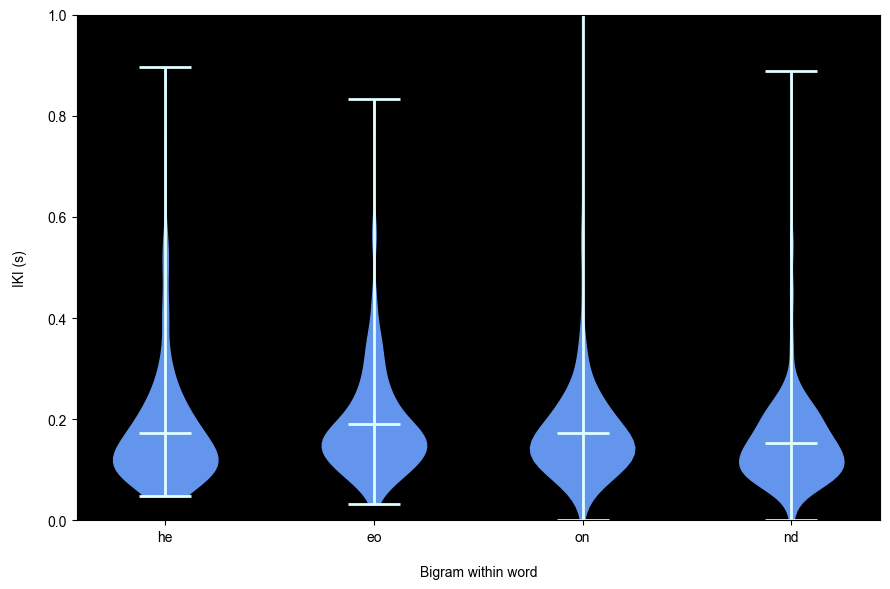

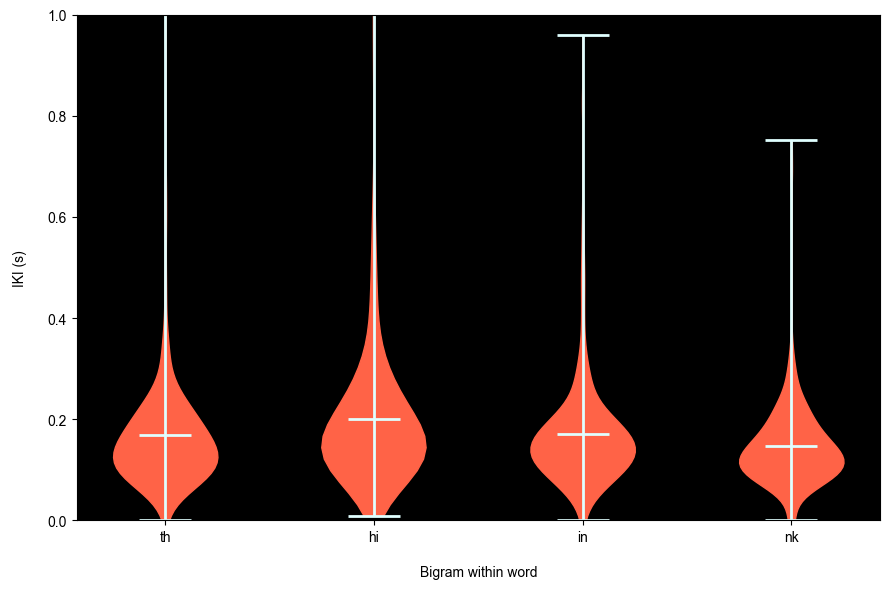

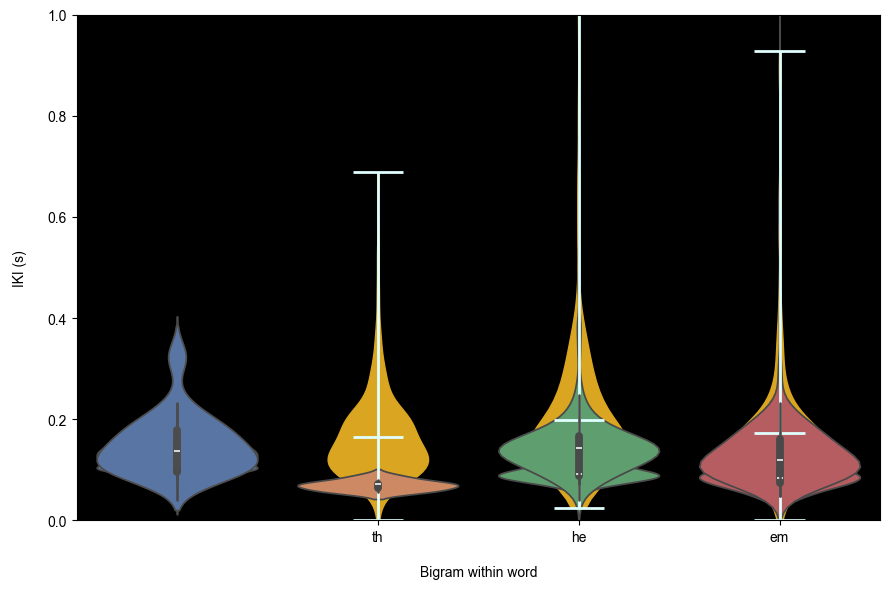

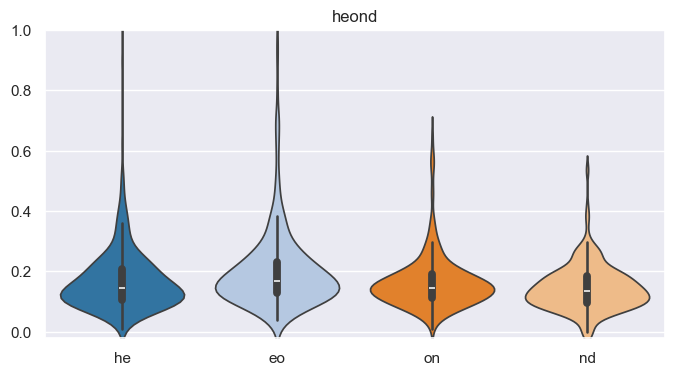

In [74]:
string = 'heond' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

# sb.set(rc={"figure.figsize":(8, 4)})
fig, ax = plt.subplots()
# sb.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sb.violinplot(data=DF, palette='tab20', ax=ax).set(title = string)
ax.set_ylim(-0.02,1)
plt.show()

In [75]:
## plot showing iki distributions for bigrams in each word (correct trials, all individuals)
fig, axs = plt.subplots(8, 3, figsize=(25, 25))
fig.subplots_adjust(hspace=0.3)
#axs.set_ylim([0,2])

for y, freq in enumerate(typ.avgbf_types):
    for x, string in enumerate(freq):
        DF = corr_trials[corr_trials.string == string]
        DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
        bgs = typ.bi_byword(string)
        DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})
        sb.violinplot(data=DF, ax=axs[x,y]).set(title = string)
        axs[x,y].set_ylim([-0.1,1])
        

In [76]:
## plot showing iki distributions for bigrams in each word for one participant (correct trials)

fig, axs = plt.subplots(8, 3, figsize=(25, 25))
fig.subplots_adjust(hspace=0.3)

for y, freq in enumerate(typ.avgbf_types):
    for x, string in enumerate(freq):
        DF = corr_trials[(corr_trials.string == string)
                        & (corr_trials.sID == 's175')] ## change ID here
        DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
        bgs = typ.bi_byword(string)
        DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})
        sb.violinplot(data=DF, ax=axs[x,y]).set(title = string)
        axs[x,y].set_ylim([-0.1,1])

## Delta IKI

In [77]:
# def indiv_cvs_bybg(string, bigram):
#     DF = tight_bgs.query('string == @string and bigram == @bigram')
#     cvs = pd.DataFrame(DF.groupby('sID').IKI.agg([variation]))
#     return cvs

## defining functions that calculate indivdual IKI means and Avg. CVS by word and bigram groupings

# def indiv_means(dataframe, str_or_bg, sort_type): ## str_or_bg can be 'string' or 'bigram'
#     if str_or_bg == 'string':
#         DF = dataframe[dataframe.string.isin(sort_type)]
#     elif str_or_bg == 'bigram':
#         DF = dataframe[dataframe.bigram.isin(sort_type)]
#     means = pd.DataFrame(DF.groupby('sID').IKI.agg(['mean'])).reset_index().rename(columns = {'mean':'Avg IKI'})
#     # means.columns = ['Avg IKI']
#     return means

# all_bigrams

# # def deltaiki(dataframe,):

# def deltaiki_bybg(dataframe, string, bigram):
#     DF = dataframe.query('string == @string and bigram == @bigram')
#     deltaikis = pd.DataFrame(DF.groupby('sID').IKI.agg(['diff'])).abs()
#     DF.insert(7, 'delta_iki', deltaikis)
#     # deltaikis.insert(0, 'sID', DF['sID'])
#     # for ID in ID_list:
#     #     deltaikis
#     # return DF.get_group('s210')
#     # return DF[DF.sID == 's209']
#     return DF
#     # return deltaikis
    
# # def indiv_deltaiki_bybg(dataframe, string, bigram):
# #     # DF = 
# #     DF = deltaiki_bybg(dataframe, string, bigram)
# #     DF = DF[DF.sID == sID].reset_index().drop(0)
# #     return DF

# # indiv_deltaiki_bybg('s209', all_bigrams, 'there', 'th')

# def deltaod(dataframe):
#     # DF = dataframe.query('string == @string')
#     dataframe = dataframe.rename(columns = {'key_resp.rt.1':'onset_delay'})
#     deltaods = pd.DataFrame(dataframe.groupby(['sID', 'string']).onset_delay.agg(['diff']))
#     dataframe.insert(len(dataframe.columns), 'delta_od', deltaods)
#     return dataframe

# def indiv_meandeltaod(dataframe, sort_type):
#     DF = dataframe[dataframe['wf_type'] == sort_type]
#     DF = deltaod(DF)
#     mean_deltaods = DF.groupby(['sID']).delta_od.agg(['mean']).reset_index()
#     return mean_deltaods

# def indiv_avgcvs(dataframe, str_or_bg, sort_type):
#     if str_or_bg == 'string':
#         DF = dataframe[dataframe.string.isin(sort_type)]
#     else:
#         DF = dataframe[dataframe.bigram.isin(sort_type)]
#     cvs = DF.groupby(['sID', str_or_bg]).IKI.agg([variation])
#     avg_cvs = pd.DataFrame(cvs.groupby('sID').variation.agg(['mean'])).reset_index().rename(columns = {'mean':'Avg CV IKI'})
#     # avg_cvs.columns = ['Avg CV IKI']
#     return avg_cvs

# def indiv_deltaikis(dataframe, str_or_bg, sort_type):
#     if str_or_bg == 'string':
#         DF = dataframe[dataframe.string.isin(sort_type)]
#     else:
#         DF = dataframe[dataframe.bigram.isin(sort_type)]
#     deltas = pd.DataFrame(DF.groupby(['sID', str_or_bg]).IKI.agg(['diff'])).abs().reset_index(drop=True)
#     deltas = deltas.rename(columns={'diff':'deltaiki'})
#     return deltas


def deltaiki(dataframe):
    # dataframe = dataframe.rename(columns = {'key_resp.rt.1':'onset_delay'})
    deltaikis = pd.DataFrame(dataframe.groupby(['sID', 'string', 'bigram']).IKI.agg(['diff']))
    deltaikis.fillna(0, inplace=True)
    if 'delta_iki' in dataframe.columns:
        dataframe.replace(dataframe['delta_iki'], deltaikis)
    else:
        dataframe.insert(len(dataframe.columns), 'delta_iki', deltaikis)
    return dataframe

def indiv_meandeltaiki(dataframe, str_or_bg, sort_type):
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    else:
        print('use "string" or "bigram"')
    DF = deltaiki(DF)
    mean_deltaikis = DF.groupby(['sID']).delta_iki.agg(['mean']).reset_index()
    mean_deltaikis = mean_deltaikis.rename(columns={'mean' : 'mean_deltaiki'})
    return mean_deltaikis

In [78]:
test = deltaiki(corr_trials_bybg)
# test[test['rep_num'] == 0].sort_values(['trial_num'])
test[(test['sID'] == 's254') & (test['string'] == 'there') & (test['bigram'] == 'th')]

sID  bigram_num  trial_num  rep_num  bigram_loc bigram resp_bigram  \
20668  s254         110         29        0           0     th          th   
20680  s254         122         32        1           0     th          th   
20844  s254         298         76        2           0     th          th   
20884  s254         338         86        3           0     th          th   
20924  s254         390         99        4           0     th          th   
21020  s254         488        124        5           0     th          th   
21092  s254         570        145        6           0     th          th   
21224  s254         716        181        7           0     th          th   
21364  s254         865        219        8           0     th          th   

            IKI string resp_string     bg_freq bf_type meanbf_type wf_type  \
20668  0.184101  there       there  22288309.0    high        high    high   
20680  0.248133  there       there  22288309.0    high        high    high   
20844  0.152131  there       there  22288309.0    high        high    high   
20884  0.135969  there       there  22288309.0    high        high    high   
20924  0.128088  there       there  22288309.0    high        high    high   
21020  0.144111  there       there  22288309.0    high        high    high   
21092  0.184144  there       there  22288309.0    high        high    high   
21224  0.192128  there       there  22288309.0    high        high    high   
21364  0.136103  there       there  22288309.0    high        high    high   

       delta_iki  
20668   0.000000  
20680   0.064032  
20844  -0.096002  
20884  -0.016162  
20924  -0.007881  
21020   0.016022  
21092   0.040034  
21224   0.007984  
21364  -0.056025

In [79]:
## anova on delta iki comparisons across WF
deltaiki_anova = pg.rm_anova(deltaiki(corr_trials_bybg.drop(9779)), 'delta_iki', 'wf_type', 'sID')
print(deltaiki_anova)
pg.pairwise_tukey(deltaiki(corr_trials_bybg.drop(9779)), 'delta_iki', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F     p-unc       ng2       eps
0  wf_type      3     90  11.234627  0.000002  0.146192  0.753464


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low -0.000376 -0.003124  0.002749  0.001419  1.936451  0.212788   
1  high     med -0.000376 -0.001637  0.001261  0.001416  0.890740  0.809686   
2  high  pseudo -0.000376 -0.003439  0.003064  0.001418  2.161105  0.134249   
3   low     med -0.003124 -0.001637 -0.001488  0.001427 -1.042450  0.724432   
4   low  pseudo -0.003124 -0.003439  0.000315  0.001429  0.220414  0.996223   
5   med  pseudo -0.001637 -0.003439  0.001803  0.001425  1.264756  0.585475   

      cohen  
0  0.033329  
1  0.017601  
2  0.035110  
3 -0.016998  
4  0.003120  
5  0.019576

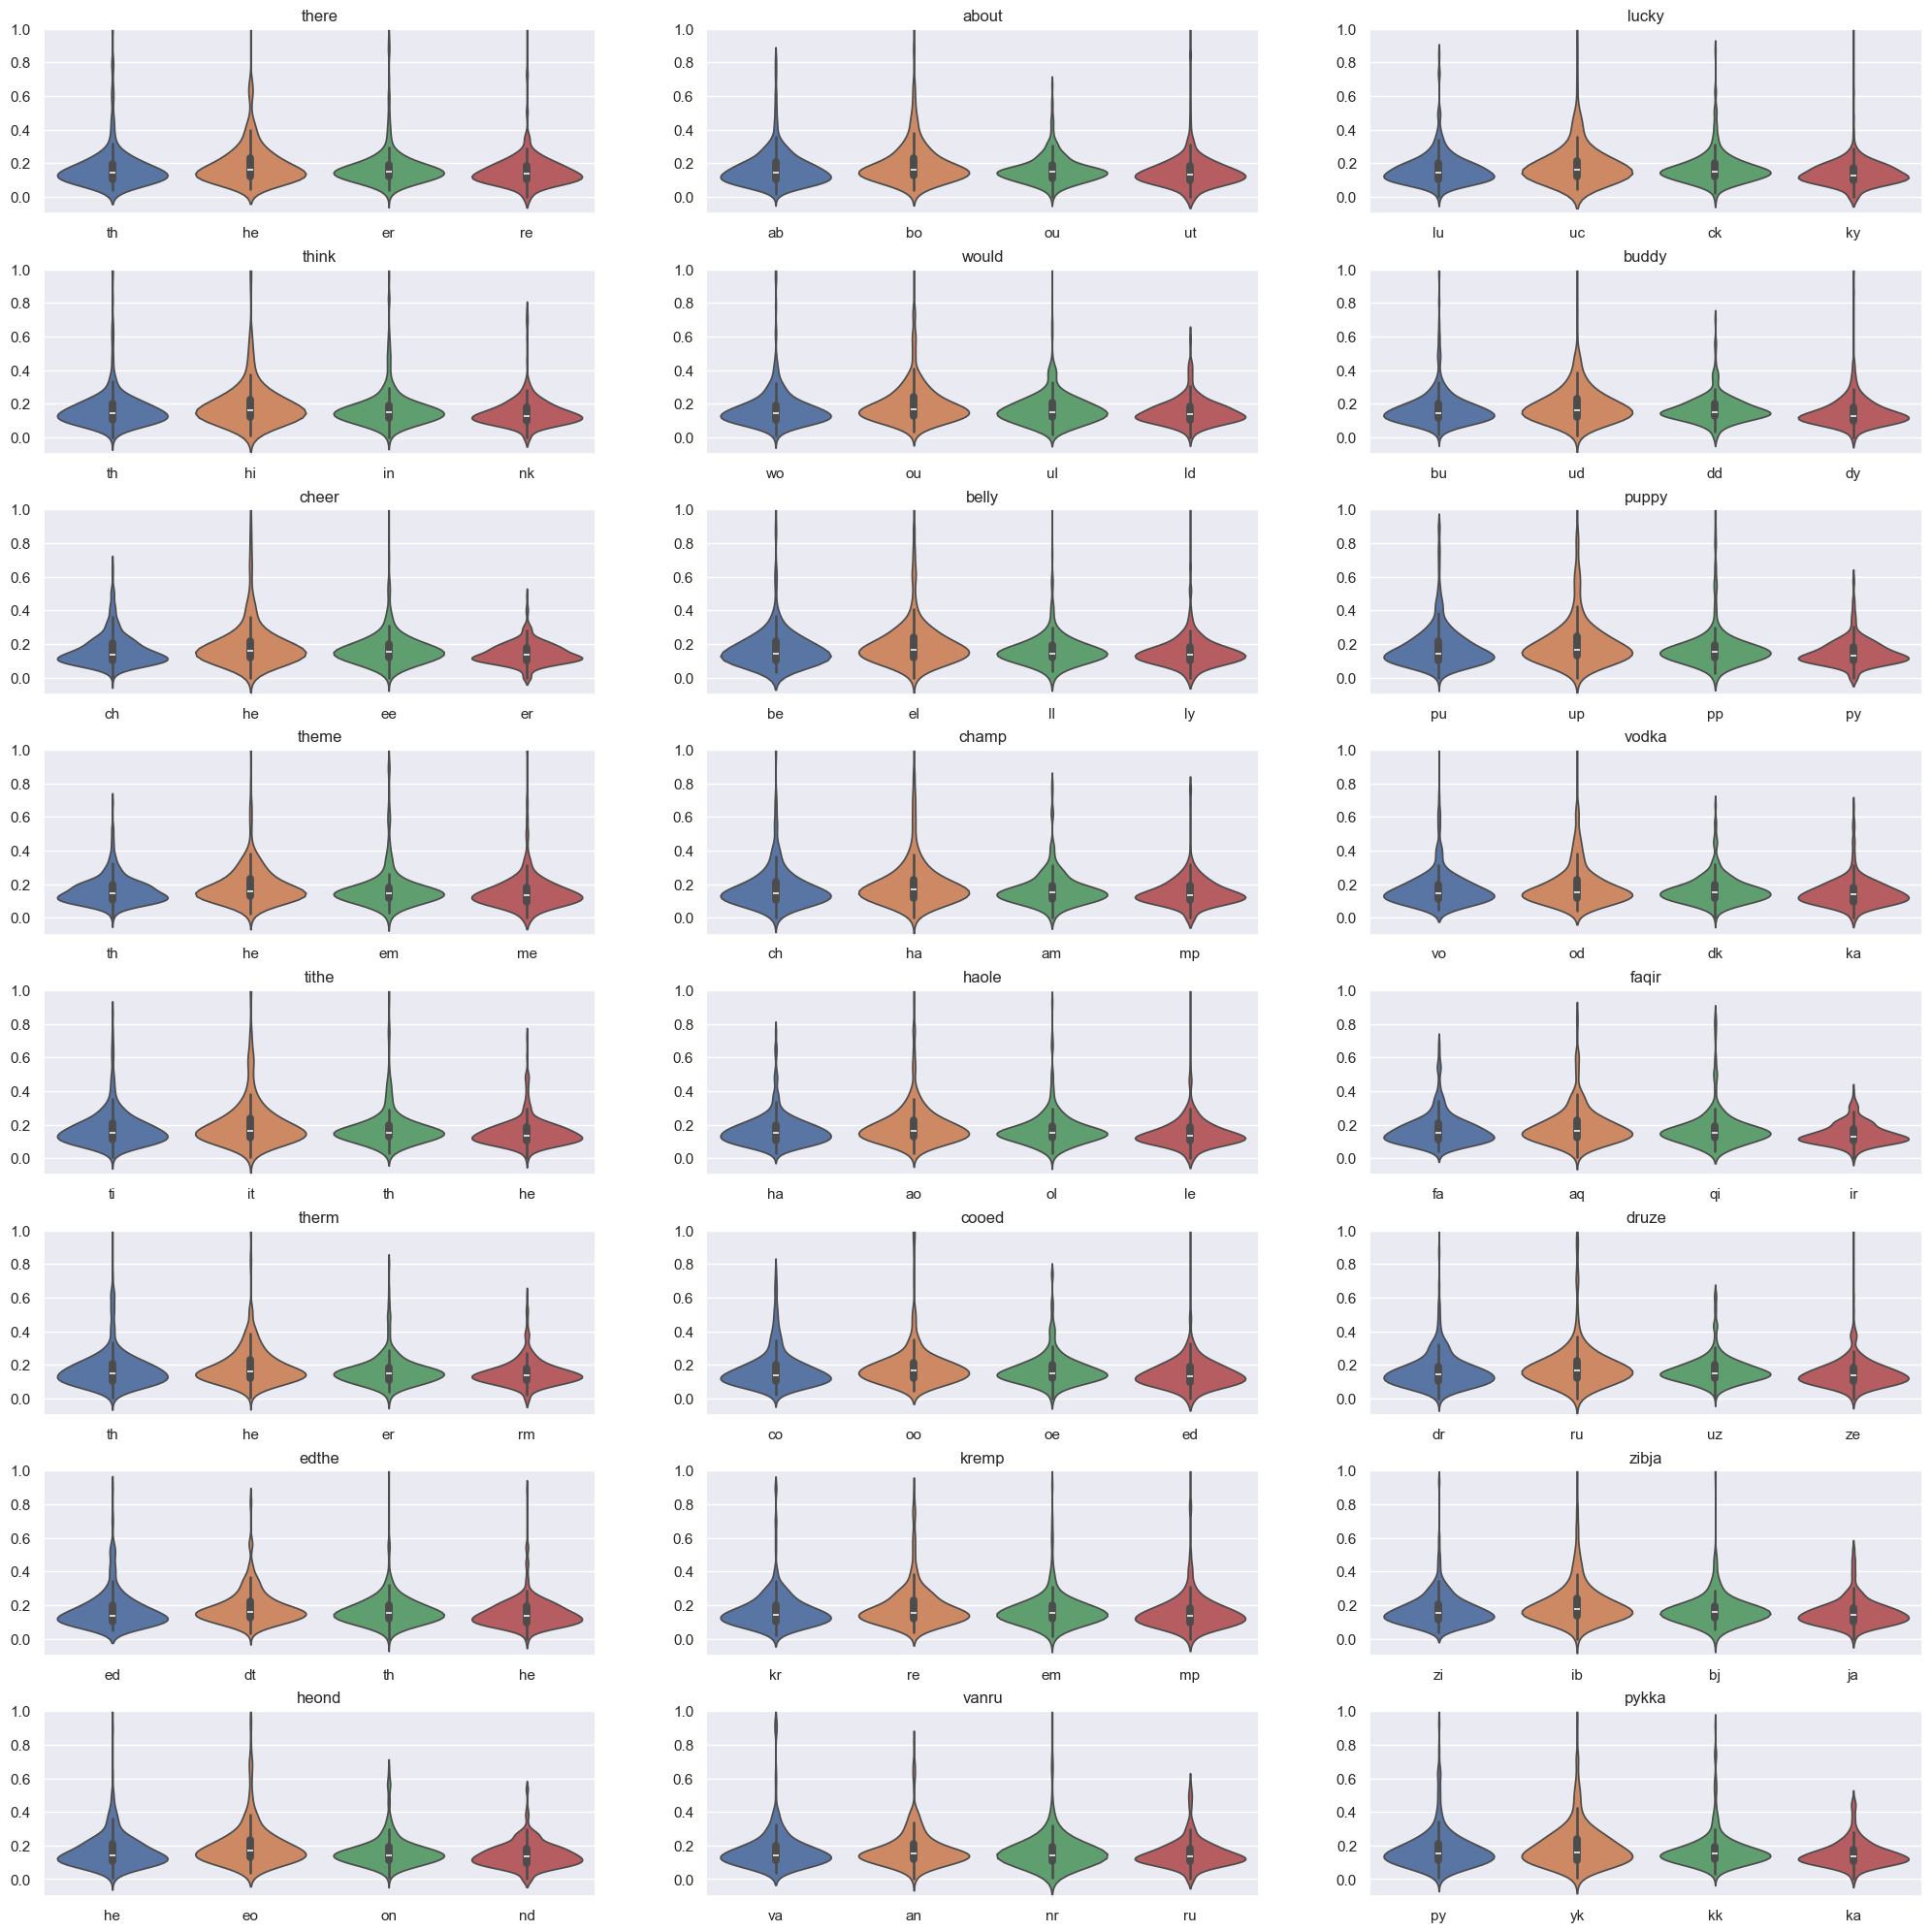

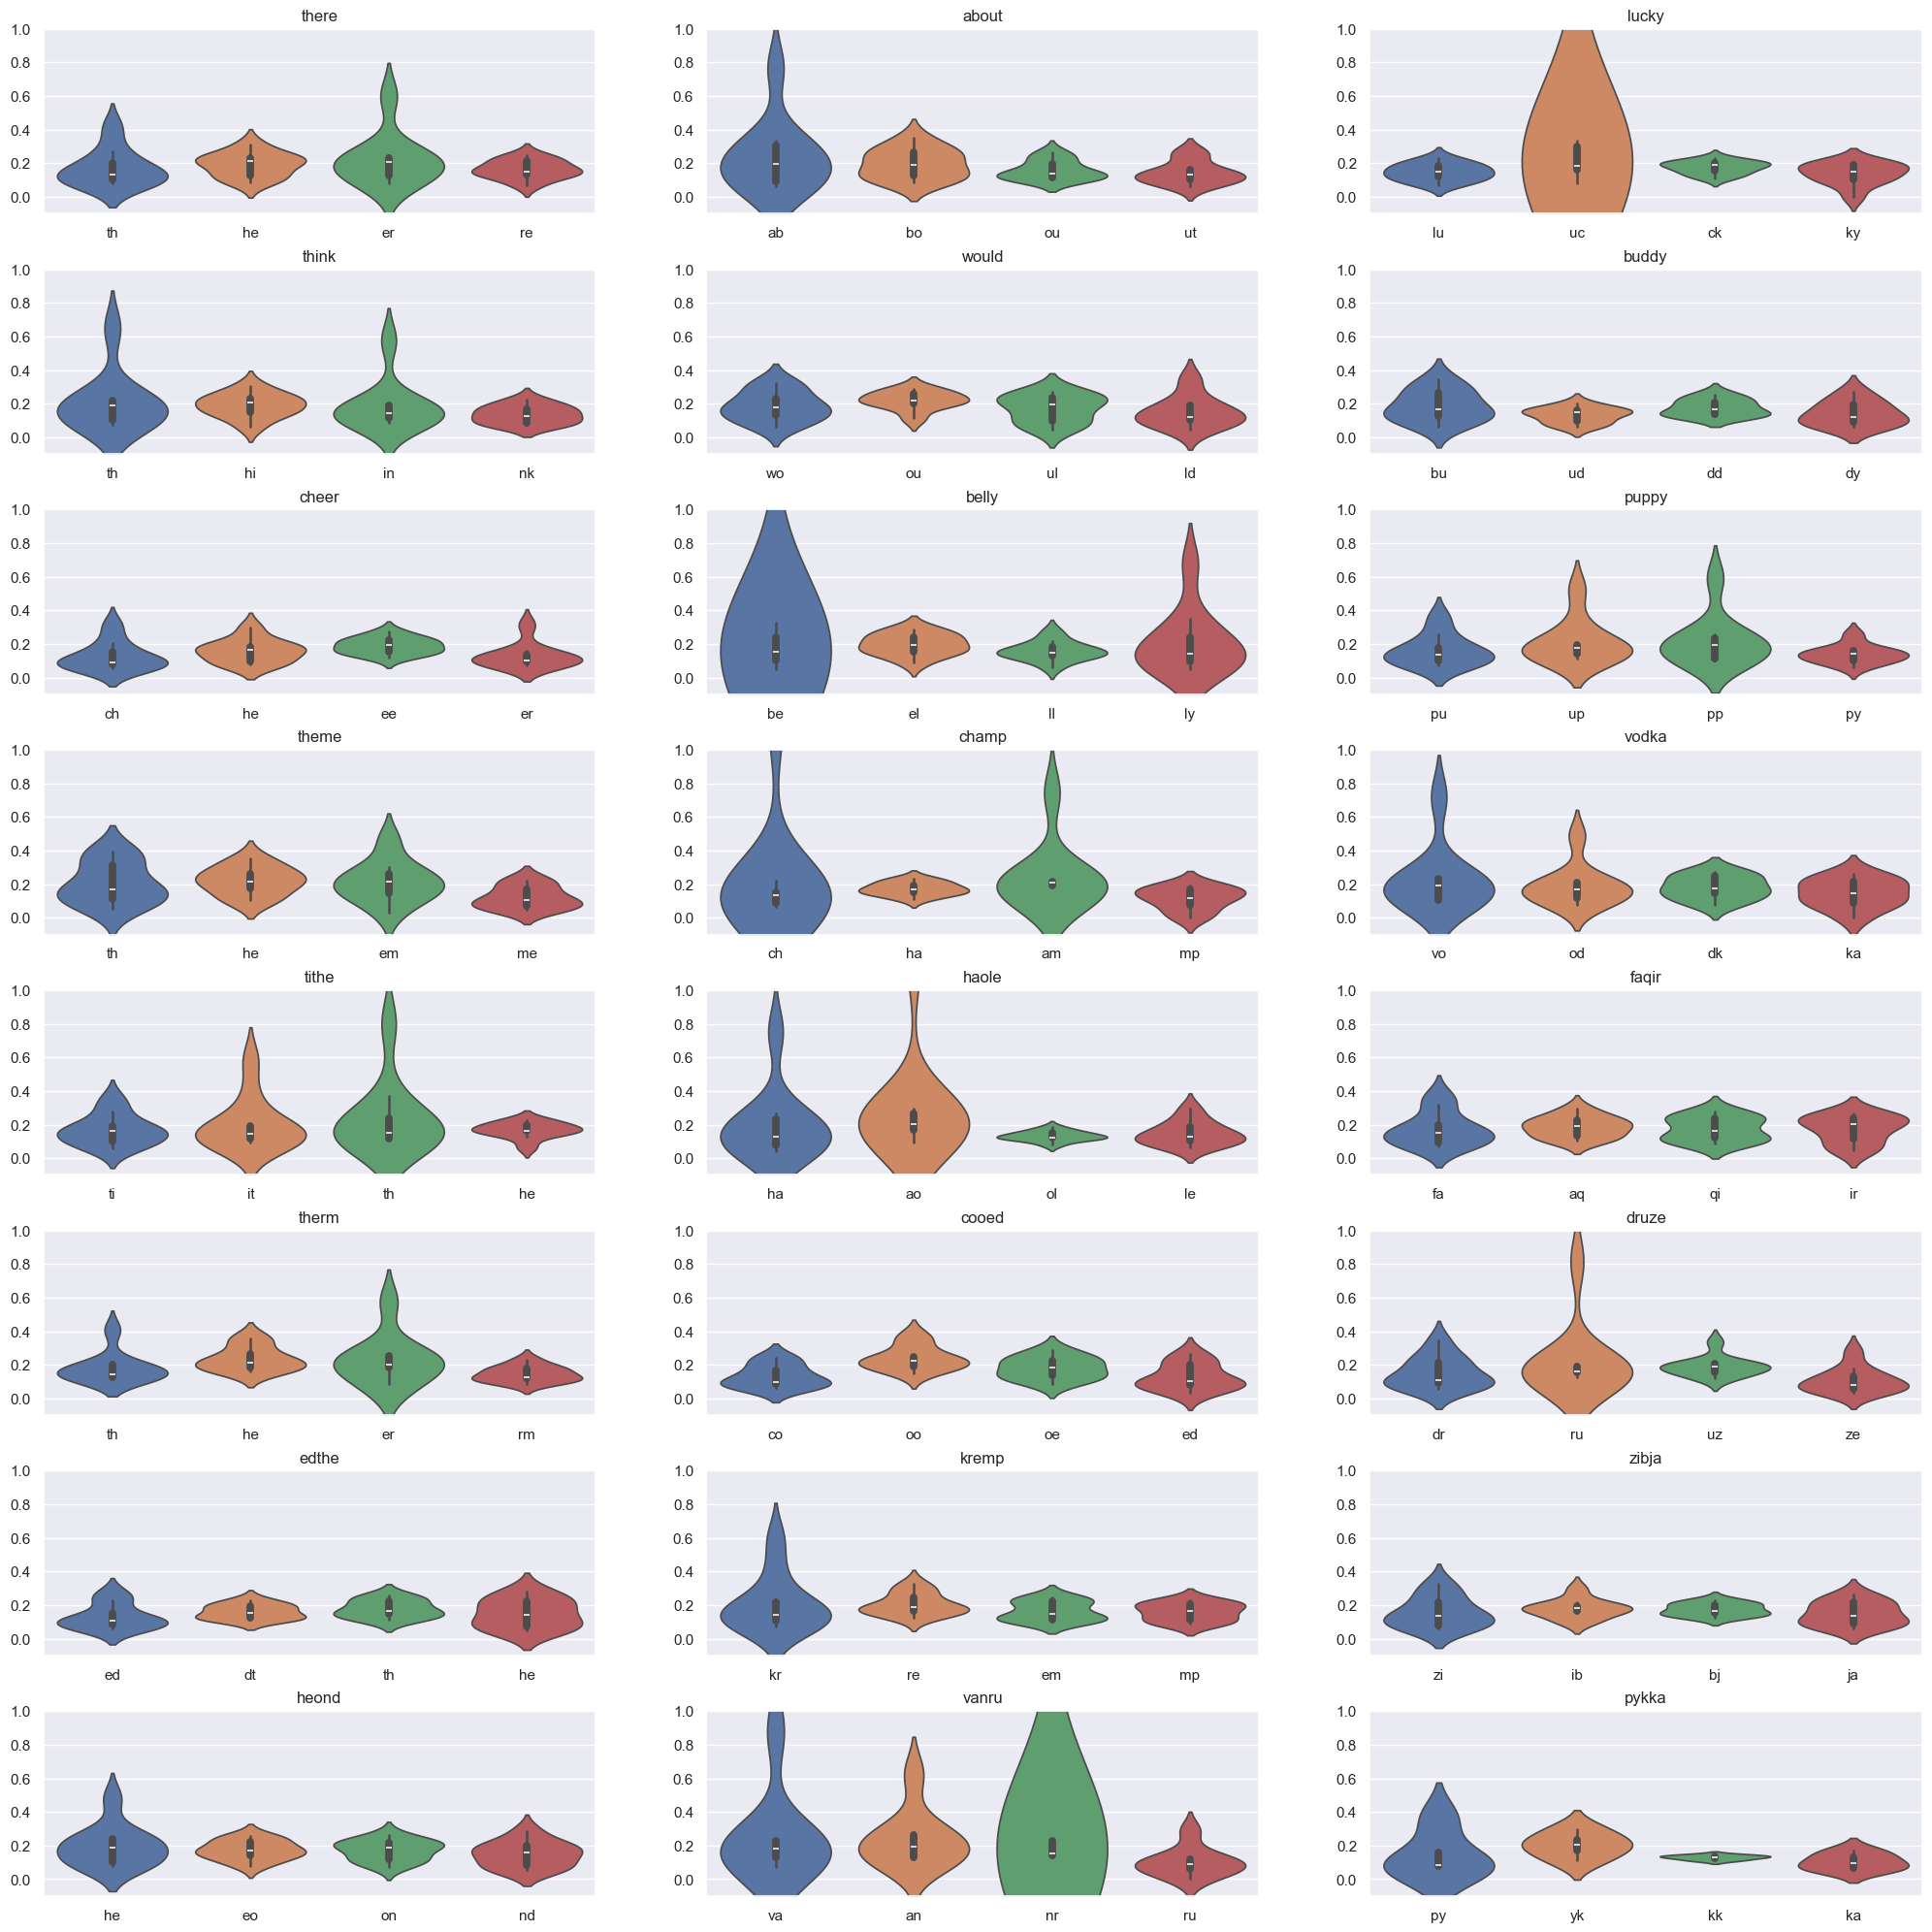

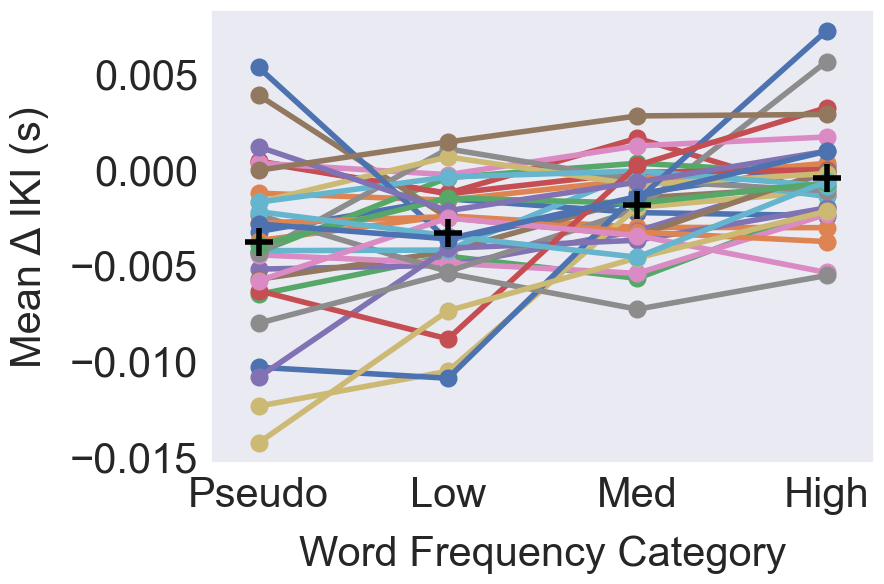

In [80]:
## plotting mean delta iki by WF group
# plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = [2, 4, 6, 8]
D = (indiv_meandeltaiki(corr_trials_bybg, 'string', typ.pseudo)['mean_deltaiki'],
    indiv_meandeltaiki(corr_trials_bybg, 'string', typ.lowwf)['mean_deltaiki'],
    indiv_meandeltaiki(corr_trials_bybg, 'string', typ.medwf)['mean_deltaiki'],
    indiv_meandeltaiki(corr_trials_bybg, 'string', typ.highwf)['mean_deltaiki'])

means = (np.mean(indiv_meandeltaiki(corr_trials_bybg, 'string', typ.pseudo)['mean_deltaiki']),
        np.mean(indiv_meandeltaiki(corr_trials_bybg, 'string', typ.lowwf)['mean_deltaiki']),
        np.mean(indiv_meandeltaiki(corr_trials_bybg, 'string', typ.medwf)['mean_deltaiki']),
        np.mean(indiv_meandeltaiki(corr_trials_bybg, 'string', typ.highwf)['mean_deltaiki']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([-0.129, 0.06])
plt.xlim([1.5, 8.5])
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize=30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean Δ IKI (s)", labelpad=15, fontsize=30)

plt.title("")
ax.grid(False)

fig.tight_layout()
plt.savefig(save_dir + '/meandeltaiki_bywf.png', dpi=300)
plt.show()

In [81]:
pseudo_strings = corr_trials_bybg[corr_trials_bybg['wf_type'] == 'pseudo']
pseudo_ikis = pseudo_strings.groupby(['sID', 'rep_num']).IKI.agg(['mean']).reset_index()

<Figure size 640x480 with 0 Axes>

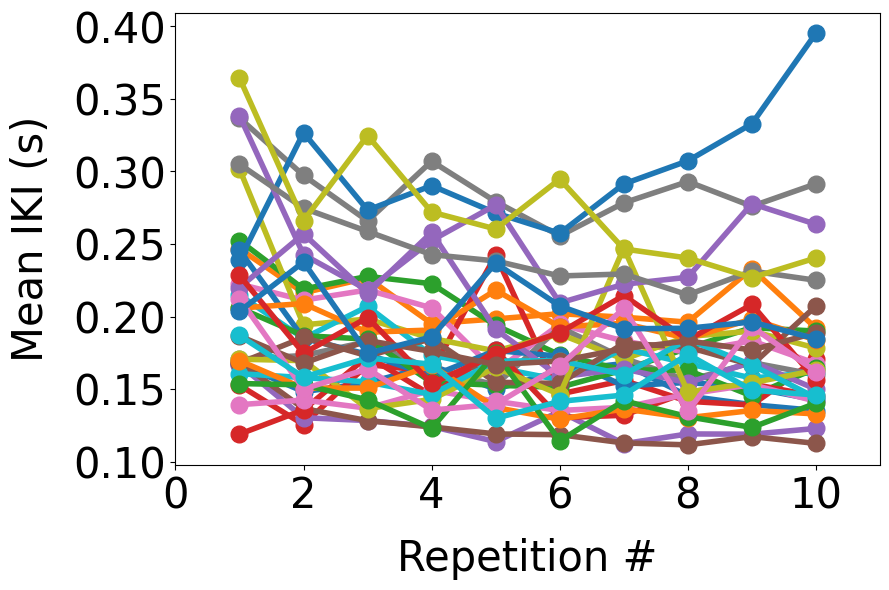

In [82]:
## plot pseudo ods over trials across individuals
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = list(range(1,11))
D = (pseudo_ikis[pseudo_ikis['rep_num'] == 0]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 1]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 2]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 3]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 4]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 5]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 6]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 7]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 8]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 9]['mean'])

# means = (np.mean(od_avgs[od_avgs['wf_type'] == 'pseudo']['key_resp.rt.1']),
#         np.mean(od_avgs[od_avgs['wf_type'] == 'lowwf']['key_resp.rt.1']),
#         np.mean(od_avgs[od_avgs['wf_type'] == 'medwf']['key_resp.rt.1']),
#         np.mean(od_avgs[od_avgs['wf_type'] == 'highwf']['key_resp.rt.1']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
# ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([0.6, 0.65])
plt.xlim([0, 11])
plt.xticks(fontsize=30)
plt.xlabel("Repetition #", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean IKI (s)", labelpad=15, fontsize=30)

plt.title("")
ax.grid(False)

fig.tight_layout()
plt.savefig(save_dir + '/meaniki_byrep.png', dpi=300)
plt.show()

In [83]:
def total_deltaiki(dataframe):
    DF = dataframe[dataframe['rep_num'].isin([0,9])]
    total_delta = pd.DataFrame(DF.groupby(['sID', 'string', 'bigram']).IKI.agg(['diff']))
    total_delta.fillna(0, inplace=True)
    if 'totaldelta_iki' in dataframe.columns:
        dataframe.replace(dataframe['totaldelta_iki'], total_delta)
    else:
        dataframe.insert(len(dataframe.columns), 'totaldelta_iki', total_delta)
    return dataframe

In [151]:
totaldelta_anova = pg.rm_anova(mean_totaldeltas, 'mean_totaldeltaiki', 'wf_type', 'sID')
print(totaldelta_anova)
pg.pairwise_tukey(mean_totaldeltas, 'mean_totaldeltaiki', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F     p-unc       ng2       eps
0  wf_type      3     90  11.087807  0.000003  0.145674  0.747306


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low -0.006356 -0.030979  0.024623  0.007271  3.386323  0.005233   
1  high     med -0.006356 -0.016904  0.010547  0.007271  1.450552  0.470630   
2  high  pseudo -0.006356 -0.035807  0.029451  0.007271  4.050321  0.000523   
3   low     med -0.030979 -0.016904 -0.014075  0.007271 -1.935771  0.218728   
4   low  pseudo -0.030979 -0.035807  0.004828  0.007271  0.663998  0.910389   
5   med  pseudo -0.016904 -0.035807  0.018903  0.007271  2.599769  0.050719   

      cohen  
0  0.965589  
1  0.446816  
2  0.931662  
3 -0.556495  
4  0.146793  
5  0.601178

In [153]:
## calculating the total difference in IKI across all repetitions

totals = total_deltaiki(corr_trials_bybg)
last_trials = totals[totals['rep_num'] == 9]
mean_totaldeltas = last_trials.groupby(['sID', 'wf_type']).totaldelta_iki.agg(['mean']).reset_index()
mean_totaldeltas = mean_totaldeltas.rename(columns={'mean':'mean_totaldeltaiki'})

<Figure size 640x480 with 0 Axes>

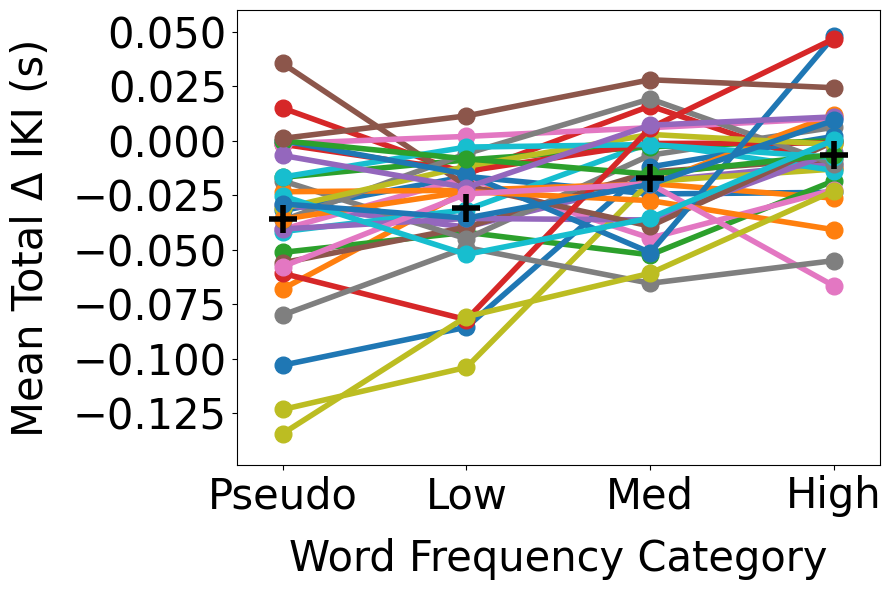

In [154]:
## plot pseudo ods over trials across individuals
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')



x = [2, 4, 6, 8]
D = (mean_totaldeltas[mean_totaldeltas['wf_type'] == 'pseudo']['mean_totaldeltaiki'],
    mean_totaldeltas[mean_totaldeltas['wf_type'] == 'low']['mean_totaldeltaiki'],
    mean_totaldeltas[mean_totaldeltas['wf_type'] == 'med']['mean_totaldeltaiki'],
    mean_totaldeltas[mean_totaldeltas['wf_type'] == 'high']['mean_totaldeltaiki'])

means = (np.mean(mean_totaldeltas[mean_totaldeltas['wf_type'] == 'pseudo']['mean_totaldeltaiki']),
        np.mean(mean_totaldeltas[mean_totaldeltas['wf_type'] == 'low']['mean_totaldeltaiki']),
        np.mean(mean_totaldeltas[mean_totaldeltas['wf_type'] == 'med']['mean_totaldeltaiki']),
        np.mean(mean_totaldeltas[mean_totaldeltas['wf_type'] == 'high']['mean_totaldeltaiki']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

plt.ylim([-0.149, 0.060])
plt.xlim([1.5, 8.5])
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize=30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean Total Δ IKI (s)", labelpad=15, fontsize=30)

plt.title("")

fig.tight_layout()
plt.savefig(save_dir + '/totaldeltaiki_bywf.png', dpi=300)
plt.show()

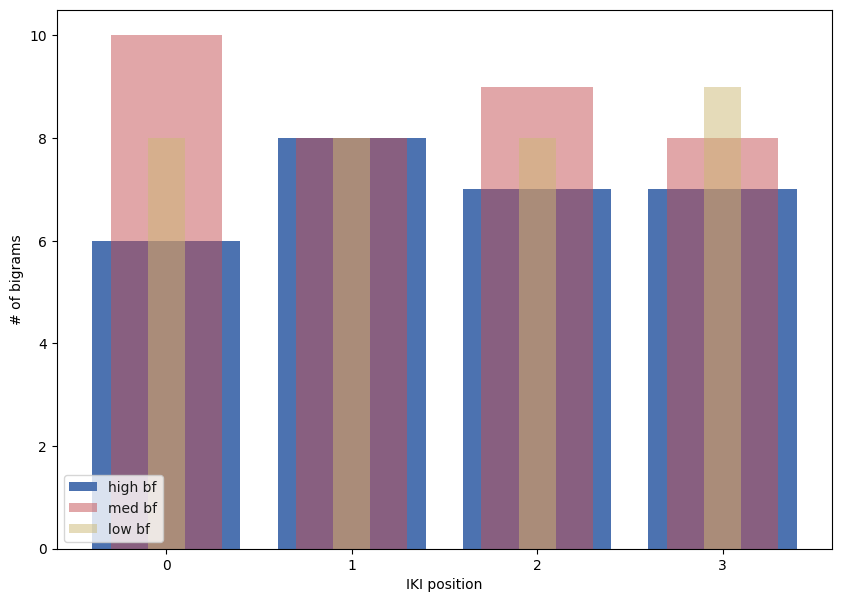

In [87]:
## plot showing distribution of bigram frequency types across each position in the string
locs = [0, 1, 2, 3]
type_list = ['high', 'med', 'low']
        
high = [6, 8, 7, 7]
med = [10, 8, 9, 8]
low = [8, 8, 8, 9]

plt.figure(figsize=(10, 7))
indices = np.arange(len(high))
width = 0.8

plt.bar(indices, high, width=width, 
        color='b', label='high bf')
plt.bar(indices, med, 
        width=0.75*width, color='r', alpha=0.5, label='med bf')
plt.bar(indices, low, 
        width=0.25*width, color='y', alpha=0.5, label='low bf')

plt.xticks([0, 1, 2, 3])
plt.xlabel("IKI position")
plt.ylabel("# of bigrams")

plt.legend(loc = 'lower left', labelcolor = 'k')

plt.show()

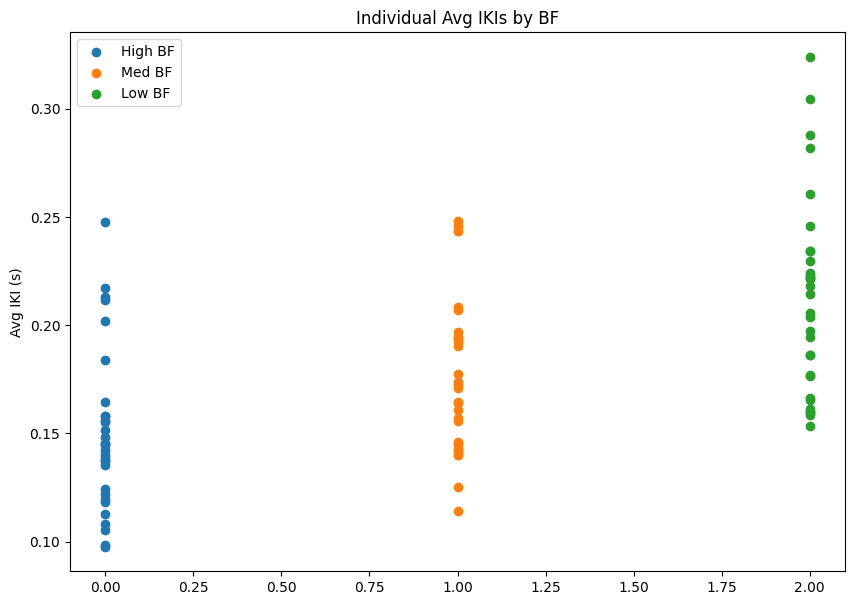

In [88]:
## Raster plot of indiv. MEAN IKI by BF

plt.figure(figsize=(10, 7))
highbf_scatter = plt.scatter([0] * len(indiv_means(all_bigrams, 'bigram', typ.highbf)['Avg IKI']), 
                              indiv_means(all_bigrams, 'bigram', typ.highbf)['Avg IKI'], 
                              label='High BF')
medbf_scatter = plt.scatter([1] * len(indiv_means(all_bigrams, 'bigram', typ.medbf)['Avg IKI']), 
                              indiv_means(all_bigrams, 'bigram', typ.medbf)['Avg IKI'], 
                              label='Med BF')
Lowbf_scatter = plt.scatter([2] * len(indiv_means(all_bigrams, 'bigram', typ.lowbf)['Avg IKI']), 
                              indiv_means(all_bigrams, 'bigram', typ.lowbf)['Avg IKI'], 
                              label='Low BF')

plt.xlabel("")
plt.ylabel("Avg IKI (s)")
plt.title("Individual Avg IKIs by BF")
plt.legend(loc= "best")

plt.show()

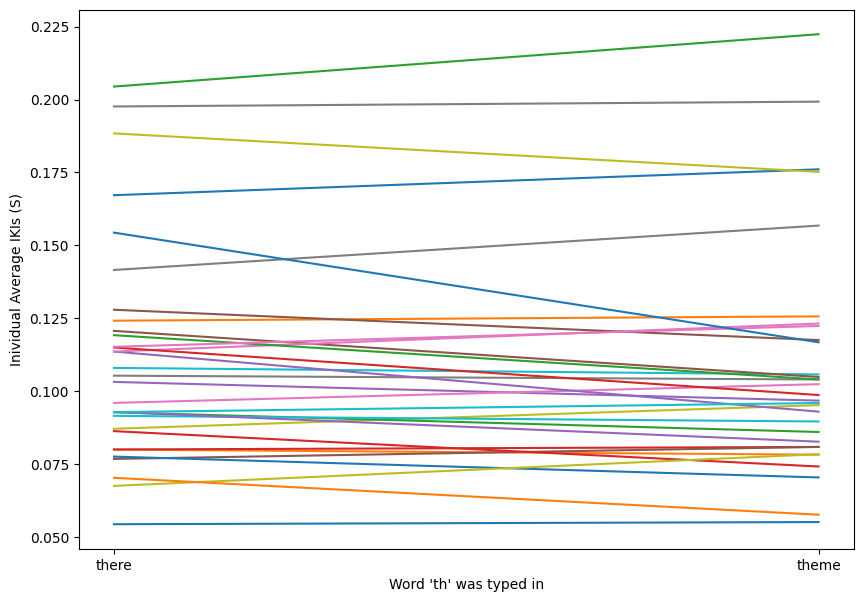

In [89]:
## plot comparing indidivuals' average IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_means_bybg('there', 'th')['mean'], indiv_means_bybg('theme', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Average IKIs (S)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

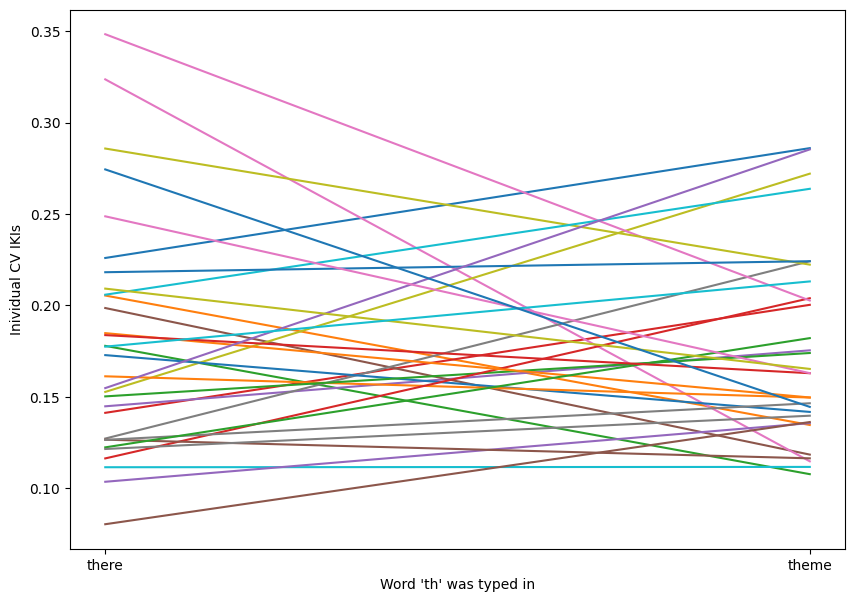

In [90]:
## plot comparing indidivuals' CV IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('theme', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

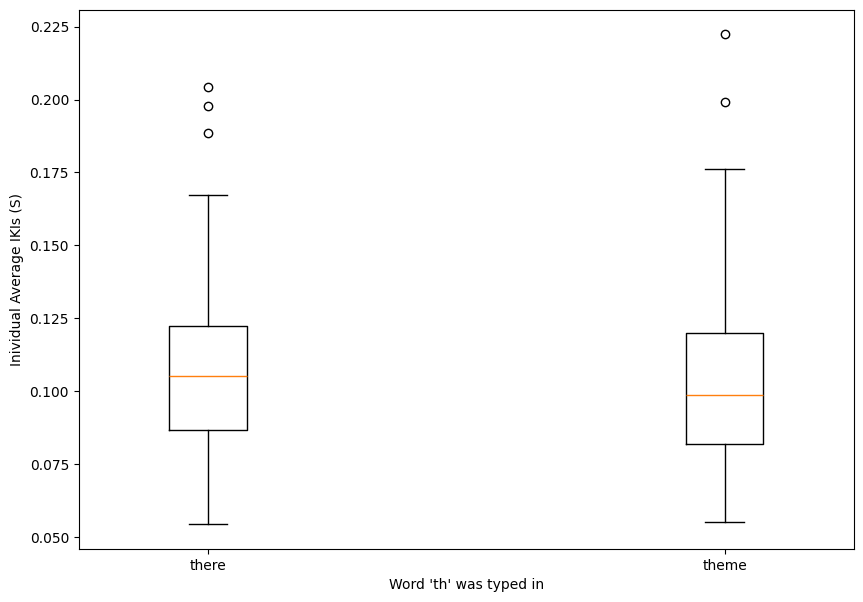

In [91]:
## box plot comparing indidivuals' average IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_means_bybg('there', 'th')['mean'], indiv_means_bybg('theme', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.boxplot(D, positions=x)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Average IKIs (S)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

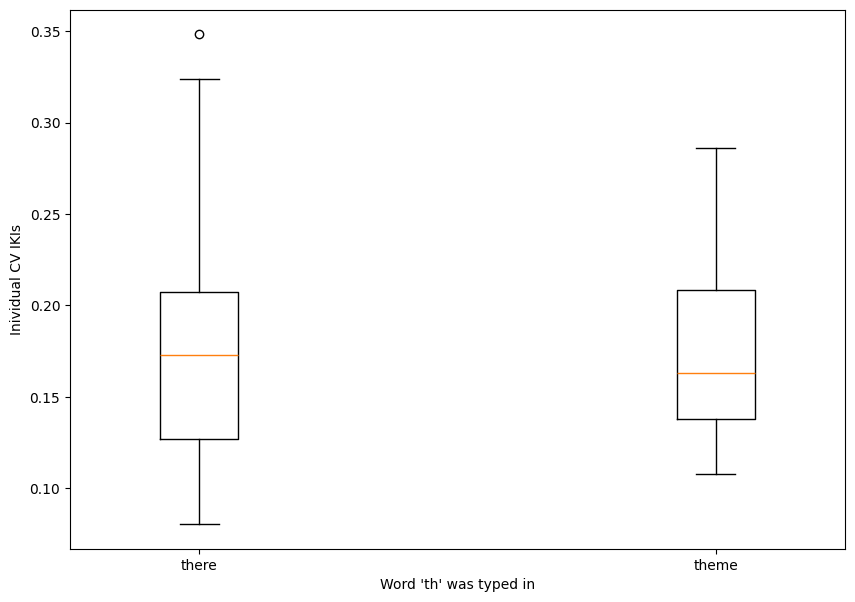

In [92]:
## box plot comparing indidivuals' CV IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('theme', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.boxplot(D, positions=x)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

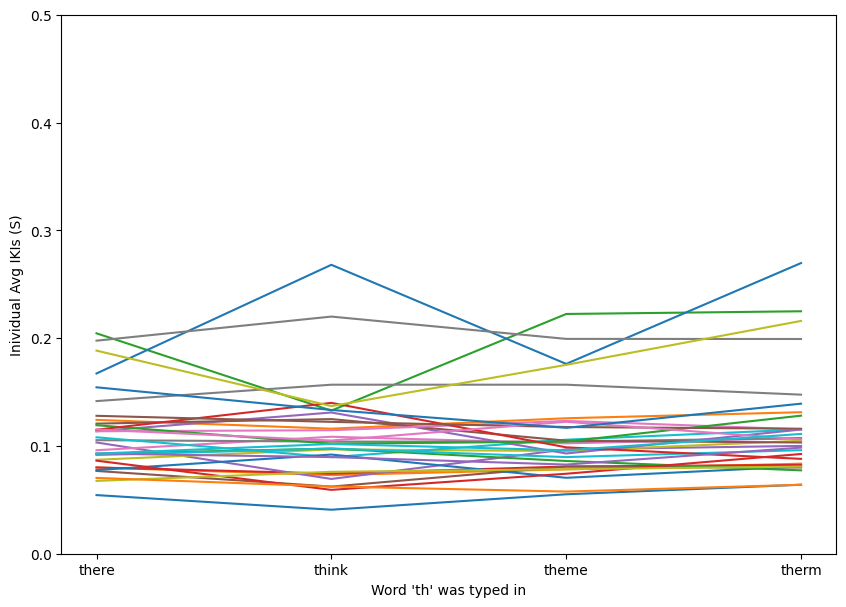

In [93]:
x = [2, 4, 6, 8]
D = (indiv_means_bybg('there', 'th')['mean'], indiv_means_bybg('think', 'th')['mean'], 
     indiv_means_bybg('theme', 'th')['mean'], indiv_means_bybg('therm', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'think', 'theme', 'therm'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Avg IKIs (S)")
plt.ylim([0, 0.5])
plt.title("")
# plt.legend(loc="best")

plt.show()

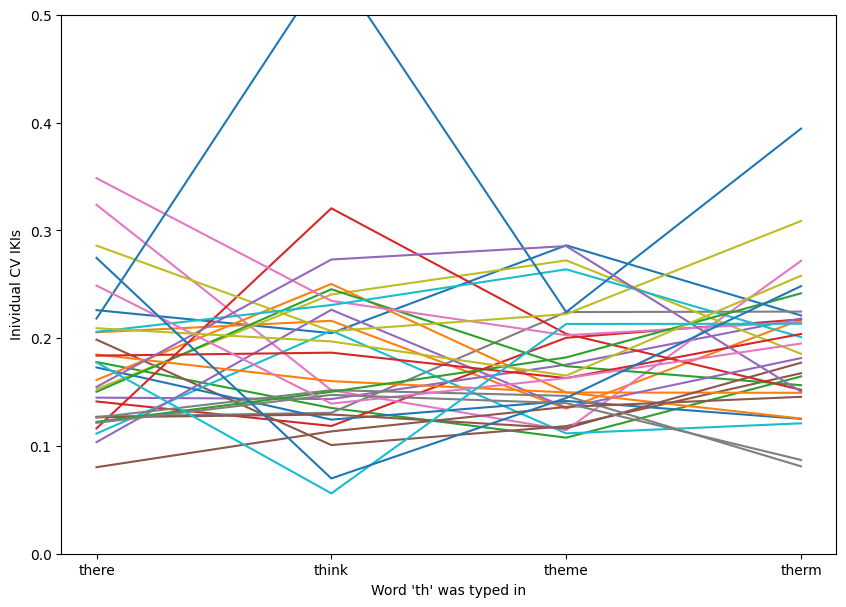

In [94]:
x = [2, 4, 6, 8]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('think', 'th')['variation'], 
     indiv_cvs_bybg('theme', 'th')['variation'], indiv_cvs_bybg('therm', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'think', 'theme', 'therm'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
plt.ylim([0, 0.5])
plt.title("")
# plt.legend(loc="best")

plt.show()

## Not Useful Graphs - Variables by Word and Word Type (WF and Avg. BF)
___

In [95]:
# ## creating dataframe from 'cv_byword' function that is easy to plot
# cv_word = 'druze' # change this for which ever word you want to plot
# cv_byword_df = (pd.DataFrame(typ.cv_byword(cv_word, corr_rts)).drop(0)).reset_index(drop = True)

# ## plotting digraph latency variations by word (does not include error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highwf_plot = plt.plot(cv_byword_df, color='red', label=cv_word)
# # medwf_plot = plt.plot(cv_byword_df, color='red', label='There')

# ## Set general font size
# plt.rcParams['font.size'] = '25'

# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by Word")
# plt.legend(loc="best")

# plt.show()

In [96]:
# ## plotting digraph latency variations by wf_type (includes error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highwf_plot = plt.plot(typ.avg_cv(typ.highwf, all_rts), color='red', label='High WF')
# medwf_plot = plt.plot(typ.avg_cv(typ.medwf, all_rts), color='blue', label='Medium WF')
# lowwf_plot = plt.plot(typ.avg_cv(typ.lowwf, all_rts), color='green', label='Low WF')
# pseudo_plot = plt.plot(typ.avg_cv(typ.pseudo, all_rts), color='orange', label='Pseudo')

# ## Set tick font size
# # for label in (ax.get_xticklabels() + ax.get_yticklabels()):
# #     label.set_fontsize(25)

# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Interval position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 1])
# plt.title("Average CV of Interkey Interval by Word Frequency (w/ error)", pad=30)
# plt.legend(loc="best")

# # plt.savefig('ian_iki.png')

# plt.show()

In [97]:
# ## plotting digraph latency variations by wf_type (does not include error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highwf_plot = plt.plot(typ.avg_cv(typ.highwf, corr_rts), color='red', label='High WF')
# medwf_plot = plt.plot(typ.avg_cv(typ.medwf, corr_rts), color='blue', label='Medium WF')
# lowwf_plot = plt.plot(typ.avg_cv(typ.lowwf, corr_rts), color='green', label='Low WF')
# pseudo_plot = plt.plot(typ.avg_cv(typ.pseudo, corr_rts), color='orange', label='Pseudo')


# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by wf_type (w/out error)")
# plt.legend(loc="best")

# plt.show()

In [98]:
# ## plotting digraph latency variations by Avg. BF type (includes error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highbf_plot = plt.plot(typ.avg_cv(typ.avg_highbf, all_rts), color='red', label='High bigram freq.')
# medbf_plot = plt.plot(typ.avg_cv(typ.avg_medbf, all_rts), color='blue', label='Medium bigram freq.')
# lowbf_plot = plt.plot(typ.avg_cv(typ.avg_lowbf, all_rts), color='green', label='Low bigram freq.')

# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by Avg. BF Type (w/ error)")
# plt.legend(loc="best")

# plt.show()

In [99]:
# ## plotting digraph latency variations by Avg. BF type (does not include error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highbf_plot = plt.plot(typ.avg_cv(typ.avg_highbf, corr_rts), color='red', label='High bigram freq.')
# medbf_plot = plt.plot(typ.avg_cv(typ.avg_medbf, corr_rts), color='blue', label='Medium bigram freq.')
# lowbf_plot = plt.plot(typ.avg_cv(typ.avg_lowbf, corr_rts), color='green', label='Low bigram freq.')


# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by Avg. BF Type (w/out error)")
# plt.legend(loc="best")

# plt.show()

In [100]:
# ## 4-quadrant plot showing CV IKI distribution for IKI position in the string by WF (includes error, for all words not grouped)

# figure, axs = plt.subplots(2, 2, figsize=(20, 14))
# figure.suptitle('CV IKI Distribution by WF w/ error', y=0.95)

# axs[0, 0].boxplot((typ.cv_all(typ.highwf, all_rts).loc[:, 1:4]))
# axs[0, 0].set_title("High WF")
# axs[0, 0].set_ylim([-0.01, 1.5])
# axs[0, 1].boxplot((typ.cv_all(typ.medwf, all_rts).loc[:, 1:4]))
# axs[0, 1].set_title("Med WF")
# axs[0, 1].set_ylim([-0.01, 1.5])
# axs[1, 0].boxplot((typ.cv_all(typ.lowwf, all_rts).loc[:, 1:4]))
# axs[1, 0].set_title("Low WF")
# axs[1, 0].set_ylim([-0.01, 1.5])
# axs[1, 1].boxplot((typ.cv_all(typ.pseudo, all_rts).loc[:, 1:4]))
# axs[1, 1].set_title("Pseudo")
# axs[1, 1].set_ylim([-0.01, 1.5])

# for ax in axs.flat:
#     ax.set(ylabel='CV IKI', xlabel='IKI Postion in String')

# ## Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [101]:
# ## 4-quadrant plot showing CV IKI distribution of IKI position in the string by Avg. BF (includes error, for all words not grouped)

# figure, axs = plt.subplots(2, 2, figsize=(20, 14))
# figure.suptitle('CV IKI Distribution by Avg. BF w/ error', y=0.95)

# axs[0, 0].boxplot((typ.cv_all(typ.avg_highbf, all_rts).loc[:, 1:4]))
# axs[0, 0].set_title("High BF")
# axs[0, 0].set_ylim([-0.01, 1.5])
# axs[0, 1].boxplot((typ.cv_all(typ.avg_medbf, all_rts).loc[:, 1:4]))
# axs[0, 1].set_title("Med BF")
# axs[0, 1].set_ylim([-0.01, 1.5])
# axs[1, 0].boxplot((typ.cv_all(typ.avg_lowbf, all_rts).loc[:, 1:4]))
# axs[1, 0].set_title("Low BF")
# axs[1, 0].set_ylim([-0.01, 1.5])

# for ax in axs.flat:
#     ax.set(ylabel='CV IKI', xlabel='IKI Postion in String')

# ## Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

# WIP
___

In [102]:
## running wilcoxon rank-sum test between IKI and CV IKI
# ranksums(indiv_means(tight_bgs, 'bigram', typ.highbf)['Avg IKI'], 
#          indiv_avgcvs(tight_bgs, 'bigram', typ.highbf)['Avg CV IKI'])

# ranksums(indiv_means(all_bigrams, 'bigram', typ.highbf)['Avg IKI'],
#          indiv_avgcvs(all_bigrams, 'bigram', typ.highbf)['Avg CV IKI'])

In [103]:
# def delta_iki(bigram, string):
#     all_deltas = []
#     for sub in ID_list:
#         sub_df = tight_bgs[(tight_bgs.sID == sub) & (tight_bgs.bigram == bigram) & (tight_bgs.string == string)]
#         deltas = [sub]
#         for trial in range(0, len(sub_df) - 1):
#             deltas.append(sub_df.loc[trial + 1, 'IKI'] - sub_df.loc[trial, 'IKI']) ## depends on column position
#         all_deltas.append(deltas)
#     all_deltas = pd.DataFrame(all_deltas)
#     all_deltas = all_deltas.transpose()
#     return all_deltas

In [104]:
# def iki_change_bysub(bigram, string):
#     all_subs = pd.DataFrame()
#     for sub in ID_list:
#         sub_df = tight_bgs[(tight_bgs.sID == sub) & (tight_bgs.bigram == bigram) & (tight_bgs.string == string)]
#         ikis = sub_df['IKI'].tolist()
#         while len(ikis) != 10:
#             ikis.append(np.nan)
#         all_subs[sub] = ikis
#     return all_subs
        
# iki_change_bysub('pu', 'puppy')

In [105]:
##plotting IKI accross repetitions for each individual

# df = iki_change_bysub('pu', 'puppy')

# df.plot(figsize=(10, 7))

# # plt.xticks(ticks = (1, 2, 3, 4, 5 ,6 ,7, 8), labels=('1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9'))
# plt.xlabel("Repetition #")
# plt.ylabel("IKI (s)")
# # plt.ylim([0, 0.8])
# plt.title("")
# plt.legend().remove()

# plt.show()

In [106]:
## plotting average IKI for a particular bigram in a particular word across repetitions (for correct trials only)

# plt.figure(figsize=(10, 7))
# for bg in typ.lowbf:
#     by_bg = corr_trials_bybg[corr_trials_bybg.bigram == bg]
#     rep_ikis = []
#     for n in range(0, 9):
#         all_reps = by_bg[by_bg['rep #'] == n]
#         avg_iki_byrep = all_reps['IKI'].mean()
#         rep_ikis.append(avg_iki_byrep)

#         plt.plot(rep_ikis)

#         # plt.xticks(ticks = (1, 2, 3, 4, 5 ,6 ,7, 8), labels=('1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9'))
#         plt.xlabel("Repetition #")
#         plt.ylabel("Avg IKI (s)")
#         # plt.ylim([0, 0.8])
#         plt.title("")
#         # plt.legend().remove()

# plt.show()

In [107]:
# yk_df = delta_iki('dk', 'vodka')[1:]

# yk_df.plot(figsize=(10, 7))

# # plt.xticks(ticks = (1, 2, 3, 4, 5 ,6 ,7, 8), labels=('1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9'))
# plt.xlabel("Inter-repetition position")
# plt.ylabel("Delta IKI (s)")
# # plt.ylim([0, 0.8])
# plt.title("")
# plt.legend(loc="best")

# plt.show()

In [108]:
# def indiv_means_bgonly(bigram):
#     means = pd.DataFrame()
#     DF = tight_bgs[tight_bgs['bigram'] == bigram]
#     for sID in ID_list:
#         indiv = DF[DF['sID'] == sID]
#         means = means.append({'ID':sID, 'bigram':bigram, 'Avg IKI':(indiv['IKI']).mean()}, ignore_index=True)
#     return means

# def indiv_cvs_bgonly(bigram):
#     cvs = pd.DataFrame()
#     DF = tight_bgs[tight_bgs['bigram'] == bigram]
#     for sID in ID_list:
#         indiv = DF[DF['sID'] == sID]
#         cvs = cvs.append({'ID':sID, 'bigram':bigram, 'CV IKI':variation(indiv['IKI'])}, ignore_index=True)
#     return cvs

In [109]:
# all_indiv_means = pd.DataFrame()
# for bigram in typ.bg_freqs['Bigrams']:
#     all_indiv_means = all_indiv_means.append(indiv_means_bgonly(bigram), ignore_index=True).dropna(axis = 0)

# all_indiv_cvs = pd.DataFrame()
# for bigram in typ.bg_freqs['Bigrams']:
#     all_indiv_cvs = all_indiv_cvs.append(indiv_cvs_bgonly(bigram), ignore_index=True).dropna(axis = 0)

In [110]:
## plot of individual avg iki values by bigram

# fig, ax = plt.subplots(figsize=(50, 30))

# for bigram in typ.bg_freqs['Bigrams']:
#     for sub in ID_list:
#         bg_df = all_indiv_means[all_indiv_means.ID == sub]
#     # bg_df = all_indiv_means[all_indiv_means.ID == 83]
#         ax.plot(bg_df['bigram'], bg_df['Avg IKI'])

# plt.xlabel("Chosen Bigrams by Bigram Freq.")
# plt.ylabel("Avg Individual IKI (s)")
# plt.title("")
# plt.xticks(np.arange(70), bg_df['bigram'])
# # plt.legend(loc= "best")
# plt.ylim([0, 0.4])
# # plt.ylim([0.04775, 0.04825])

# plt.show()

In [111]:
## plot of individual cv iki values by bigram

# fig, ax = plt.subplots(figsize=(50, 30))

# for bigram in typ.bg_freqs['Bigrams']:
#     for sub in ID_list:
#         bg_df = all_indiv_cvs[all_indiv_cvs.ID == sub]
#     # bg_df = all_indiv_means[all_indiv_means.ID == 83]
#         ax.plot(bg_df['bigram'], bg_df['CV IKI'])

# plt.xlabel("Chosen Bigrams by Bigram Freq.")
# plt.ylabel("Avg Individual IKI (s)")
# plt.title("")
# plt.xticks(np.arange(70), bg_df['bigram'])
# # plt.legend(loc= "best")
# plt.ylim([0, 1])
# # plt.ylim([0.04775, 0.04825])

# plt.show()

In [112]:
# th_means = pd.concat([indiv_means_bybg('there', 'th'), indiv_means_bybg('think', 'th'), indiv_means_bybg('theme', 'th'), indiv_means_bybg('therm', 'th')]
#                      , ignore_index=True)
# print(th_means)

# # print(AnovaRM(data=th_means, depvar='Avg IKI', subject='ID', within=['String']).fit())

In [113]:
# th_cvs = pd.concat([indiv_cvs('there', 'th'), indiv_cvs('think', 'th'), indiv_cvs('theme', 'th'), indiv_cvs('therm', 'th')]
#                      , ignore_index=True)

# print(AnovaRM(data=th_cvs, depvar='CV IKI', subject='ID', within=['String']).fit())

In [114]:
# th_position_means = pd.concat([indiv_means('therm', 'th'), indiv_means('tithe', 'th')], ignore_index=True)

# print(AnovaRM(data=th_position_means, depvar='Avg IKI', subject='ID', within=['String']).fit()) 

In [115]:
# th_position_cvs = pd.concat([indiv_cvs('therm', 'th'), indiv_cvs('tithe', 'th')], ignore_index=True)

# print(AnovaRM(data=th_position_cvs, depvar='CV IKI', subject='ID', within=['String']).fit())

In [116]:
# th_wf_means = pd.concat([indiv_means('tithe', 'th'), indiv_means('edthe', 'th')], ignore_index=True)

# print(AnovaRM(data=th_wf_means, depvar='Avg IKI', subject='ID', within=['String']).fit())

In [117]:
# th_wf_cvs = pd.concat([indiv_cvs('tithe', 'th'), indiv_cvs('edthe', 'th')], ignore_index=True)

# print(AnovaRM(data=th_wf_cvs, depvar='CV IKI', subject='ID', within=['String']).fit())

# MRS Correlation
___

In [118]:
## importing GABA quanitification .csv
## data table is edited to exclude certain data point prior to import
GABA_quant = pd.read_csv(r'/Users/rubi/'
                        'Desktop/Github/typingexp/typing_task_analysis/Typ_GABA_quant_filtered.csv')

GABA_sIDs = GABA_quant.sID.unique() ## making list of sIDs with GABA data

In [119]:
## filtering corr_bgs to only have subjects with GABA data
GABA_corr_bgs = corr_bgs[corr_bgs.sID.isin(GABA_sIDs)].sort_values(by='sID', ascending=True).reset_index(drop=True)
GABA_corr_trials = corr_trials[corr_trials.sID.isin(GABA_sIDs)].sort_values(by='sID', ascending=True).reset_index(drop=True)
GABA_od_avgs = od_avgs[od_avgs.sID.isin(GABA_sIDs)].sort_values(by='sID', ascending=True).reset_index(drop=True)

In [120]:
## calculating mean and sd iki across all bigram categories for GABA subjects only  
GABA_means = pd.DataFrame(GABA_corr_bgs.groupby('sID').IKI.agg(['mean'])).reset_index().rename(columns = {'mean':'all_mean_iki'})
GABA_sds = pd.DataFrame(GABA_corr_bgs.groupby('sID').IKI.agg(['std'])).reset_index().rename(columns = {'std':'all_sd_iki'})

In [121]:
## making filtered dataframes for the voxels of interest
# GABA_Rthal = GABA_df[(GABA_df.voxel == 'R_thal')].sort_values('sID').reset_index(drop=True)
# GABA_Lthal = GABA_df[(GABA_df.voxel == 'L_thal')].sort_values('sID').reset_index(drop=True)
# GABA_RLthal = pd.concat([GABA_Rthal, GABA_Lthal])

# GABA_RM1 = GABA_df[(GABA_df.voxel == 'R_M1')].sort_values('sID').reset_index(drop=True)
# GABA_LM1 = GABA_df[(GABA_df.voxel == 'L_M1')].sort_values('sID').reset_index(drop=True)
# GABA_RLM1 = pd.concat([GABA_RM1, GABA_LM1])

# # l_voxs = pd.concat([GABA_Lthal, GABA_LM1]).reset_index(drop=True)
# # r_voxs = pd.concat([GABA_Rthal, GABA_RM1]).reset_index(drop=True)

In [122]:
## making summary df with all relevant info
GABA_df = pd.concat([pd.DataFrame(GABA_sIDs),
                     indiv_means(GABA_corr_bgs, 'bigram', typ.lowbf)['Avg IKI'],
                     indiv_means(GABA_corr_bgs, 'bigram', typ.medbf)['Avg IKI'],
                     indiv_means(GABA_corr_bgs, 'bigram', typ.highbf)['Avg IKI'],
                     indiv_means(GABA_corr_bgs, 'bigram', typ.all_bigrams)['Avg IKI'],
                     GABA_means['all_mean_iki'],
                     indiv_avgsds(GABA_corr_bgs, 'bigram', typ.lowbf)['Avg SD IKI'],
                     indiv_avgsds(GABA_corr_bgs, 'bigram', typ.medbf)['Avg SD IKI'],
                     indiv_avgsds(GABA_corr_bgs, 'bigram', typ.highbf)['Avg SD IKI'],
                     indiv_avgsds(GABA_corr_bgs, 'bigram', typ.all_bigrams)['Avg SD IKI'],
                     GABA_sds['all_sd_iki'],
                     GABA_od_avgs[GABA_od_avgs['wf_type'] == 'pseudo']['onset_delay'].reset_index(drop=True),
                     GABA_od_avgs[GABA_od_avgs['wf_type'] == 'lowwf']['onset_delay'].reset_index(drop=True),
                     GABA_od_avgs[GABA_od_avgs['wf_type'] == 'medwf']['onset_delay'].reset_index(drop=True),
                     GABA_od_avgs[GABA_od_avgs['wf_type'] == 'highwf']['onset_delay'].reset_index(drop=True),
                     indiv_meandeltaod(GABA_corr_trials, typ.pseudo)['mean_deltaod'],
                     indiv_meandeltaod(GABA_corr_trials, typ.lowwf)['mean_deltaod'],
                     indiv_meandeltaod(GABA_corr_trials, typ.medwf)['mean_deltaod'],
                     indiv_meandeltaod(GABA_corr_trials, typ.highwf)['mean_deltaod'],
                     indiv_meandeltaod(GABA_corr_trials, typ.all_strings)['mean_deltaod'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', typ.pseudo)['mean_deltaiki'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', typ.lowwf)['mean_deltaiki'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', typ.medwf)['mean_deltaiki'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', typ.highwf)['mean_deltaiki'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', typ.all_strings)['mean_deltaiki'],
                     GABA_quant[(GABA_quant.voxel == 'R_thal')].sort_values('sID').reset_index(drop=True)['Mean_GABA_Cr'],
                     GABA_quant[(GABA_quant.voxel == 'L_thal')].sort_values('sID').reset_index(drop=True)['Mean_GABA_Cr'],
                     GABA_quant[(GABA_quant.voxel == 'R_M1')].sort_values('sID').reset_index(drop=True)['Mean_GABA_Cr'],
                     GABA_quant[(GABA_quant.voxel == 'L_M1')].sort_values('sID').reset_index(drop=True)['Mean_GABA_Cr']],
                     axis=1).reset_index(drop=True)

labels = ['sID', 
          'low_mean_iki',
          'med_mean_iki',
          'high_mean_iki',
          'all_avg_mean_iki',
          'all_mean_iki',
          'low_sd_iki', 
          'med_sd_iki', 
          'high_sd_iki', 
          'all_avg_sd_iki',
          'all_sd_iki',
          'pseudo_od',
          'low_od',
          'med_od',
          'high_od',
          'pseudo_deltaod',
          'low_deltaod',
          'med_deltaod',
          'high_deltaod',
          'all_deltaod',
          'pseudo_deltaiki',
          'low_deltaiki',
          'med_deltaiki',
          'high_deltaiki',
          'all_deltaiki',
          'R_thal_GABA', 
          'L_thal_GABA', 
          'R_M1_GABA', 
          'L_M1_GABA']
GABA_df.columns = labels

## adding column with difference between low and high sd iki
GABA_df['delta_sd_iki'] = GABA_df['low_sd_iki'] - GABA_df['high_sd_iki']
# GABA_df = GABA_df.drop(list(range(10,17)))
GABA_df

# print(np.std(GABA_df.low_sd_iki))
# print(np.std(GABA_df.med_sd_iki))
# print(np.std(GABA_df.high_sd_iki))

sID  low_mean_iki  med_mean_iki  high_mean_iki  all_avg_mean_iki  \
0   s09      0.176512      0.125395       0.105357          0.133438   
1   s20      0.245774      0.196849       0.145223          0.193328   
2  s209      0.159864      0.142904       0.118113          0.139340   
3  s261      0.158458      0.140069       0.122075          0.139224   
4  s262      0.166558      0.141647       0.097634          0.133787   
5  s263      0.224287      0.194487       0.157959          0.190429   
6  s276      0.222126      0.164162       0.151620          0.176815   
7  s278      0.229749      0.193766       0.119623          0.178351   
8  s279      0.260516      0.248278       0.217313          0.241196   
9  s282      0.287883      0.245667       0.213260          0.247086   

   all_mean_iki  low_sd_iki  med_sd_iki  high_sd_iki  all_avg_sd_iki  ...  \
0      0.133438    0.059822    0.035524     0.047188        0.046735  ...   
1      0.193328    0.123921    0.080633     0.077323        0.095325  ...   
2      0.139340    0.049024    0.055620     0.051322        0.052329  ...   
3      0.139224    0.053297    0.032965     0.031243        0.039829  ...   
4      0.133787    0.078856    0.038192     0.023525        0.049461  ...   
5      0.190429    0.109124    0.095302     0.099854        0.101223  ...   
6      0.176815    0.073607    0.028914     0.070770        0.054006  ...   
7      0.178351    0.127938    0.113121     0.069206        0.108773  ...   
8      0.241196    0.047197    0.045000     0.039200        0.044512  ...   
9      0.247086    0.099315    0.082705     0.080500        0.088138  ...   

   pseudo_deltaiki  low_deltaiki  med_deltaiki  high_deltaiki  all_deltaiki  \
0        -0.000133      0.004352      0.000407      -0.000399      0.001055   
1         0.000819      0.000068     -0.000504      -0.000101      0.000071   
2         0.000966     -0.000890      0.000206      -0.000171      0.000029   
3         0.000904      0.001577      0.001473      -0.000266      0.000920   
4        -0.001783      0.003933      0.001233       0.000832      0.001060   
5        -0.003983      0.003449     -0.003550      -0.002544     -0.001642   
6         0.002912     -0.003118     -0.001867      -0.001374     -0.000856   
7        -0.004236     -0.000406      0.005789       0.000605      0.000446   
8         0.003432      0.001132      0.006227       0.000569      0.002836   
9         0.002936     -0.000312      0.001311      -0.000335      0.000903   

   R_thal_GABA  L_thal_GABA  R_M1_GABA  L_M1_GABA  delta_sd_iki  
0          NaN          NaN   0.116208   0.113166      0.012634  
1     0.089429     0.111203   0.123186   0.106227      0.046598  
2     0.118660     0.115642   0.104354   0.105214     -0.002298  
3     0.103932     0.102740   0.114475   0.115246      0.022053  
4     0.100087     0.107994   0.120235   0.114100      0.055331  
5     0.118394     0.099615   0.114242   0.112255      0.009270  
6          NaN          NaN   0.111320   0.109828      0.002838  
7          NaN     0.118783   0.107660   0.117194      0.058732  
8     0.108836     0.116799   0.106534   0.101825      0.007997  
9          NaN     0.088200   0.113625   0.117565      0.018815  

[10 rows x 30 columns]

In [123]:
## testing if thalamus and M1 GABA are significantly different -- fix later, but they aren't
# meanRL_thal = (GABA_Rthal['Mean_GABA_Cr'] + GABA_Lthal['Mean_GABA_Cr'])/2
# meanRL_thal = pd.concat([GABA_Lthal['sID'], meanRL_thal], axis = 1)

# meanRL_M1 = (GABA_RM1['Mean_GABA_Cr'] + GABA_LM1['Mean_GABA_Cr'])/2
# meanRL_M1 = pd.concat([GABA_LM1['sID'], meanRL_M1], axis = 1)

# no_match = ~np.logical_or(np.isnan(meanRL_thal['Mean_GABA_Cr']), np.isnan(meanRL_M1['Mean_GABA_Cr']))

# meanRL_M1_match = meanRL_M1[no_match]
# meanRL_thal_match = meanRL_thal[no_match]

# stats.ttest_rel(meanRL_thal_match['Mean_GABA_Cr'], meanRL_M1_match['Mean_GABA_Cr'])

In [124]:
## making dataframes that are matched such that a paticipant will be excluded if they don't have data from both L and R thal voxels
# bad = ~np.logical_or(np.isnan(GABA_Rthal['Mean_GABA_Cr']), np.isnan(GABA_Lthal['Mean_GABA_Cr']))

# GABA_Lthal_match = GABA_Lthal[bad]
# GABA_Rthal_match = GABA_Rthal[bad]

# print(pearsonr(GABA_Lthal_match['Mean_GABA_Cr'], GABA_Rthal_match['Mean_GABA_Cr'])) ## comparing L and R thal GABA
# print(pearsonr(GABA_LM1['Mean_GABA_Cr'], GABA_RM1['Mean_GABA_Cr'])) ## comparing L and R M1 GABA


### FIX LATER

In [125]:
# print('L vs R thal')
# plt.figure()
# bg_freq = plt.scatter(GABA_Lthal['Mean_GABA_Cr'], GABA_Rthal['Mean_GABA_Cr'])

# plt.xlabel("L")
# plt.ylabel("R")
# plt.title("")

# plt.show()

# print('L vs R M1')
# plt.figure()
# bg_freq = plt.scatter(GABA_LM1['Mean_GABA_Cr'], GABA_RM1['Mean_GABA_Cr'])

# plt.xlabel("L")
# plt.ylabel("R")
# plt.title("")

# plt.show()

In [126]:
# creating lists of sIDs that have data for each category
Rthal_sIDs = GABA_df[~np.isnan(GABA_df.R_thal_GABA)].sID.unique()
Lthal_sIDs = GABA_df[~np.isnan(GABA_df.L_thal_GABA)].sID.unique()

In [127]:
## thal comparisons
# print('GABA correlated against low bf sds')
# # temp = indiv_avgsds(corr_trials_bybg, 'bigram', typ.lowbf)
# R_lowbf_sds = temp[temp.sID.isin(Rthal_sIDS)]
# L_lowbf_sds = temp[temp.sID.isin(Lthal_sIDS)]
# RL_lowbf_sds = pd.concat([R_lowbf_sds, L_lowbf_sds])
# # print(pearsonr(GABA_Rthal['Mean_GABA_Cr'].dropna(), R_lowbf_sds['Avg SD IKI']))
# # print(pearsonr(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_lowbf_sds['Avg SD IKI']))
# print(pearsonr(GABA_RLthal['Mean_GABA_Cr'].dropna(), RL_lowbf_sds['Avg SD IKI']))

# print('GABA correlated against high bf sds')
# temp = indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)
# R_highbf_sds = temp[temp.sID.isin(Rthal_sIDS)]
# L_highbf_sds = temp[temp.sID.isin(Lthal_sIDS)]
# RL_highbf_sds = pd.concat([R_highbf_sds, L_highbf_sds])
# # print(pearsonr(GABA_Rthal['Mean_GABA_Cr'].dropna(), R_highbf_sds['Avg SD IKI']))
# # print(pearsonr(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_highbf_sds['Avg SD IKI']))
# print(pearsonr(GABA_RLthal['Mean_GABA_Cr'].dropna(), RL_highbf_sds['Avg SD IKI']))

print('GABA correlated against all bf sds')
R_allbf_sds = GABA_df[GABA_df.sID.isin(Rthal_sIDs)]['all_avg_sd_iki']
L_allbf_sds = GABA_df[GABA_df.sID.isin(Lthal_sIDs)]['all_avg_sd_iki']
print(pearsonr(R_allbf_sds, GABA_df.R_thal_GABA.dropna()))
print(pearsonr(L_allbf_sds, GABA_df.L_thal_GABA.dropna()))

print('GABA correlated against all bf mean ikis')
R_allbf_means = GABA_df[GABA_df.sID.isin(Rthal_sIDs)]['all_avg_mean_iki']
L_allbf_means = GABA_df[GABA_df.sID.isin(Lthal_sIDs)]['all_avg_mean_iki']
print(pearsonr(R_allbf_means, GABA_df.R_thal_GABA.dropna()))
print(pearsonr(L_allbf_means, GABA_df.L_thal_GABA.dropna()))

print('GABA correlated against delta sd iki')
R_delta_sd = GABA_df[GABA_df.sID.isin(Rthal_sIDs)]['delta_sd_iki']
L_delta_sd = GABA_df[GABA_df.sID.isin(Lthal_sIDs)]['delta_sd_iki']
print(pearsonr(R_delta_sd, GABA_df.R_thal_GABA.dropna()))
print(pearsonr(L_delta_sd, GABA_df.L_thal_GABA.dropna()))

# print('GABA correlated against low bf cvs')
# temp = indiv_avgcvs(corr_trials_bybg, 'bigram', typ.lowbf)
# R_lowbf_cvs = temp[temp.sID.isin(Rthal_sIDs)]
# L_lowbf_cvs = temp[temp.sID.isin(Lthal_sIDs)]
# print(pearsonr(GABA_Rthal['Mean_GABA_Cr'].dropna(), R_lowbf_cvs['Avg CV IKI']))
# print(pearsonr(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_lowbf_cvs['Avg CV IKI']))

# print('GABA correlated against high bf cvs')
# temp = indiv_avgcvs(corr_trials_bybg, 'bigram', typ.highbf)
# R_highbf_cvs = temp[temp.sID.isin(Rthal_sIDS)]
# L_highbf_cvs = temp[temp.sID.isin(Lthal_sIDS)]
# print(pearsonr(GABA_Rthal['Mean_GABA_Cr'].dropna(), R_highbf_cvs['Avg CV IKI']))
# print(pearsonr(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_highbf_cvs['Avg CV IKI']))

GABA correlated against all bf sds
PearsonRResult(statistic=-0.08127313375598634, pvalue=0.878358716986217)
PearsonRResult(statistic=-0.1521891710957909, pvalue=0.719020858274292)
GABA correlated against all bf mean ikis
PearsonRResult(statistic=-0.021359249104785167, pvalue=0.9679659985746748)
PearsonRResult(statistic=-0.2905877033656328, pvalue=0.4850430354292394)
GABA correlated against delta sd iki
PearsonRResult(statistic=-0.8582739951692172, pvalue=0.028706017945491435)
PearsonRResult(statistic=0.20700030084180682, pvalue=0.6228191396197229)


In [128]:
## M1 comparisons
# print('GABA correlated against low bf sds')
# print(pearsonr(GABA_RM1['Mean_GABA_Cr'], lowbf_sds['Avg SD IKI']))
# print(pearsonr(GABA_LM1['Mean_GABA_Cr'], lowbf_sds['Avg SD IKI']))

# print('GABA correlated against high bf sds')
# print(pearsonr(highbf_sds['Avg SD IKI'], GABA_RM1['Mean_GABA_Cr']))
# print(pearsonr(highbf_sds['Avg SD IKI'], GABA_LM1['Mean_GABA_Cr']))

# print('GABA correlated against high bf cvs')
# print(pearsonr(highbf_cvs['Avg CV IKI'], GABA_RM1['Mean_GABA_Cr']))
# print(pearsonr(highbf_cvs['Avg CV IKI'], GABA_LM1['Mean_GABA_Cr']))

# print('GABA correlated against low bf cvs')
# print(pearsonr(lowbf_cvs['Avg CV IKI'], GABA_RM1['Mean_GABA_Cr']))
# print(pearsonr(lowbf_cvs['Avg CV IKI'], GABA_LM1['Mean_GABA_Cr']))

print('GABA correlated against all bf sds')
print(pearsonr(GABA_df.all_avg_sd_iki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_avg_sd_iki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against all bf mean ikis')
print(pearsonr(GABA_df.all_avg_mean_iki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_avg_mean_iki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against pseudo od')
print(pearsonr(GABA_df.pseudo_od.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.pseudo_od.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against high od')
print(pearsonr(GABA_df.high_od.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.high_od.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against pseudo delta od')
print(pearsonr(GABA_df.pseudo_deltaod.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.pseudo_deltaod.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against high delta od')
print(pearsonr(GABA_df.high_deltaod.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.high_deltaod.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against all delta od')
print(pearsonr(GABA_df.all_deltaod.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_deltaod.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against pseudo delta iki')
print(pearsonr(GABA_df.pseudo_deltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.pseudo_deltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against high delta iki')
print(pearsonr(GABA_df.high_deltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.high_deltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against all delta iki')
print(pearsonr(GABA_df.all_deltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_deltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against pseudo total delta iki')
print(pearsonr(GABA_df.pseudo_deltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.pseudo_deltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

GABA correlated against all bf sds
PearsonRResult(statistic=0.1261214658203273, pvalue=0.7284560582810686)
PearsonRResult(statistic=0.3061635537197424, pvalue=0.38959343032006977)
GABA correlated against all bf mean ikis
PearsonRResult(statistic=-0.16719523693975888, pvalue=0.644314053103644)
PearsonRResult(statistic=-0.17372880540442417, pvalue=0.6312320240970015)
GABA correlated against pseudo od
PearsonRResult(statistic=-0.048277753590652964, pvalue=0.8946382139751585)
PearsonRResult(statistic=-0.25458978551114614, pvalue=0.4777997013409352)
GABA correlated against high od
PearsonRResult(statistic=-0.19745584934626623, pvalue=0.5845156490735521)
PearsonRResult(statistic=-0.5002599516534217, pvalue=0.1408735091763859)
GABA correlated against pseudo delta od
PearsonRResult(statistic=0.08222579589528689, pvalue=0.821342254582428)
PearsonRResult(statistic=-0.49434324712316274, pvalue=0.14639275714474267)
GABA correlated against high delta od
PearsonRResult(statistic=0.24641841131824788,

In [129]:
## lowbf cvs against L_thal GABA

# plt.figure()
# bg_freq = plt.scatter(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_lowbf_cvs['Avg CV IKI'])
# # plt.xlim([0.1, 0.13])
# plt.xlabel("GABA")
# plt.ylabel("CV")
# plt.title("lowbf cvs against L_thal GABA")

# plt.show()

In [130]:
## lowbf cvs against L_M1 GABA

# plt.figure()
# bg_freq = plt.scatter(GABA_LM1['Mean_GABA_Cr'].dropna(), lowbf_cvs['Avg CV IKI'])
# plt.xlabel("GABA")
# plt.ylabel("CV")
# plt.title("")

# plt.show()

In [131]:
## highbf cvs against L_thal GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_highbf_cvs['Avg CV IKI'], s = 70, color = 'black')
# plt.xlabel("L Thalamus GABA", fontsize = 30, labelpad=15)
# plt.ylabel("High Bigram Freq. Mean CV IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig('Lthal_highbfcv.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [132]:
## highbf cvs against L_M1 GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_LM1['Mean_GABA_Cr'].dropna(), highbf_cvs['Avg CV IKI'], s = 70, color = 'black')
# plt.xlabel("L M1 GABA", fontsize = 30, labelpad=15)
# plt.ylabel("High Bigram Freq. Mean CV IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig('LM1_highbfcv.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [133]:
## lowbf sds against L_thal GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_lowbf_sds['Avg SD IKI'], s = 70, color = 'black')
# plt.xlabel("L Thalamus GABA", fontsize = 30, labelpad=15)
# plt.ylabel("Low Bigram Freq. Mean SD IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig('Lthal_lowbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [134]:
## lowbf sds against L_M1 GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_LM1['Mean_GABA_Cr'].dropna(), lowbf_sds['Avg SD IKI'], s = 70, color = 'black')
# plt.xlabel("L M1 GABA", fontsize = 30, labelpad=15)
# plt.ylabel("Low Bigram Freq. Mean SD IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# # plt.ylim(0.04, 0.08)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig('LM1_lowbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

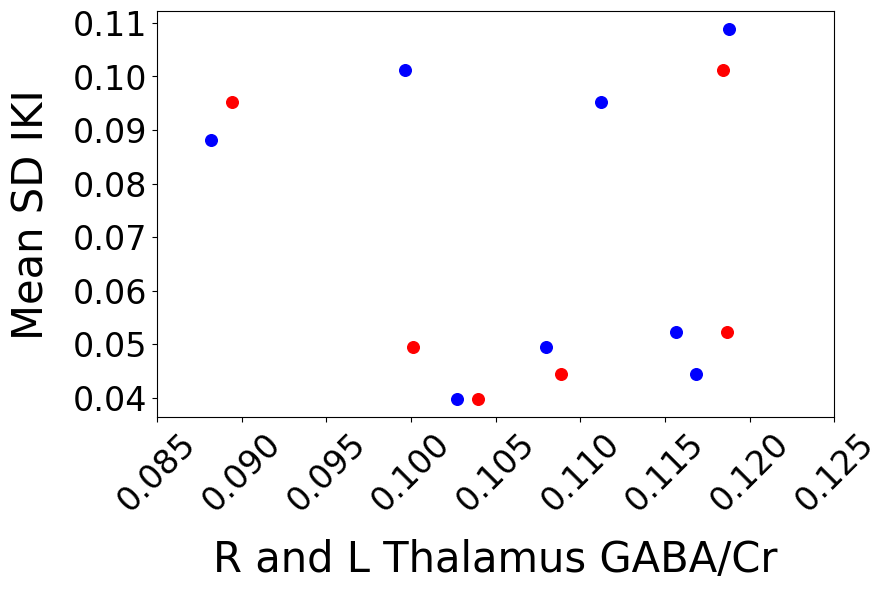

In [135]:
## all bf sds against L and R thalamus GABA
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(GABA_df.R_thal_GABA.dropna(), R_allbf_sds, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_thal_GABA.dropna(), L_allbf_sds, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L Thalamus GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean SD IKI", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig('RLthal_allbfsd.png', dpi=300)
plt.show()

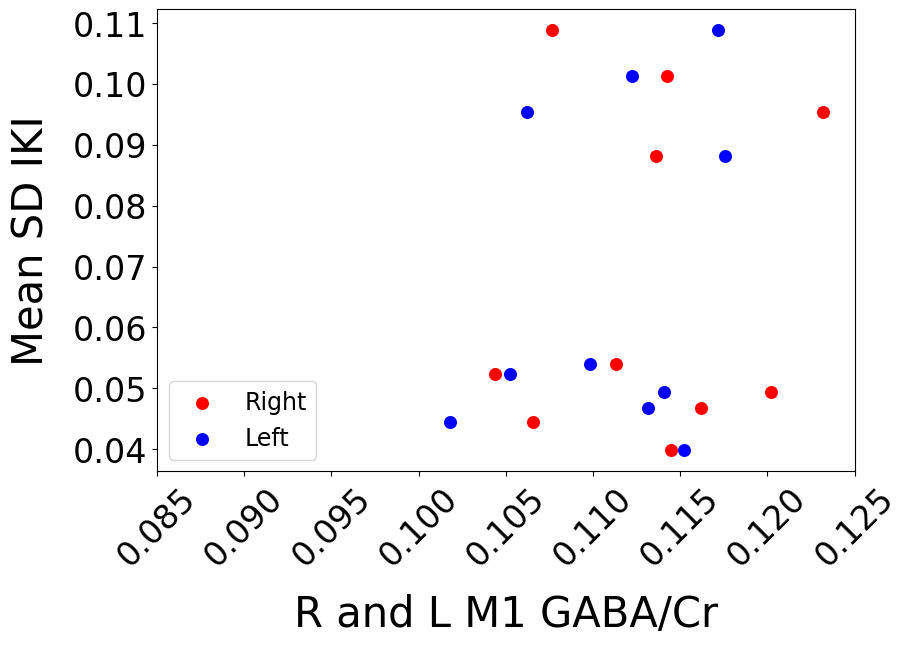

In [136]:
## all bf sds against L and R M1 GABA
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_avg_sd_iki, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_avg_sd_iki, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean SD IKI", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

plt.legend(fontsize = '17',loc="lower left")

plt.savefig('RLM1_allbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [137]:
## highbf sds against L_thal GABA
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6))
plt.scatter(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_highbf_sds['Avg SD IKI'], s = 70, color = 'black')
plt.xlabel("L Thalamus GABA", fontsize = 30, labelpad=15)
plt.ylabel("High Bigram Freq. Mean SD IKI", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

plt.savefig('Lthal_highbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

NameError: name 'GABA_Lthal' is not defined

In [138]:
## highbf sds against L_M1 GABA
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6))
plt.scatter(GABA_LM1['Mean_GABA_Cr'].dropna(), highbf_sds['Avg SD IKI'], s = 70, color = 'black')
plt.xlabel("L M1 GABA", fontsize = 30, labelpad=15)
plt.ylabel("High Bigram Freq. Mean SD IKI", fontsize = 30, labelpad=15)
# plt.xlim([0.1, 0.12])
plt.xticks(fontsize = 24, rotation = 45)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

plt.savefig('LM1_highbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

NameError: name 'GABA_LM1' is not defined

In [139]:
## all bf sds against L and R thalamus GABA
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(GABA_df.R_thal_GABA.dropna(), R_allbf_sds, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_thal_GABA.dropna(), L_allbf_sds, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L Thalamus GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean SD IKI", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig('RLthal_allbfsd.png', dpi=300)
plt.show()x

SyntaxError: invalid syntax (3827732972.py, line 38)

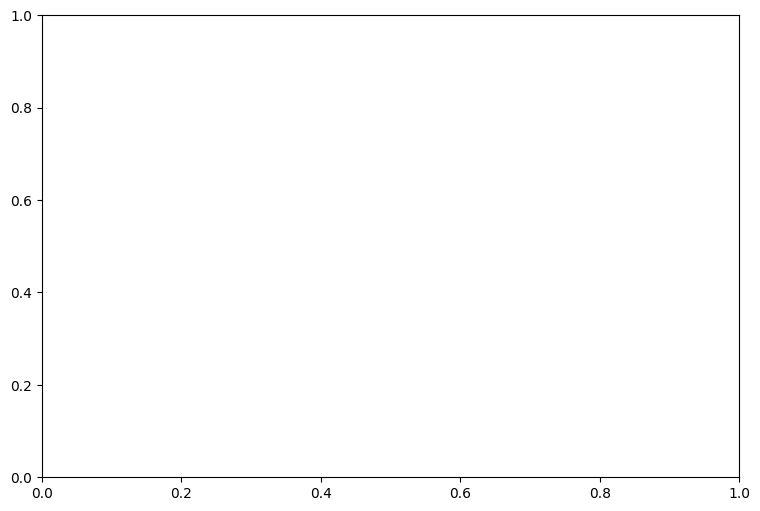

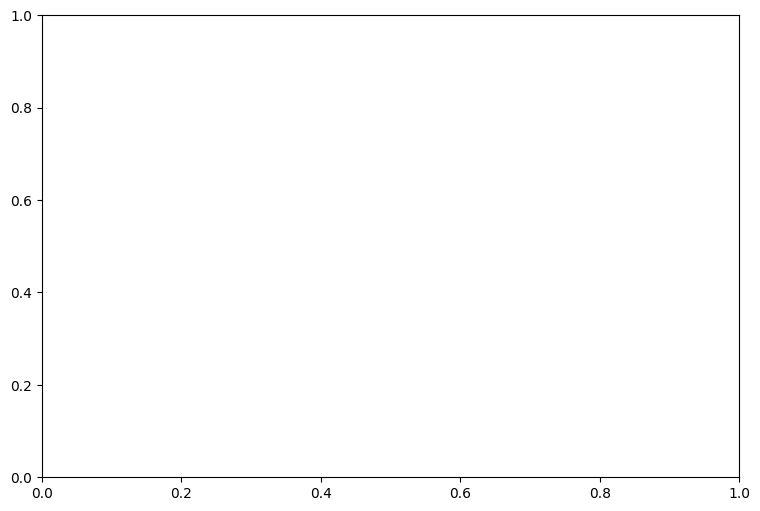

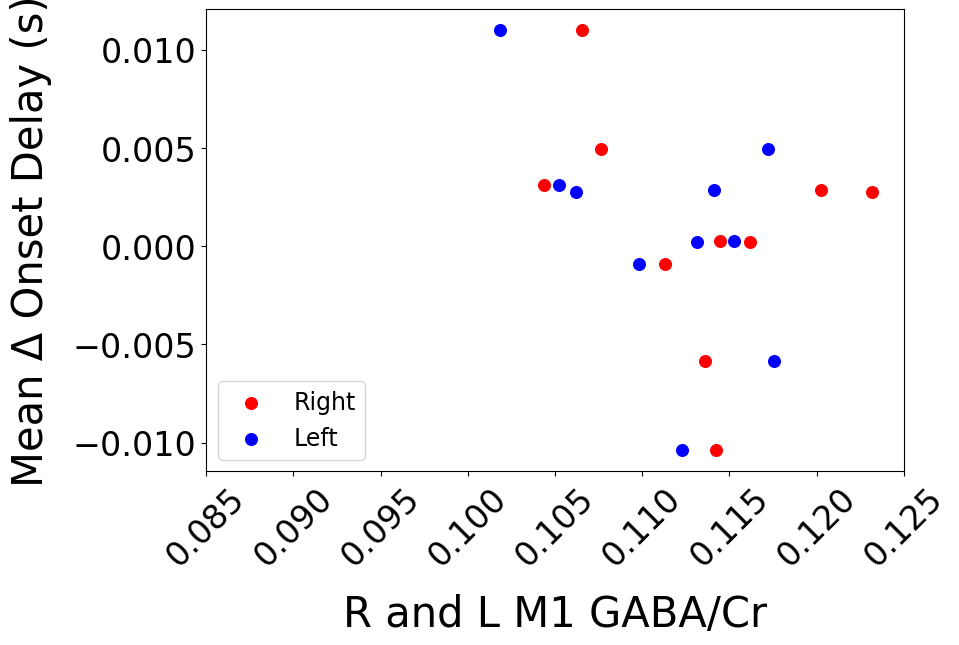

In [140]:
## all delta ods against L and R M1 GABA
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_deltaod, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_deltaod, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean Δ Onset Delay (s)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

plt.legend(fontsize = '17',loc="lower left")

plt.savefig((save_dir + '/RLM1_alldeltaod.png'), dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

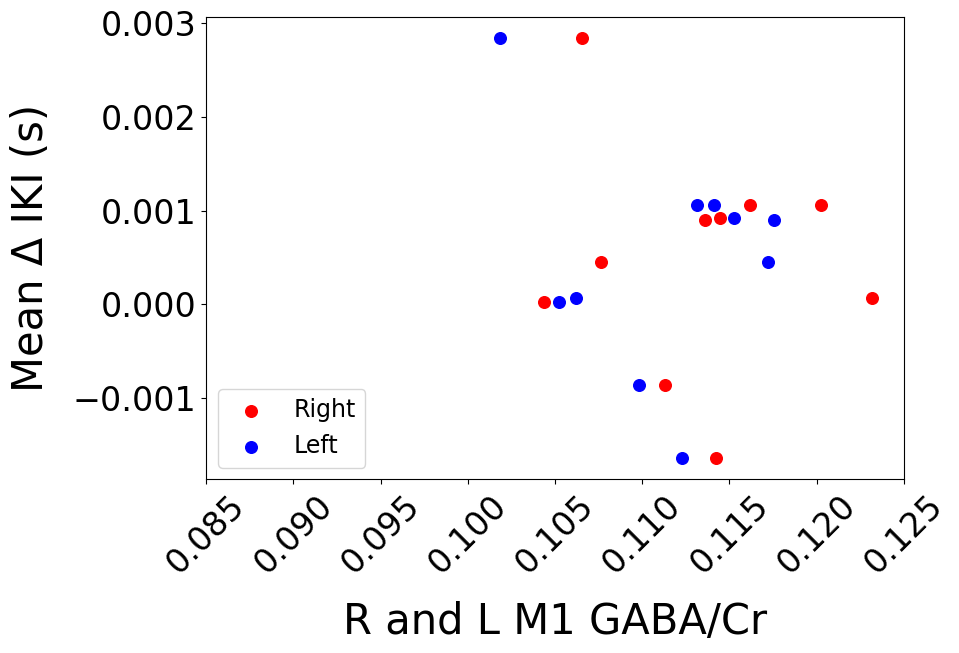

In [143]:
# all delta ikis against L and R M1 GABA
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_deltaiki, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_deltaiki, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean Δ IKI (s)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

plt.legend(fontsize = '17',loc="lower left")

plt.savefig((save_dir + '/RLM1_alldeltaiki.png'), dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

## Graphs for F31

In [ ]:
ten_sub_list = ['s181', 's182', 's183', 's189', 's190', 
           's198', 's207', 's209', 's210', 's212']

ten_sub = corr_trials_bybg[corr_trials_bybg.sID.isin(ten_sub_list)].reset_index()

In [ ]:
## individual IKI means by BF (correct trials only) PRINT VERSION IN LIGHT MODE
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_means(ten_sub, 'bigram', typ.lowbf)['Avg IKI'], 
     indiv_means(ten_sub, 'bigram', typ.medbf)['Avg IKI'],
     indiv_means(ten_sub, 'bigram', typ.highbf)['Avg IKI'])
means = (np.mean(indiv_means(ten_sub, 'bigram', typ.lowbf)['Avg IKI']),
         np.mean(indiv_means(ten_sub, 'bigram', typ.medbf)['Avg IKI']),
         np.mean(indiv_means(ten_sub, 'bigram', typ.highbf)['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')
    
plt.xlim([1.5, 6.5])
plt.ylim([0.08, 0.4])
plt.xticks(x, ('', '', ''), fontsize = 24)
plt.xticks(x, ('Low', 'Med', 'High'))
plt.yticks(fontsize = 24)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
plt.ylabel("Mean IKI (s)", labelpad=15, fontsize = 24)
plt.title("")
plt.legend(fontsize = 17, loc="lower left")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('F31_indiv_mean_ikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## using bigrams sorted by BF (correct trials) -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_avgcvs(ten_sub, 'bigram', typ.lowbf)['Avg CV IKI'], 
     indiv_avgcvs(ten_sub, 'bigram', typ.medbf)['Avg CV IKI'], 
     indiv_avgcvs(ten_sub, 'bigram', typ.highbf)['Avg CV IKI'])
means = (np.mean(indiv_avgcvs(ten_sub, 'bigram', typ.lowbf)['Avg CV IKI']), 
         np.mean(indiv_avgcvs(ten_sub, 'bigram', typ.medbf)['Avg CV IKI']), 
         np.mean(indiv_avgcvs(ten_sub, 'bigram', typ.highbf)['Avg CV IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.10, 0.4])
plt.xticks(x, ('Low', 'Med', 'High'), fontsize = 24)
plt.yticks(fontsize = 24)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
plt.ylabel("Mean CV IKI (%)", labelpad=15, fontsize = 24)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('F31_indiv_cvikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## individual MEAN SD IKI by BF (correct trials) -- PRINT VERSION IN LIGHT MODE
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_avgsds(ten_sub, 'bigram', typ.lowbf)['Avg SD IKI'], 
     indiv_avgsds(ten_sub, 'bigram', typ.medbf)['Avg SD IKI'],
     indiv_avgsds(ten_sub, 'bigram', typ.highbf)['Avg SD IKI'])
means = (np.mean(indiv_avgsds(ten_sub, 'bigram', typ.lowbf)['Avg SD IKI']), 
         np.mean(indiv_avgsds(ten_sub, 'bigram', typ.medbf)['Avg SD IKI']),
         np.mean(indiv_avgsds(ten_sub, 'bigram', typ.highbf)['Avg SD IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.0, 0.10])
plt.xticks(x, ('', '', ''), fontsize = 24)
# plt.xticks(x, ('Low', 'Med', 'High'), fontsize = 24)
plt.yticks(fontsize = 24)
# plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
plt.ylabel("Mean SD IKI (s)", labelpad=15, fontsize = 24)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('F31_indiv_avgsds_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
incorr_ten_sub = incorr_bgs[incorr_bgs.sID.isin(ten_sub_list)].reset_index()

plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_error(incorr_ten_sub, 'bigram', typ.lowbf)['Total Error'], 
     indiv_error(incorr_ten_sub, 'bigram', typ.medbf)['Total Error'],
     indiv_error(incorr_ten_sub, 'bigram', typ.highbf)['Total Error'])

means = (np.mean(indiv_error(incorr_ten_sub, 'bigram', typ.lowbf)['Total Error']), 
         np.mean(indiv_error(incorr_ten_sub, 'bigram', typ.medbf)['Total Error']),
         np.mean(indiv_error(incorr_ten_sub, 'bigram', typ.highbf)['Total Error']))

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

plt.ylim([-1, 22])
plt.xlim([1.5, 6.5])
plt.xticks(x, ('Low', 'Med', 'High'), fontsize = 24)
plt.yticks(fontsize = 24)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
plt.ylabel("Indiv. Total Error", labelpad=15, fontsize = 24)

plt.title("")
# plt.legend(fontsize = 17, loc="best", facecolor = "black")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

fig.tight_layout()
plt.savefig('F31_meanerr_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## plotting BF distribution of data set -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (low_bgs['Frequency'], med_bgs['Frequency'], high_bgs['Frequency'])

fig, ax = plt.subplots(figsize=(9.25, 7))

violin = ax.violinplot(D, [2, 4, 6], showmeans= True)

for pc in violin["bodies"]:
    pc.set_facecolor("blue")
    pc.set_edgecolor("black")
    pc.set_alpha(0.5)

# boxprops = dict(linestyle='-', linewidth=2, color = 'black')
# whiskerprops = dict(linewidth=2, color = 'black')
# capprops = dict(linewidth=2, color = 'black')
# flierprops = dict(markerfacecolor='royalblue', markersize=10)
# medianprops = dict(linewidth=2, color='red')

# ax.boxplot(D, positions=x, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
#           flierprops=flierprops, medianprops=medianprops)


plt.xlim([1, 7])
plt.xticks(x, ('Low', 'Med', 'High'), fontsize = 24)
plt.yticks(fontsize = 24)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
# plt.ylim([0, 0.8])
plt.ylabel("Bigram Frequency (10 mil)", labelpad=15, fontsize = 24)
plt.title("")
# plt.legend(loc="best")

ax.yaxis.offsetText.set_fontsize(18)
ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

fig.tight_layout()
plt.savefig('F31_bf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none')
plt.show()

In [ ]:
## anova for sds (by bg freq)
high_sd = indiv_avgsds(ten_sub, 'bigram', typ.highbf)
high_sd['bf_type'] = 'high'
med_sd = indiv_avgsds(ten_sub, 'bigram', medbf_norep)
med_sd['bf_type'] = 'med'
low_sd = indiv_avgsds(ten_sub, 'bigram', lowbf_norep)
low_sd['bf_type'] = 'low'

sds = pd.concat([high_sd, med_sd, low_sd], ignore_index=True)
# print(sds)

sd_anova = pg.rm_anova(sds, 'Avg SD IKI', 'bf_type', 'sID')
print(sd_anova)

pg.pairwise_tukey(sds, 'Avg SD IKI', 'bf_type', effsize='cohen')